Import Libraries and Upload Data

In [608]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import scipy.stats as stats
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from scipy.stats import pearsonr

# Display settings
pd.set_option('display.max_columns', None)
sns.set(style='whitegrid')

In [609]:
# Upload files if running in Colab
from google.colab import files
#uploaded = files.upload()

Load Datasets

In [610]:
# Load files (update filenames if needed)
sales = pd.read_csv('/content/Online_Sales.csv', parse_dates=['Transaction_Date'])
customers = pd.read_csv('/content/Customers_Data.csv')
discounts = pd.read_csv('/content/Discount_Coupon.csv')
marketing = pd.read_csv('/content/Marketing_Spend.csv', parse_dates=['Date'])
tax = pd.read_csv('/content/Tax_amount.csv')

Preprocessing – Create Monthly Metrics

In [611]:
# Extract month-year from date
sales['Month'] = sales['Transaction_Date'].dt.to_period('M').astype(str)

# Acquisition: new customers per month
first_purchase = sales.groupby('CustomerID')['Transaction_Date'].min().reset_index()
first_purchase['Acquisition_Month'] = first_purchase['Transaction_Date'].dt.to_period('M').astype(str)

# Merge with sales for retention analysis
sales = sales.merge(first_purchase[['CustomerID', 'Acquisition_Month']], on='CustomerID')

Business questions:

1. Identify the months with the highest and lowest acquisition rates. What strategies could be implemented to address the fluctuations and ensure consistent growth throughout the year?

2. Analyze the data to determine if certain months consistently show higher or lower acquisition rates. How can the company capitalize on high-performing months and improve performance during slower periods?

Monthly Acquisition Analysis

<ipython-input-612-4b4cc7262e4c>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_acquisition, x='Month', y='New_Customers', palette='coolwarm')


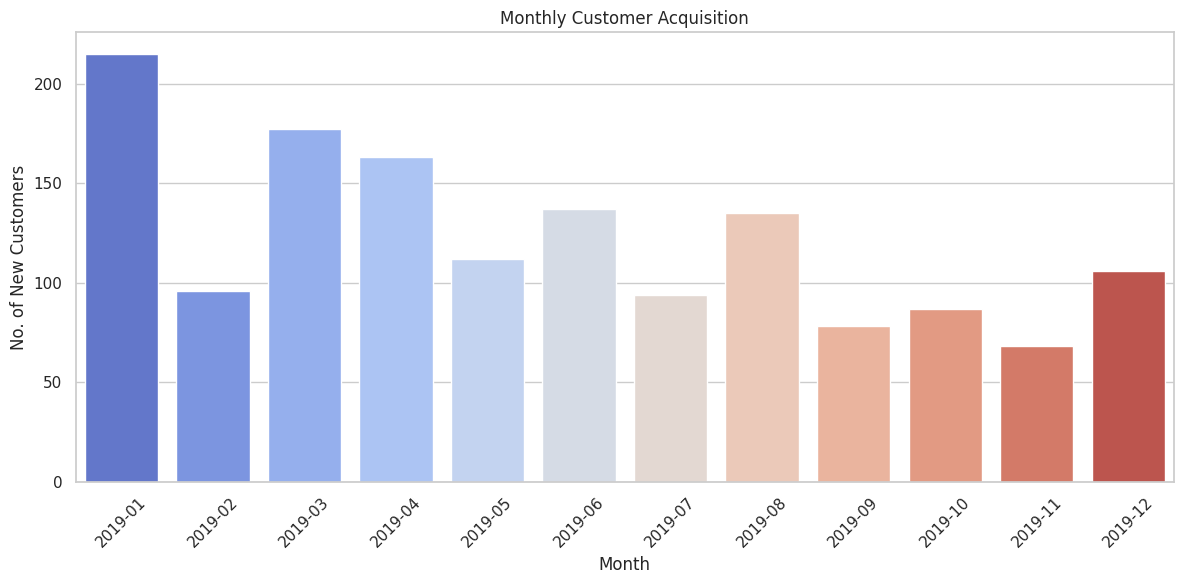

Highest Acquisition Month: 2019-01 with 215 customers
Lowest Acquisition Month: 2019-11 with 68 customers


In [612]:
# Monthly acquisition count
monthly_acquisition = first_purchase.groupby('Acquisition_Month')['CustomerID'].nunique().reset_index()
monthly_acquisition.columns = ['Month', 'New_Customers']

# Plot acquisition
plt.figure(figsize=(12,6))
sns.barplot(data=monthly_acquisition, x='Month', y='New_Customers', palette='coolwarm')
plt.xticks(rotation=45)
plt.title('Monthly Customer Acquisition')
plt.ylabel('No. of New Customers')
plt.xlabel('Month')
plt.tight_layout()
plt.show()

# Identify peak and dip months
max_month = monthly_acquisition.loc[monthly_acquisition['New_Customers'].idxmax()]
min_month = monthly_acquisition.loc[monthly_acquisition['New_Customers'].idxmin()]

print(f"Highest Acquisition Month: {max_month['Month']} with {max_month['New_Customers']} customers")
print(f"Lowest Acquisition Month: {min_month['Month']} with {min_month['New_Customers']} customers")


By observing the above result, we can give the following Strategy Suggestions.

In [613]:
print("\n🎯 Strategy Suggestions:")
print("- Increase targeted marketing spend in slower months based on customer insights")
print("- Introduce seasonal promotions during historically low acquisition months")
print("- Capitalize on peak months by scaling up logistics and ad budget")


🎯 Strategy Suggestions:
- Increase targeted marketing spend in slower months based on customer insights
- Introduce seasonal promotions during historically low acquisition months
- Capitalize on peak months by scaling up logistics and ad budget


Business questions:

3. Identify periods with the strongest and weakest retention rates. What strategies could be implemented to improve retention during weaker months?

Our assumption: A customer is retained if they make a repeat purchase in a later month.

In [614]:
# Get month-wise repeat customers
sales['Month'] = sales['Transaction_Date'].dt.to_period('M').astype(str)

# Track first purchase month
customer_months = sales.groupby('CustomerID')['Month'].min().reset_index()
customer_months.columns = ['CustomerID', 'First_Month']

# Retained = appears in >1 month
repeat_customers = sales.groupby('CustomerID')['Month'].nunique().reset_index()
repeat_customers['Retained'] = repeat_customers['Month'] > 1

# Join with acquisition month
retention_data = customer_months.merge(repeat_customers[['CustomerID', 'Retained']], on='CustomerID')
retention_data

CustomerID First_Month  Retained
0          12346     2019-09     False
1          12347     2019-03      True
2          12348     2019-06      True
3          12350     2019-12     False
4          12356     2019-09     False
...          ...         ...       ...
1463       18259     2019-04     False
1464       18260     2019-06      True
1465       18269     2019-04      True
1466       18277     2019-10     False
1467       18283     2019-07      True

[1468 rows x 3 columns]

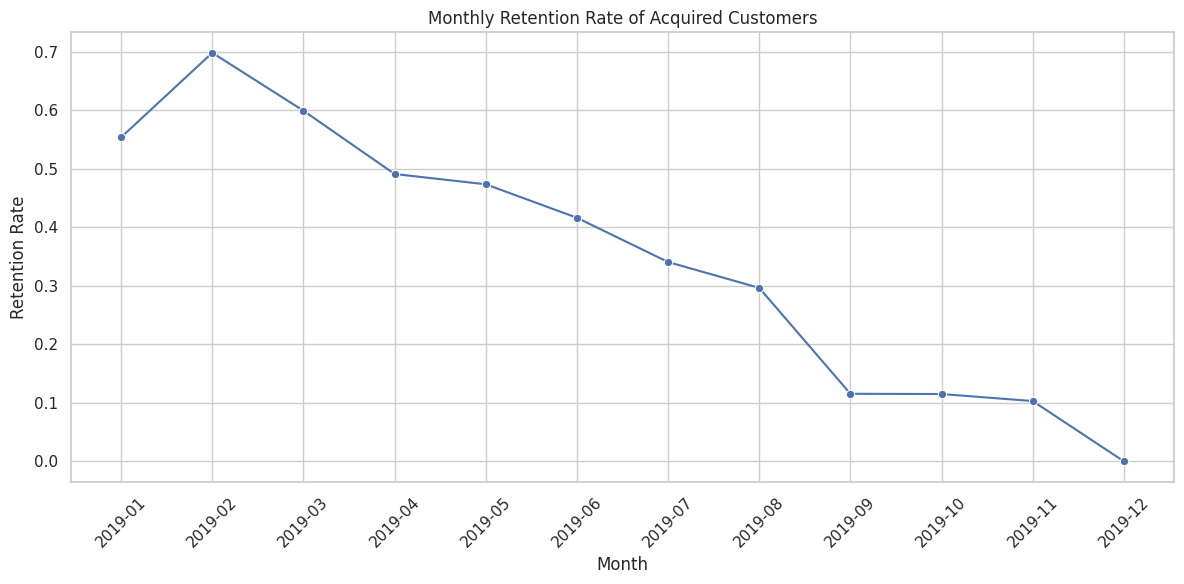

Strongest Retention: 2019-02 with 69.79%
Weakest Retention: 2019-12 with 0.00%


In [615]:
# Monthly retention rate
monthly_retention = retention_data.groupby('First_Month')['Retained'].mean().reset_index()
monthly_retention.columns = ['Month', 'Retention_Rate']

# Plot
plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_retention, x='Month', y='Retention_Rate', marker='o')
plt.xticks(rotation=45)
plt.title('Monthly Retention Rate of Acquired Customers')
plt.ylabel('Retention Rate')
plt.xlabel('Month')
plt.tight_layout()
plt.show()

# Identify best and worst months
best_ret = monthly_retention.loc[monthly_retention['Retention_Rate'].idxmax()]
worst_ret = monthly_retention.loc[monthly_retention['Retention_Rate'].idxmin()]

print(f"Strongest Retention: {best_ret['Month']} with {best_ret['Retention_Rate']*100:.2f}%")
print(f"Weakest Retention: {worst_ret['Month']} with {worst_ret['Retention_Rate']*100:.2f}%")

Business questions:

4. Analyze customer behavior during high-retention months and suggest ways to replicate this success throughout the year.

Approach:

- Firstly, we need to identify high-retention months (already achieved through the solution of Business Question-3).

- Then we will filter customers acquired in those months and analyze their behavior:

    --> Purchase frequency

    --> Average basket size (i.e., quantity)

    --> Average order value (AOV)

    --> Coupon usage

    --> Category preferences

- After that we need to compare with low-retention months

- Then we can suggest improvements based on observed behavior

In [616]:
# Here we have to use retention_data and monthly_retention which are already created from Business Question-3 solution.

# Step 1: Identifying high- and low-retention months
high_ret_month = monthly_retention.sort_values('Retention_Rate', ascending=False).iloc[0]['Month']
low_ret_month = monthly_retention.sort_values('Retention_Rate').iloc[0]['Month']

print(f"High Retention Month: {high_ret_month}")
print(f"Low Retention Month: {low_ret_month}")

# Step 2: Getting customer IDs based on 'First_Month' for both the groups (high retention & low retention groups)
high_ret_customers = retention_data[retention_data['First_Month'] == high_ret_month]['CustomerID']
low_ret_customers = retention_data[retention_data['First_Month'] == low_ret_month]['CustomerID']
print("low_ret_customers:")
print(low_ret_customers)

# Step 3: Filtering the high and low retention customers transactions
high_group = sales[sales['CustomerID'].isin(high_ret_customers)]
low_group = sales[sales['CustomerID'].isin(low_ret_customers)]

High Retention Month: 2019-02
Low Retention Month: 2019-12
low_ret_customers:
3       12350
7       12373
15      12410
17      12414
31      12464
        ...  
1309    17672
1385    17929
1408    18017
1450    18202
1461    18250
Name: CustomerID, Length: 106, dtype: int64


Behavioral Metrics Calculation

In [617]:
high_group.head(6)

CustomerID  Transaction_ID Transaction_Date     Product_SKU  \
4098       16883           19399       2019-02-01  GGOEYAFB073115   
4099       16883           19400       2019-02-01  GGOENEBB078899   
4100       16883           19401       2019-02-01  GGOEGADB059614   
4101       16883           19402       2019-02-01  GGOENEBJ079499   
4102       16883           19405       2019-02-01  GGOENEBJ079499   
4103       16883           19406       2019-02-01  GGOENEBQ079199   

                                    Product_Description Product_Category  \
4098                  YouTube Men's Fleece Hoodie Black          Apparel   
4099              Nest Cam Indoor Security Camera - USA         Nest-USA   
4100          Google Men's Quilted Insulated Vest Black          Apparel   
4101  Nest Learning Thermostat 3rd Gen-USA - Stainle...         Nest-USA   
4102  Nest Learning Thermostat 3rd Gen-USA - Stainle...         Nest-USA   
4103      Nest Protect Smoke + CO White Wired Alarm-USA         Nest-USA   

      Quantity  Avg_Price  Delivery_Charges Coupon_Status    Month  \
4098         1      55.99              6.50          Used  2019-02   
4099         1     119.00              6.50       Clicked  2019-02   
4100         1      59.99             13.78          Used  2019-02   
4101         1     149.00              6.50          Used  2019-02   
4102         1     149.00              6.50          Used  2019-02   
4103         2      99.00              6.50       Clicked  2019-02   

     Acquisition_Month  
4098           2019-02  
4099           2019-02  
4100           2019-02  
4101           2019-02  
4102           2019-02  
4103           2019-02

In [618]:
low_group.head(6)

CustomerID  Transaction_ID Transaction_Date     Product_SKU  \
48424       17619           45272       2019-12-01  GGOEGBRJ037299   
48425       17619           45273       2019-12-01  GGOENEBQ081599   
48426       17619           45274       2019-12-01  GGOENEBJ079499   
48427       17619           45276       2019-12-01  GGOEGBMJ013399   
48428       17619           45276       2019-12-01  GGOEGOLC014299   
48429       17619           45277       2019-12-01  GGOENEBD084799   

                                     Product_Description Product_Category  \
48424                       Google Alpine Style Backpack             Bags   
48425              Nest Cam Outdoor Security Camera - CA      Nest-Canada   
48426  Nest Learning Thermostat 3rd Gen-USA - Stainle...         Nest-USA   
48427                                          Sport Bag             Bags   
48428                       Google Metallic Notebook Set           Office   
48429      Nest Learning Thermostat 3rd Gen-USA - Copper         Nest-USA   

       Quantity  Avg_Price  Delivery_Charges Coupon_Status    Month  \
48424         1     101.92              6.00       Clicked  2019-12   
48425         1     151.88              8.70          Used  2019-12   
48426         1     151.88              6.50      Not Used  2019-12   
48427        21       4.07             19.99          Used  2019-12   
48428        21       4.88             19.99       Clicked  2019-12   
48429         1     151.88              6.50          Used  2019-12   

      Acquisition_Month  
48424           2019-12  
48425           2019-12  
48426           2019-12  
48427           2019-12  
48428           2019-12  
48429           2019-12

In [619]:
high_group['Product_Category'].unique()

array(['Apparel', 'Nest-USA', 'Office', 'Headgear', 'Bags', 'Drinkware',
       'Google', 'Lifestyle', 'Notebooks & Journals', 'Backpacks',
       'Gift Cards', 'Nest-Canada', 'Housewares', 'Waze', 'Fun',
       'Bottles', 'More Bags', 'Android', 'Accessories', 'Nest'],
      dtype=object)

In [620]:
low_group['Product_Category'].unique()

array(['Bags', 'Nest-Canada', 'Nest-USA', 'Office', 'Apparel',
       'Accessories', 'Nest', 'Headgear', 'Lifestyle', 'Waze',
       'Drinkware', 'Notebooks & Journals', 'Gift Cards'], dtype=object)

In [621]:
def behavior_metrics(df, group_name):
    metrics = {
        'Group': group_name,
        'Total_Customers': df['CustomerID'].nunique(),
        'Avg_Orders_Per_Customer': df.groupby('CustomerID')['Transaction_ID'].nunique().mean(),
        'Avg_Quantity_Per_Order': df.groupby('Transaction_ID')['Quantity'].sum().mean(),
        'Avg_Order_Value': (df['Quantity'] * df['Avg_Price'] + df['Delivery_Charges']).mean(),
        'Coupon_Usage_Rate': df['Coupon_Status'].notnull().mean(),
        'Top_Category': df['Product_Category'].mode()[0] if not df['Product_Category'].isna().all() else "N/A"
    }
    return metrics

high_metrics = behavior_metrics(high_group, 'High Retention')
low_metrics = behavior_metrics(low_group, 'Low Retention')
print("High retention group Metrics:")
print(high_metrics)
print("\nLow retention group Metrics:")
print(low_metrics)

# Combine and show
compare_df = pd.DataFrame([high_metrics, low_metrics])
print("\nCompare High & Low retention group Metrics:")
compare_df

High retention group Metrics:
{'Group': 'High Retention', 'Total_Customers': 96, 'Avg_Orders_Per_Customer': np.float64(32.322916666666664), 'Avg_Quantity_Per_Order': np.float64(8.875900458415193), 'Avg_Order_Value': np.float64(99.02190537495979), 'Coupon_Usage_Rate': np.float64(1.0), 'Top_Category': 'Apparel'}

Low retention group Metrics:
{'Group': 'Low Retention', 'Total_Customers': 106, 'Avg_Orders_Per_Customer': np.float64(12.320754716981131), 'Avg_Quantity_Per_Order': np.float64(5.340062111801243), 'Avg_Order_Value': np.float64(121.65402109124254), 'Coupon_Usage_Rate': np.float64(1.0), 'Top_Category': 'Nest-USA'}

Compare High & Low retention group Metrics:


Group  Total_Customers  Avg_Orders_Per_Customer  \
0  High Retention               96                32.322917   
1   Low Retention              106                12.320755   

   Avg_Quantity_Per_Order  Avg_Order_Value  Coupon_Usage_Rate Top_Category  
0                8.875900        99.021905                1.0      Apparel  
1                5.340062       121.654021                1.0     Nest-USA

**Barplot:** Let's Visualize the above comparison through Barplot

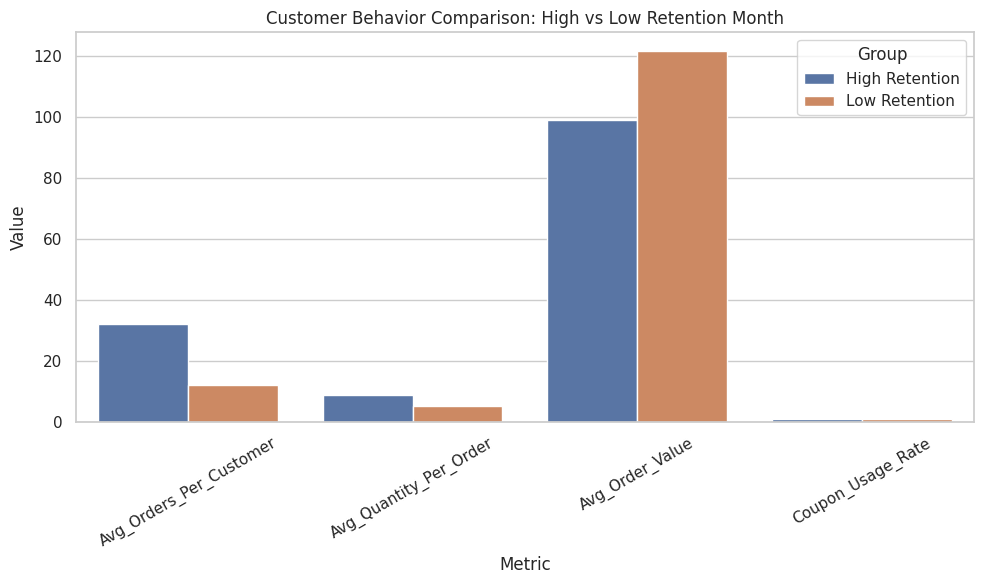

In [622]:
# Convert to suitable format for plotting
melted = compare_df[['Group', 'Avg_Orders_Per_Customer', 'Avg_Quantity_Per_Order',
                     'Avg_Order_Value', 'Coupon_Usage_Rate']].melt(id_vars='Group')

plt.figure(figsize=(10,6))
sns.barplot(data=melted, x='variable', y='value', hue='Group')
plt.title('Customer Behavior Comparison: High vs Low Retention Month')
plt.ylabel('Value')
plt.xlabel('Metric')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

**Pie Chart / Donut Chart:** (for category breakdowns)

In the following code cell, we want to show top product categories purchased in high- vs low-retention months.

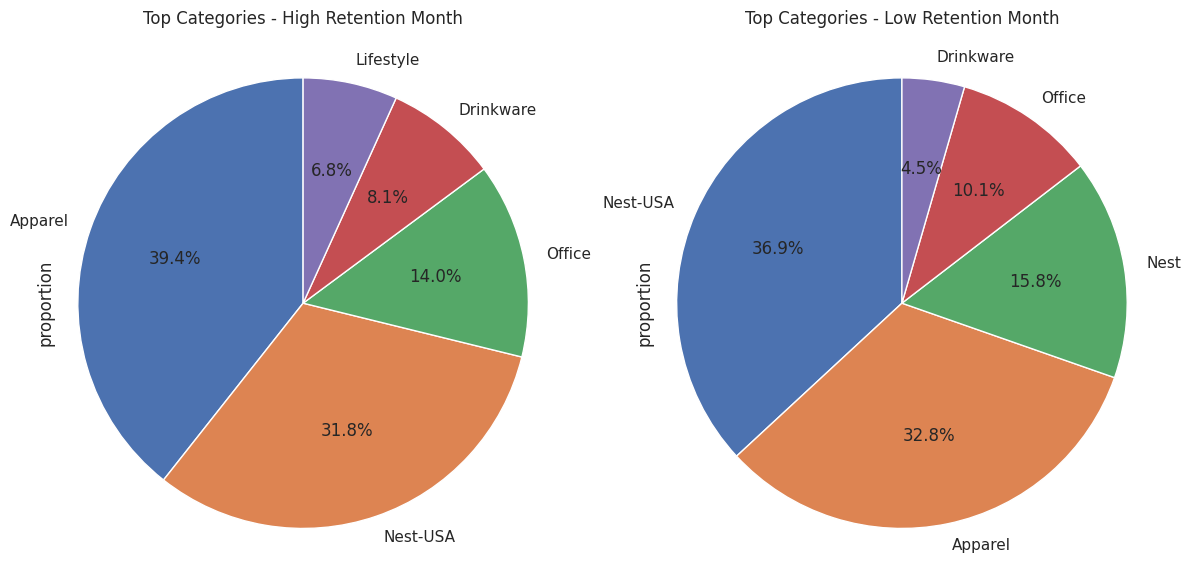

In [623]:
top_high = high_group['Product_Category'].value_counts(normalize=True).head(5)
top_low = low_group['Product_Category'].value_counts(normalize=True).head(5)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
top_high.plot(kind='pie', ax=ax[0], autopct='%1.1f%%', startangle=90)
ax[0].set_title('Top Categories - High Retention Month')
ax[0].axis('equal')

top_low.plot(kind='pie', ax=ax[1], autopct='%1.1f%%', startangle=90)
ax[1].set_title('Top Categories - Low Retention Month')
ax[1].axis('equal')

plt.tight_layout()
plt.show()

**Heatmap:** If we create a DataFrame summarizing many numeric customer behaviors for high retention customers, then we can observe the folowing through correlation (Heatmap):

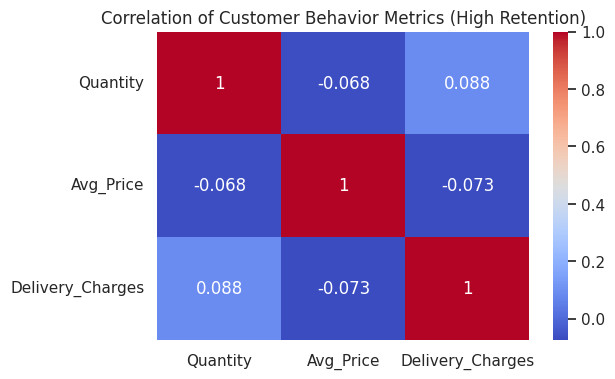

In [624]:
summary_df = high_group.groupby('CustomerID')[['Quantity', 'Avg_Price', 'Delivery_Charges']].mean()
plt.figure(figsize=(6,4))
sns.heatmap(summary_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation of Customer Behavior Metrics (High Retention)")
plt.show()

**Line Plot:** By using Line Plot, in the below code cell, we will show the trend over time.

Here, we show how behavior changes within the high and low retention group over months:
- Average Price Trend - High Retention Customers

<ipython-input-625-24afb51008a7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_group['Month'] = pd.to_datetime(high_group['Transaction_Date']).dt.to_period('M')


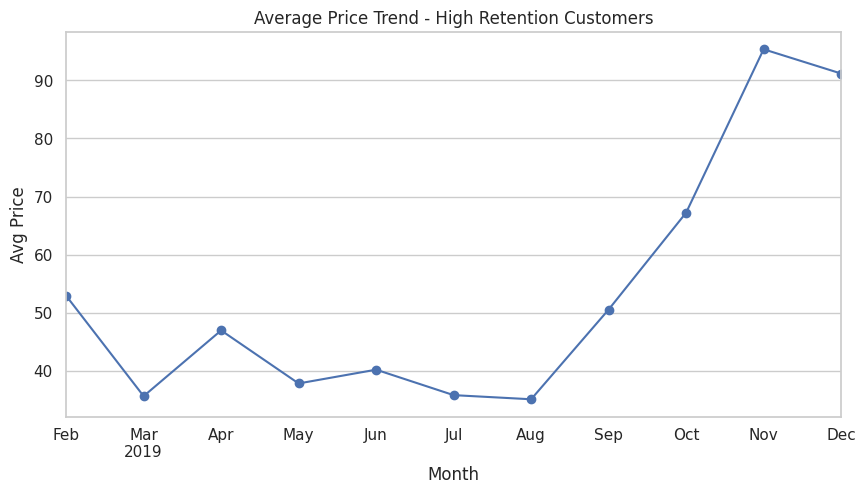

In [625]:
# Convert Transaction_Date to datetime if not already
sales['Transaction_Date'] = pd.to_datetime(sales['Transaction_Date'])

# Add Month column
high_group['Month'] = pd.to_datetime(high_group['Transaction_Date']).dt.to_period('M')
monthly_spend = high_group.groupby('Month')['Avg_Price'].mean()

monthly_spend.plot(kind='line', marker='o', figsize=(10,5))
plt.title("Average Price Trend - High Retention Customers")
plt.ylabel("Avg Price")
plt.xlabel("Month")
plt.grid(True)
plt.show()

- Average Price Trend - Low Retention Customers

<ipython-input-626-732c30f3dbd8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_group['Month'] = pd.to_datetime(low_group['Transaction_Date']).dt.to_period('M')
/usr/local/lib/python3.11/dist-packages/pandas/plotting/_matplotlib/core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)


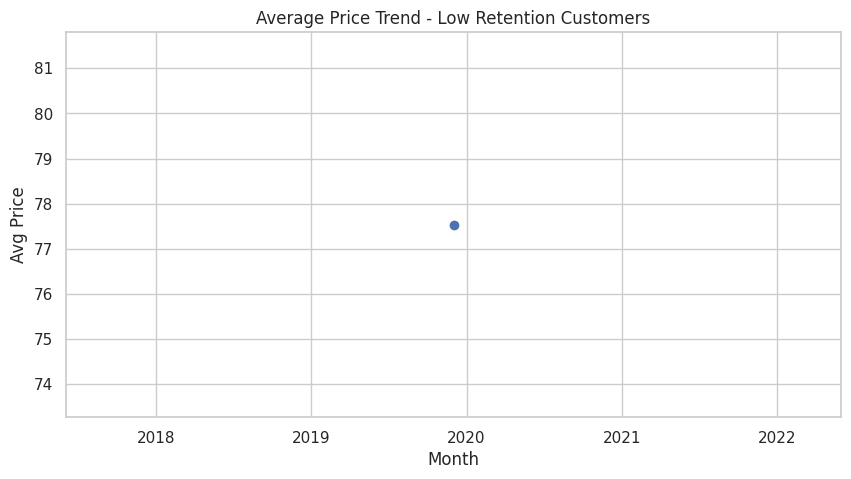

In [626]:
# Convert Transaction_Date to datetime if not already
sales['Transaction_Date'] = pd.to_datetime(sales['Transaction_Date'])

# Add Month column
low_group['Month'] = pd.to_datetime(low_group['Transaction_Date']).dt.to_period('M')
monthly_spend = low_group.groupby('Month')['Avg_Price'].mean()

monthly_spend.plot(kind='line', marker='o', figsize=(10,5))
plt.title("Average Price Trend - Low Retention Customers")
plt.ylabel("Avg Price")
plt.xlabel("Month")
plt.grid(True)
plt.show()


In the above plot, we are observing only a Single Red Dot for low retention group customers.

The reason is that our low_group['Transaction_Date'] shows below that all transactions are only from December 2019.

In [627]:
low_group['Transaction_Date'].unique()

<DatetimeArray>
['2019-12-01 00:00:00', '2019-12-02 00:00:00', '2019-12-03 00:00:00',
 '2019-12-04 00:00:00', '2019-12-05 00:00:00', '2019-12-06 00:00:00',
 '2019-12-07 00:00:00', '2019-12-08 00:00:00', '2019-12-09 00:00:00',
 '2019-12-10 00:00:00', '2019-12-11 00:00:00', '2019-12-12 00:00:00',
 '2019-12-13 00:00:00', '2019-12-14 00:00:00', '2019-12-15 00:00:00',
 '2019-12-16 00:00:00', '2019-12-17 00:00:00', '2019-12-18 00:00:00',
 '2019-12-19 00:00:00', '2019-12-20 00:00:00', '2019-12-21 00:00:00',
 '2019-12-22 00:00:00', '2019-12-23 00:00:00', '2019-12-24 00:00:00',
 '2019-12-25 00:00:00', '2019-12-26 00:00:00', '2019-12-27 00:00:00',
 '2019-12-28 00:00:00', '2019-12-29 00:00:00', '2019-12-30 00:00:00',
 '2019-12-31 00:00:00']
Length: 31, dtype: datetime64[ns]

- Average Price Trend - Within High & Low Retention Customers

<ipython-input-628-b7d53ed8452a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_group['Transaction_Date'] = pd.to_datetime(high_group['Transaction_Date'])
<ipython-input-628-b7d53ed8452a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_group['Transaction_Date'] = pd.to_datetime(low_group['Transaction_Date'])
<ipython-input-628-b7d53ed8452a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

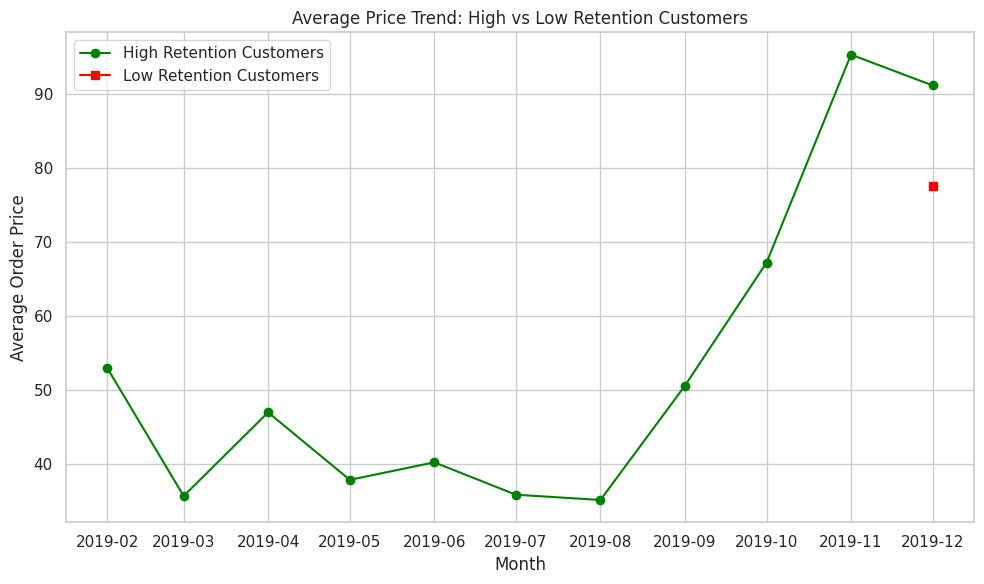

In [628]:
# Converting Transaction_Date into datetime format
sales['Transaction_Date'] = pd.to_datetime(sales['Transaction_Date'])
high_group['Transaction_Date'] = pd.to_datetime(high_group['Transaction_Date'])
low_group['Transaction_Date'] = pd.to_datetime(low_group['Transaction_Date'])

# Add 'Month' as a period
high_group['Month'] = high_group['Transaction_Date'].dt.to_period('M')
low_group['Month'] = low_group['Transaction_Date'].dt.to_period('M')

# Group by Month and calculating average order price
high_monthly = high_group.groupby('Month')['Avg_Price'].mean()
low_monthly = low_group.groupby('Month')['Avg_Price'].mean()

# Converting PeriodIndex to datetime for plotting
high_monthly.index = high_monthly.index.to_timestamp()
low_monthly.index = low_monthly.index.to_timestamp()

# Plotting both lines on the same plot
plt.figure(figsize=(10,6))
plt.plot(high_monthly, marker='o', label='High Retention Customers', color='green')
plt.plot(low_monthly, marker='s', label='Low Retention Customers', color='red')

plt.title("Average Price Trend: High vs Low Retention Customers")
plt.xlabel("Month")
plt.ylabel("Average Order Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Strip Plot:** Showing individual customer variability.

In the below code cell, we plot the Individual Order Prices: High vs Low Retention

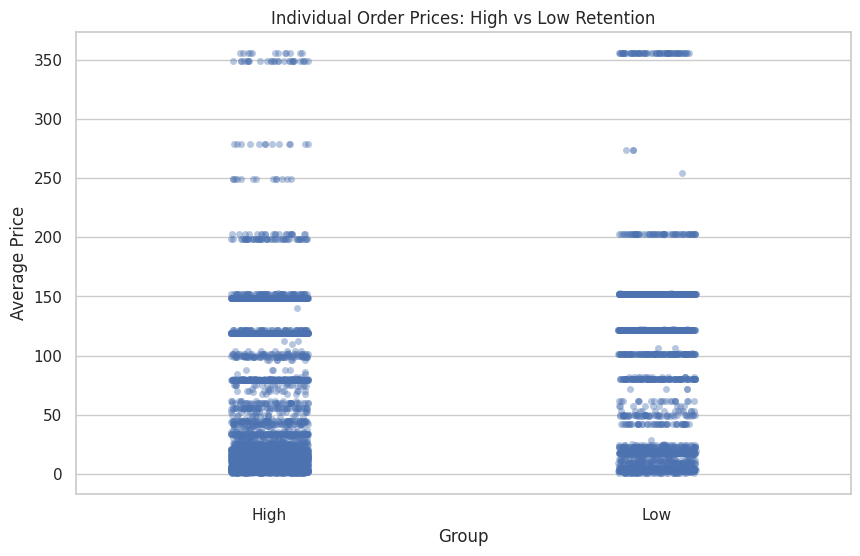

In [629]:
# Combining high and low retention groups using pd.concat
combined_df = pd.concat([
    high_group.assign(Group='High'),
    low_group.assign(Group='Low')
])

# Plotting using seaborn
plt.figure(figsize=(10,6))
sns.stripplot(data=combined_df, x='Group', y='Avg_Price', jitter=True, alpha=0.4)
plt.title('Individual Order Prices: High vs Low Retention')
plt.ylabel('Average Price')
plt.show()

Based on the above result and insights, we can suggest the following strategies.

In [630]:
print("\n📌 Strategy Suggestions to Replicate High Retention Success:")

if high_metrics['Coupon_Usage_Rate'] > low_metrics['Coupon_Usage_Rate']:
    print("- Increase targeted and personalized coupon distribution in low retention months.")

if high_metrics['Avg_Orders_Per_Customer'] > low_metrics['Avg_Orders_Per_Customer']:
    print("- Use loyalty points or re-purchase offers to encourage more frequent transactions.")

if high_metrics['Top_Category'] != low_metrics['Top_Category']:
    print(f"- Promote '{high_metrics['Top_Category']}' category more, as it performs better in high retention periods.")

print("- Provide consistent delivery and service quality that matches peak performance months.")


📌 Strategy Suggestions to Replicate High Retention Success:
- Use loyalty points or re-purchase offers to encourage more frequent transactions.
- Promote 'Apparel' category more, as it performs better in high retention periods.
- Provide consistent delivery and service quality that matches peak performance months.


Business questions:

5. Compare the revenue generated by new and existing customers month-over-month. What does this trend suggest about the balance between acquisition and retention efforts?

To solve the above Business Question, we need to compare Revenue - New vs Existing Customers

In [631]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Load your dataset here (replace with actual path in Colab)
# # sales = pd.read_csv('Online_Sales.csv')

# Converting Transaction_Date to datetime
sales['Transaction_Date'] = pd.to_datetime(sales['Transaction_Date'])

# Calculating Revenue
sales['Revenue'] = sales['Quantity'] * sales['Avg_Price'] + sales['Delivery_Charges']

# Extracting Month
sales['Month'] = sales['Transaction_Date'].dt.to_period('M')

# Identifying First Purchase Month for each customer
first_purchase = sales.groupby('CustomerID')['Transaction_Date'].min().reset_index()
first_purchase.columns = ['CustomerID', 'First_Purchase_Date']
first_purchase['First_Purchase_Month'] = first_purchase['First_Purchase_Date'].dt.to_period('M')

# Merging with main sales data
sales = sales.merge(first_purchase[['CustomerID', 'First_Purchase_Month']], on='CustomerID', how='left')

# Label New vs Existing
sales['Customer_Type'] = sales.apply(
    lambda row: 'New' if row['Month'] == row['First_Purchase_Month'] else 'Existing',
    axis=1
)

# Grouping by Month and Customer Type
revenue_by_type = sales.groupby(['Month', 'Customer_Type'])['Revenue'].sum().reset_index()

# Pivot for plotting
revenue_pivot = revenue_by_type.pivot(index='Month', columns='Customer_Type', values='Revenue').fillna(0)
revenue_pivot = revenue_pivot.sort_index()
print("\nInterpretation: Month, New Revenue & Existing Revenue")
revenue_pivot


Interpretation: Month, New Revenue & Existing Revenue


Customer_Type   Existing        New
Month                              
2019-01             0.00  462866.90
2019-02         45272.03  314764.37
2019-03         68294.39  342113.64
2019-04        181160.67  261939.49
2019-05        126001.97  223157.62
2019-06        144648.05  213946.91
2019-07        253328.88  168033.12
2019-08        241454.08  220855.86
2019-09        236956.08  164597.74
2019-10        211415.36  244227.80
2019-11        309487.80  231766.75
2019-12        295812.76  265327.42

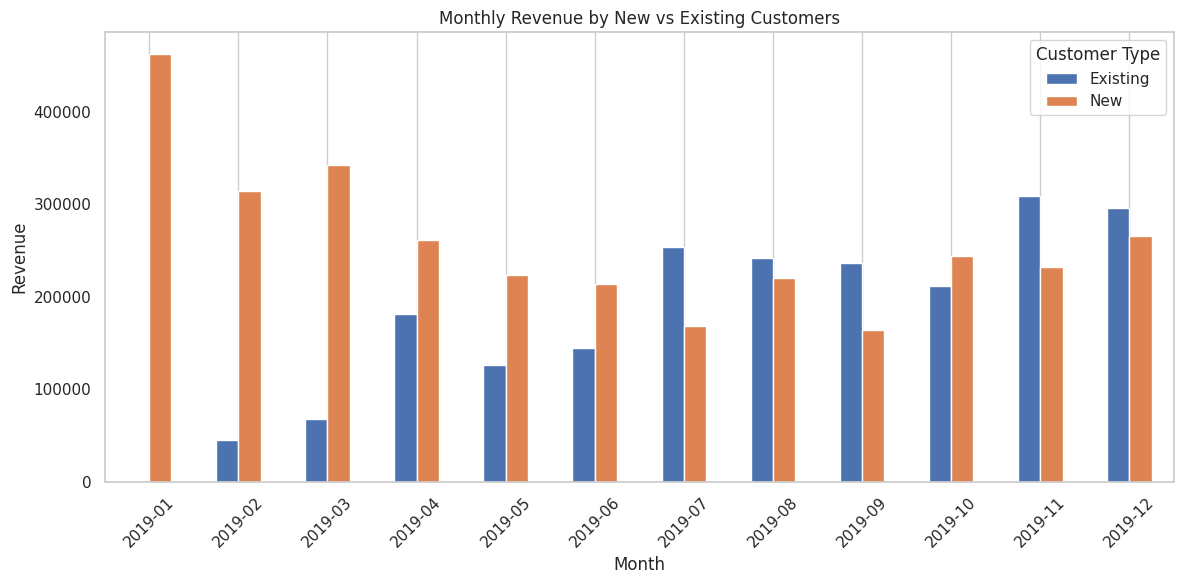

In [632]:
# Plotting
revenue_pivot.plot(kind='bar', figsize=(12, 6))
plt.title('Monthly Revenue by New vs Existing Customers')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.legend(title='Customer Type')
plt.tight_layout()
plt.show()

**Observations (from the above result):**

- Feb 2019 had a strong performance from both new and existing customers, indicating good retention and acquisition synergy.

- Jun 2019 shows a spike in new customer revenue, suggesting successful acquisition campaigns that month.

- May & July 2019 had only existing customer revenue, pointing to retained loyal customers but possibly weak acquisition.

- Apr & Mar had new customer contributions only, suggesting fresh acquisition but poor retention (no follow-up purchases).

**Suggested Actions (as per the above result and observation:**

- Balance Needed: A healthy business should show consistent revenue from both new and existing customers — this is crucial for sustainable growth.

- Improve Retention: Months like March/April/June with no returning customers need retention strategies (email campaigns, loyalty discounts).

- Boost Acquisition: Months like May/July with no new customers suggest acquisition stagnation — optimize marketing and onboarding channels.

Business Questions:

6. Analyze the relationship between coupon usage and revenue generation. How can discount strategies be optimized to maximize revenue while maintaining profitability?

So, here we need to check the Business Goals to understand the followings:

- Does applying coupons lead to higher revenue?

- Which product categories benefit most from coupons?

- How to bring a balance between discounts offered and profitability?

In [633]:
# Step 1: Converting sales['Transaction_Date] into datetime format
sales = pd.read_csv('/content/Online_Sales.csv')
sales['Transaction_Date'] = pd.to_datetime(sales['Transaction_Date'])

# Step 2: Computing Total Revenue
sales['Revenue'] = sales['Quantity'] * sales['Avg_Price'] + sales['Delivery_Charges']

sales['Coupon_Status'].unique()

array(['Used', 'Not Used', 'Clicked'], dtype=object)

In [634]:
# Step 3: Cleaning and standardizing Coupon_Status
sales['Coupon_Status'] = sales['Coupon_Status'].str.strip().str.title()  # Standardize case
print(sales['Coupon_Status'].value_counts())  # To see the value counts

# Step 4: Grouping revenue by coupon status
coupon_group = sales.groupby('Coupon_Status')['Revenue'].agg(['count', 'sum', 'mean']).reset_index()
coupon_group.columns = ['Coupon_Status', 'Num_Transactions', 'Total_Revenue', 'Avg_Revenue_per_Transaction']
print("coupon_group:")
coupon_group

Coupon_Status
Clicked     26926
Used        17904
Not Used     8094
Name: count, dtype: int64
coupon_group:


Coupon_Status  Num_Transactions  Total_Revenue  Avg_Revenue_per_Transaction
0       Clicked             26926     2662820.28                    98.894016
1      Not Used              8094      816306.71                   100.853312
2          Used             17904     1748302.70                    97.648721

In [635]:
# Step 5: Revenue by Product Category and Coupon_Status
category_coupon = sales.groupby(['Product_Category', 'Coupon_Status'])['Revenue'].sum().reset_index()
print("category_coupon:")
category_coupon.head(6)

category_coupon:


Product_Category Coupon_Status  Revenue
0      Accessories       Clicked  3818.27
1      Accessories      Not Used  2076.15
2      Accessories          Used  4188.73
3          Android       Clicked   565.74
4          Android      Not Used   234.80
5          Android          Used   277.18

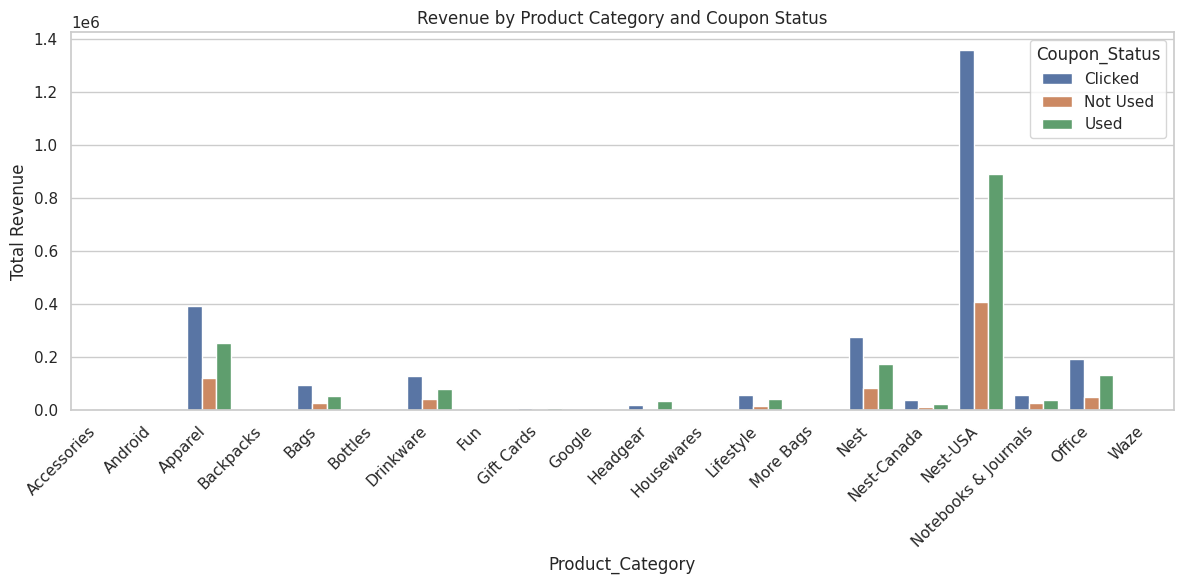

In [636]:
# Plotting category-wise impact
plt.figure(figsize=(12, 6))
sns.barplot(data=category_coupon, x='Product_Category', y='Revenue', hue='Coupon_Status')
plt.xticks(rotation=45, ha='right')
plt.title('Revenue by Product Category and Coupon Status')
plt.ylabel('Total Revenue')
plt.tight_layout()
plt.show()

**Facet Bar Plot** per Product Category

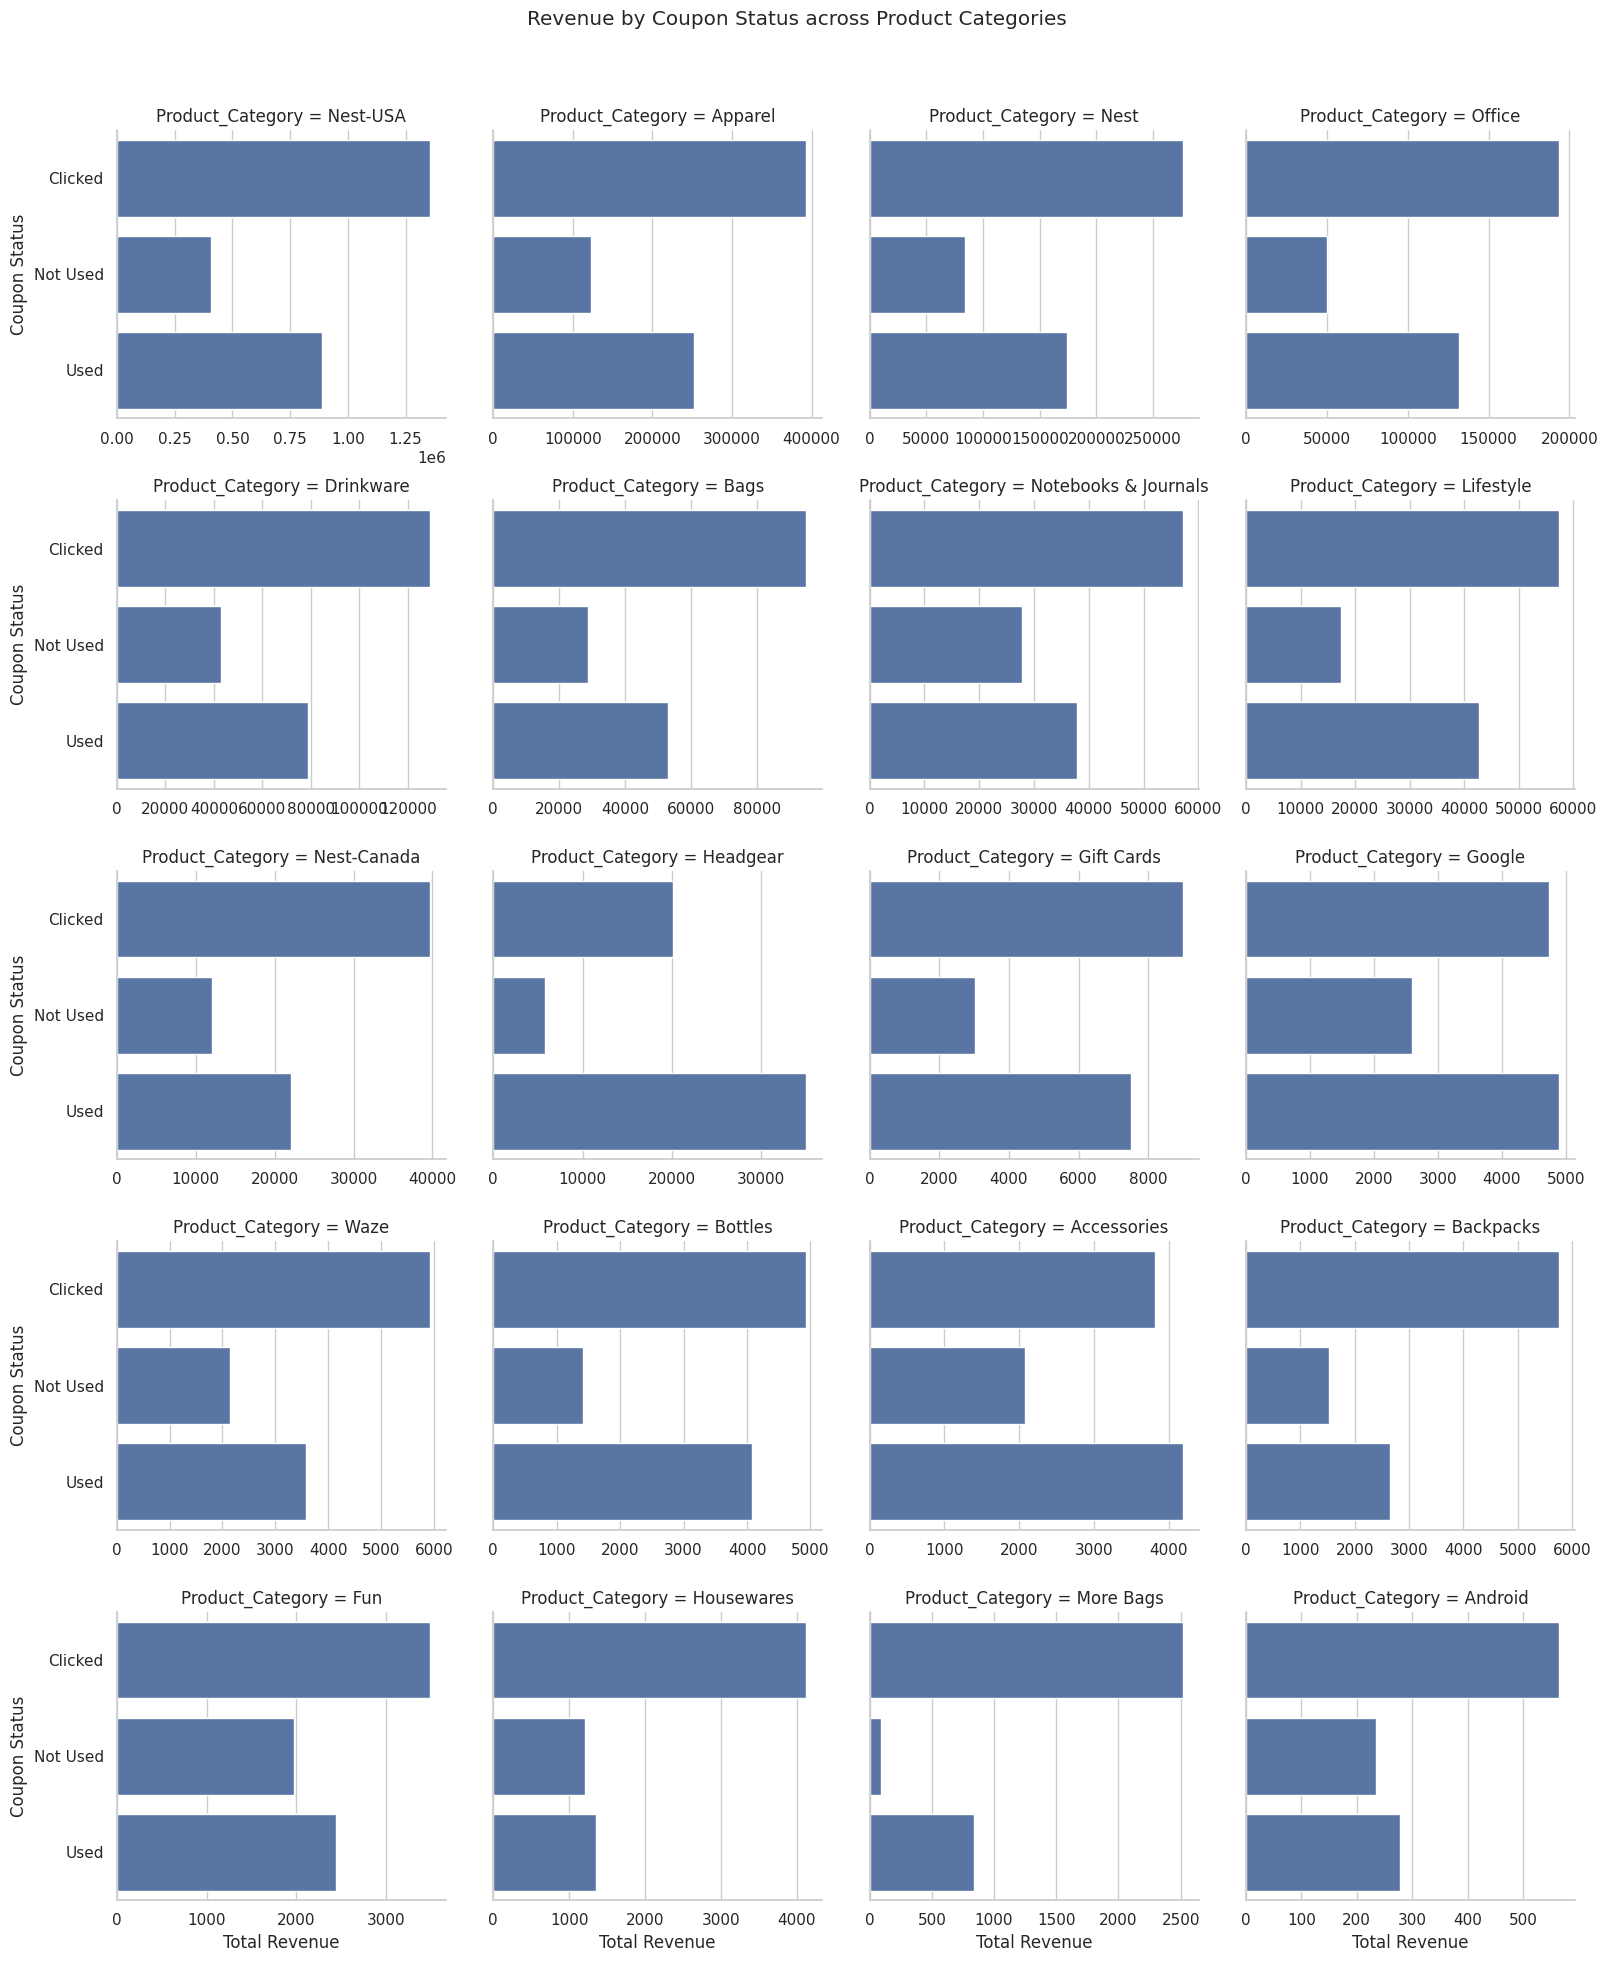

In [637]:
# Sorting categories by total revenue for consistent ordering
top_categories = category_coupon.groupby('Product_Category')['Revenue'].sum().sort_values(ascending=False).index
category_coupon['Product_Category'] = pd.Categorical(category_coupon['Product_Category'], categories=top_categories)

# Plotting with facet per category
g = sns.catplot(
    data=category_coupon,
    x='Revenue',
    y='Coupon_Status',
    col='Product_Category',
    kind='bar',
    col_wrap=4,
    height=4,
    aspect=1,
    sharex=False
)

g.fig.subplots_adjust(top=0.92)
g.fig.suptitle('Revenue by Coupon Status across Product Categories')
g.set_axis_labels("Total Revenue", "Coupon Status")

plt.show()

**Observations (from the above Facet plot):**

a. Coupons Drive Revenue in Many Categories:

- Categories like Apparel, Nest, Drinkware, and Gift Cards show significantly higher revenue from the "Used" coupon group.

- This indicates that discounts are effectively converting into purchases in these segments.

b. High 'Clicked' But Not 'Used' (Wasted Engagement):

- In categories like Nest-USA, Drinkware, and Nest, there’s noticeable revenue in the "Clicked" group.

- These are potential lost conversions — customers showed interest but didn’t redeem the coupon.

c. Minimal Coupon Influence in Some Categories:

- For Android, Housewares, and More Bags, total revenue is low across all coupon statuses.

- Suggests that either these products are niche, low-volume, or not responsive to discounts.

d. 'Not Used' Still Contributes Revenue in Several Segments:

- Categories like Office, Lifestyle, and Backpacks have decent revenue even without coupon usage.

- May indicate strong organic demand or a loyal customer base that purchases without discounts.

e. 'Used' Performs Best Overall:

- In most categories, the "Used" bar is the tallest, proving that discount usage generally correlates with higher revenue.

f. High Sensitivity Categories:

- Apparel, Bags, Accessories, and Notebooks & Journals show substantial uplift in revenue when coupons are used.

- These are strong candidates for targeted discount campaigns.


**Inferences:**

From the above results, we can infer the following points.

- Overall Revenue Comparison
From the coupon_group table:
    - We can directly compare average revenue per transaction when a coupon is used vs not used.
    - If average revenue with coupon 'Used' > coupon 'Not Used', then coupons may drive higher basket sizes or conversion.

- Category-Level Impact
The category_coupon bar plot is showing:
    - Which product categories benefit most from discounts.
    - It enables Business to decide where coupons are profitable vs wasteful.

**Coupon_Status- 'Used':**
- Our Insights driven- If this group shows higher revenue per transaction, then definitely coupons are effective.

**Coupon_Status- 'Clicked':**
- This indicates interest; so Business can consider retargeting this group of customers following the corresponding customer IDs.

**Coupon_Status- 'Not Used':**
This can be treated as a good baseline to compare natural revenue.

**Optimization of Discount Strategy:**

On the basis of the above results, we can derive the suggestions to Optimize Discount Strategy.

- Strategy: Target High-Converting Categories -

    - Reason: Use coupons only on categories showing higher revenue with coupons.

- Strategy: Limit Coupon Frequency -

    - Reason: Overuse may dilute brand value & margins; limit usage to select months.

- Strategy: Use Conditional Discounts -

    - Reason: "Get Rs. 100 off on Rs. 1000+" encourages larger carts without reducing the margin.

- Strategy: A/B Test Coupons -

    - Reason: Run experiments comparing different discount levels or formats.

- Strategy: Combine with Profit Margins -

    - Reason: Integrate with Tax_Amount.csv to assess net profit after GST and discount.

Business Questions:

7. Identify the top-performing products and analyze the factors driving their success. How can this insight inform inventory management and promotional strategies?

In [638]:
sales = pd.read_csv('/content/Online_Sales.csv')
customers = pd.read_csv('/content/Customers_Data.csv')

print(sales.columns)

# STEP 1: Aggregating Product-Level Performance
product_perf = sales.groupby('Product_Description').agg({
    'Quantity': 'sum',
    'Transaction_ID': 'count',
    'Coupon_Status': lambda x: (x == 'Used').sum(),
    'Avg_Price': 'mean'
}).reset_index()

# Compute Revenue = Quantity × Avg_Price (assumes avg price per row is accurate)
product_perf['Total_Revenue'] = product_perf['Quantity'] * product_perf['Avg_Price']

# Rename and calculate KPIs
product_perf.columns = ['Product_Name', 'Total_Units_Sold', 'Num_Orders', 'Coupon_Used_Count', 'Avg_Price', 'Total_Revenue']
product_perf['Avg_Units_per_Order'] = product_perf['Total_Units_Sold'] / product_perf['Num_Orders']
product_perf['Coupon_Usage_Rate'] = product_perf['Coupon_Used_Count'] / product_perf['Num_Orders']

# STEP 2: Top 10 Products by Revenue
top_products = product_perf.sort_values(by='Total_Revenue', ascending=False).head(10)
print("top_products (Based on Total_Revenue):")
top_products.head(10)

Index(['CustomerID', 'Transaction_ID', 'Transaction_Date', 'Product_SKU',
       'Product_Description', 'Product_Category', 'Quantity', 'Avg_Price',
       'Delivery_Charges', 'Coupon_Status'],
      dtype='object')
top_products (Based on Total_Revenue):


Product_Name  Total_Units_Sold  \
316  Nest Learning Thermostat 3rd Gen-USA - Stainle...              4570   
312             Nest Cam Outdoor Security Camera - USA              5206   
310              Nest Cam Indoor Security Camera - USA              4402   
321    Nest Protect Smoke + CO White Battery Alarm-USA              2683   
323      Nest Protect Smoke + CO White Wired Alarm-USA              2670   
317       Nest Learning Thermostat 3rd Gen-USA - White              1368   
324        Nest Secure Alarm System Starter Pack - USA               510   
307                                  Nest Cam IQ - USA               771   
326                            Nest Thermostat E - USA              1091   
315      Nest Learning Thermostat 3rd Gen-USA - Copper               472   

     Num_Orders  Coupon_Used_Count   Avg_Price  Total_Revenue  \
316        3511               1203  150.981874  689987.164682   
312        3328               1092  121.806541  634124.854874   
310        3230               1032  120.214594  529184.644669   
321        1361                460   79.838692  214207.211007   
323        1065                394   79.748254  212927.836901   
317        1089                383  149.644555  204713.750744   
324         498                162  351.287269  179156.507229   
307         599                209  199.916728  154135.797195   
326         844                264   99.674384  108744.752820   
315         393                137  149.556947   70590.878779   

     Avg_Units_per_Order  Coupon_Usage_Rate  
316             1.301623           0.342637  
312             1.564303           0.328125  
310             1.362848           0.319505  
321             1.971345           0.337987  
323             2.507042           0.369953  
317             1.256198           0.351699  
324             1.024096           0.325301  
307             1.287145           0.348915  
326             1.292654           0.312796  
315             1.201018           0.348601

<ipython-input-639-e8f7ba6f5518>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_products, x='Product_Name', y='Total_Revenue', palette='viridis')


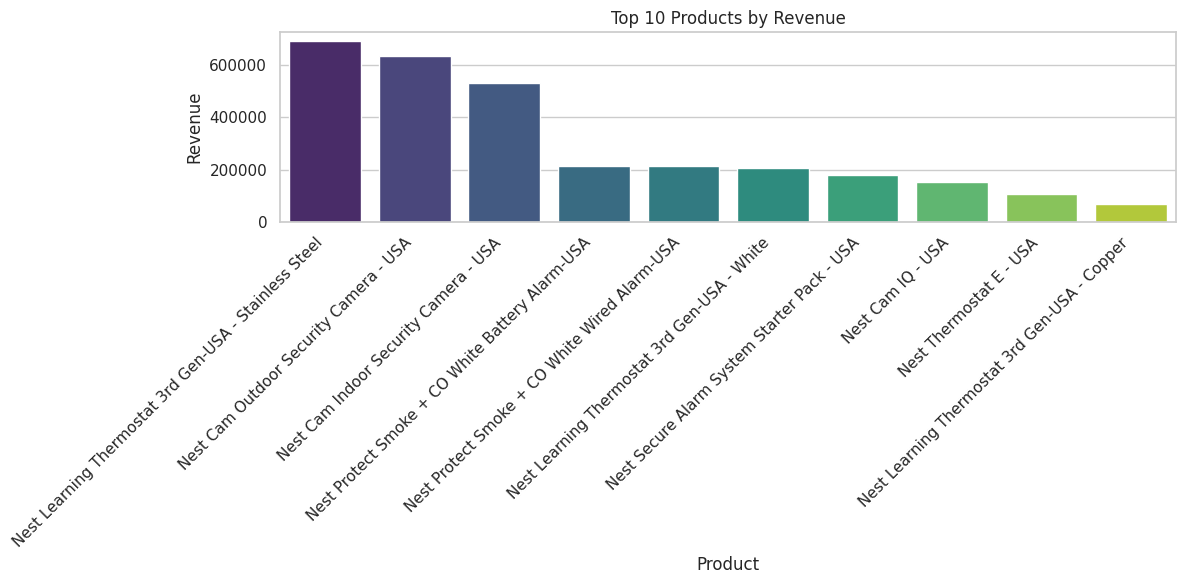

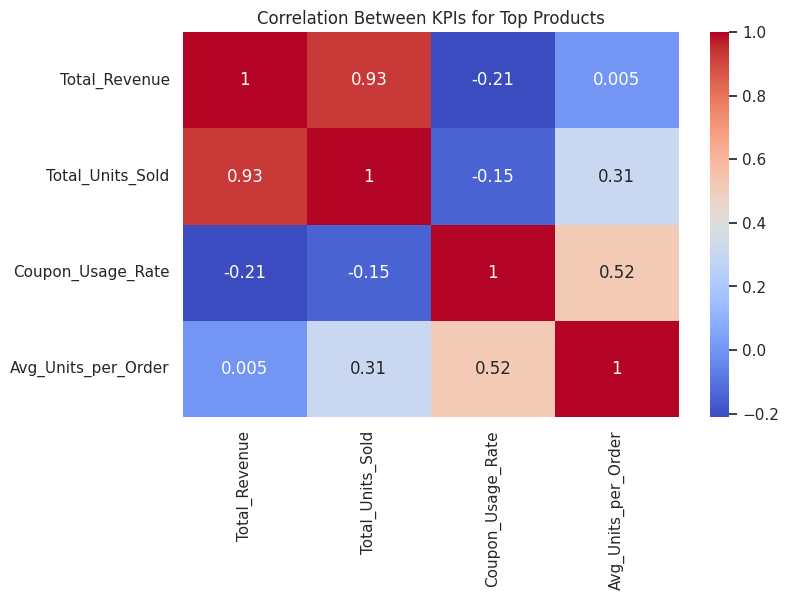

In [639]:
# STEP 3: Bar Plot of Top Products
plt.figure(figsize=(12,6))
sns.barplot(data=top_products, x='Product_Name', y='Total_Revenue', palette='viridis')
plt.title("Top 10 Products by Revenue")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Revenue")
plt.xlabel("Product")
plt.tight_layout()
plt.show()

# STEP 4: Correlation Heatmap of KPIs
corr = top_products[['Total_Revenue', 'Total_Units_Sold', 'Coupon_Usage_Rate', 'Avg_Units_per_Order']].corr()
plt.figure(figsize=(8,5))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Between KPIs for Top Products")
plt.show()

From the above results, we can cite the interpretation & insights as below:

a. Top Products by Revenue:
- These products are driving the highest total revenue.
- Business can now focus inventory and marketing resources on them.

b. Coupon Usage Patterns:
- The heatmap shows how revenue correlates with coupon usage and order behavior.
- For instance, if Coupon_Usage_Rate has a positive correlation with Total_Revenue, it indicates coupons are boosting sales.

c. Inventory & Promotions Strategy:
- We need to check and confirm stock availability for top-selling items (high Total_Units_Sold).
- Business need to consider offering selective coupons to boost underperforming but high-margin products.
- We need to monitor Avg_Units_per_Order to guide bundling or volume discount strategies.

Business Questions:

8. Analyze the relationship between monthly marketing spend and revenue. Are there any months where marketing efforts yielded disproportionately high or low returns? How can marketing strategies be adjusted to improve ROI?

So, here we need to accomplish the following tasks.
- Firstly we will compare monthly revenue (from Online_Sales.csv) with monthly marketing spend (from Marketing_Spend.csv).
- Then we need to compute ROI (Return on Investment) = Revenue / Marketing Spend.
- After that we will identify months with disproportionately high or low ROI.
- Finally we will suggest marketing adjustments based on analysis.

In [640]:
# Step 1: Loading the datasets
sales = pd.read_csv('/content/Online_Sales.csv')
marketing = pd.read_csv('/content/Marketing_Spend.csv')
print(marketing.columns)

Index(['Date', 'Offline_Spend', 'Online_Spend'], dtype='object')


In [641]:
# Step 2: Converting date columns to datetime
sales['Transaction_Date'] = pd.to_datetime(sales['Transaction_Date'])
marketing['Date'] = pd.to_datetime(marketing['Date'])

# Step 3: Creating 'Month' column in both datasets
sales['Month'] = sales['Transaction_Date'].dt.to_period('M').dt.to_timestamp()
marketing['Month'] = marketing['Date'].dt.to_period('M').dt.to_timestamp()

# Step 4: Computing Monthly Revenue
monthly_revenue = sales.groupby('Month')['Quantity'].sum().reset_index(name='Total_Quantity')
monthly_revenue['Avg_Price'] = sales.groupby('Month')['Avg_Price'].mean().values
monthly_revenue['Revenue'] = monthly_revenue['Total_Quantity'] * monthly_revenue['Avg_Price']

# Step 5: Summing total marketing spend (Online + Offline)
marketing['Marketing_Spend'] = marketing['Offline_Spend'] + marketing['Online_Spend']
monthly_marketing = marketing.groupby('Month')['Marketing_Spend'].sum().reset_index()

# Step 6: Merging monthly revenue and marketing spend
combined_df = pd.merge(monthly_revenue, monthly_marketing, on='Month', how='inner')

# Step 7: Calculating ROI
combined_df['ROI'] = combined_df['Revenue'] / combined_df['Marketing_Spend']

# Step 8: Displaying result table
combined_df[['Month', 'Revenue', 'Marketing_Spend', 'ROI']].head(6)

Month       Revenue  Marketing_Spend       ROI
0 2019-01-01  1.243767e+06        154928.95  8.027983
1 2019-02-01  8.813167e+05        137107.92  6.427905
2 2019-03-01  9.365695e+05        122250.09  7.661095
3 2019-04-01  1.078329e+06        157026.83  6.867161
4 2019-05-01  7.321760e+05        118259.64  6.191259
5 2019-06-01  9.554018e+05        134318.14  7.112976

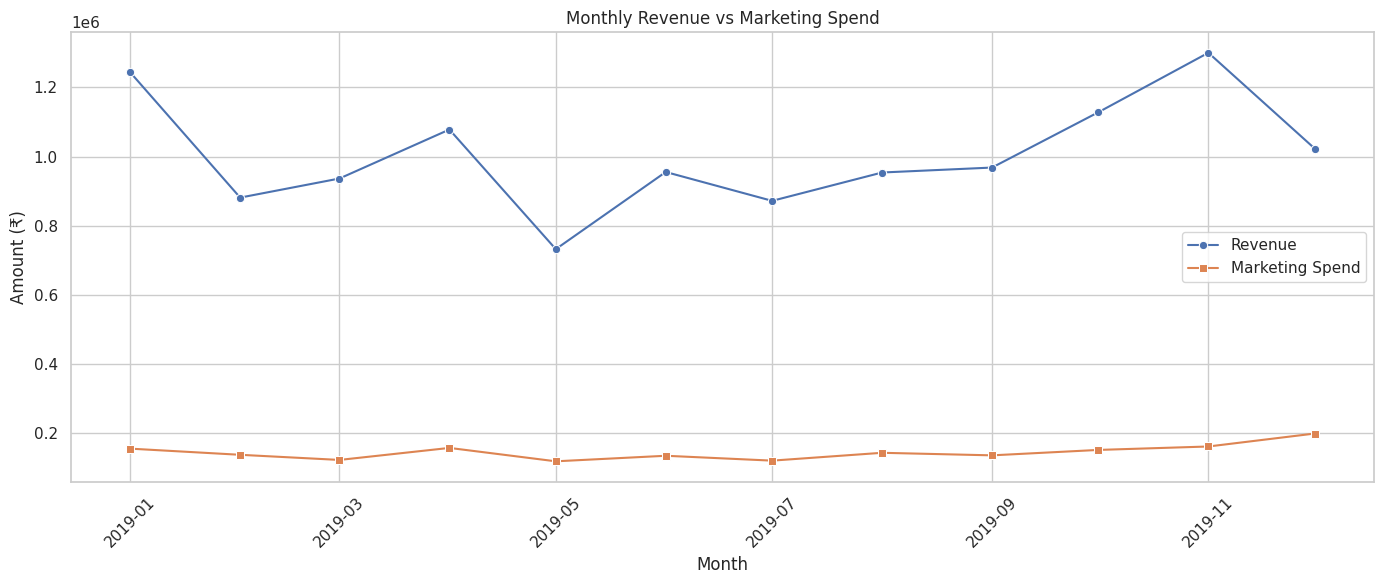

<ipython-input-642-9feb23b5df49>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=combined_df, x='Month', y='ROI', palette='coolwarm')


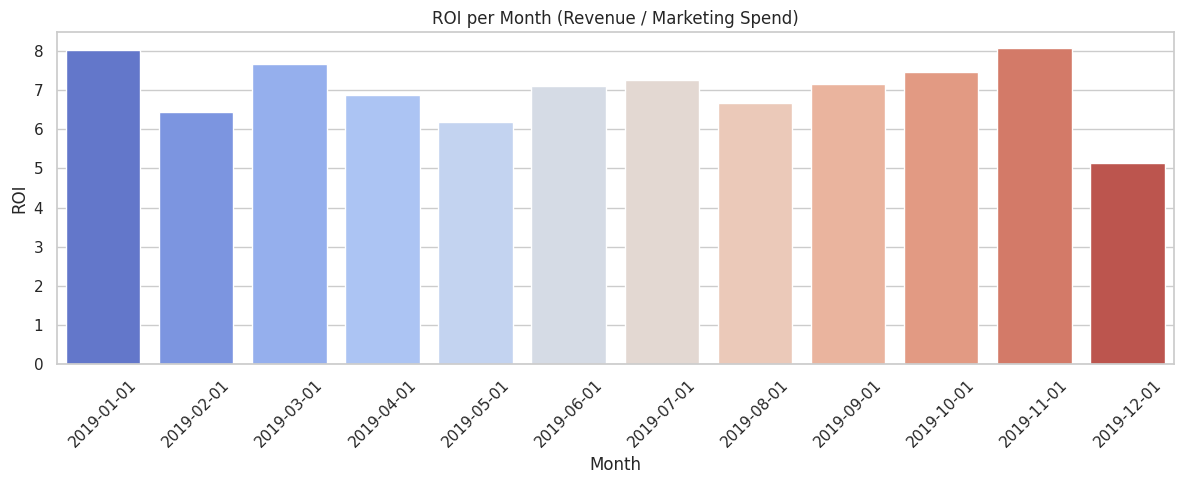

In [642]:
# Step 9: Plot Revenue vs Marketing Spend
plt.figure(figsize=(14,6))
sns.lineplot(data=combined_df, x='Month', y='Revenue', label='Revenue', marker='o')
sns.lineplot(data=combined_df, x='Month', y='Marketing_Spend', label='Marketing Spend', marker='s')
plt.title('Monthly Revenue vs Marketing Spend')
plt.ylabel('Amount (₹)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 10: ROI Trend Plot
plt.figure(figsize=(12,5))
sns.barplot(data=combined_df, x='Month', y='ROI', palette='coolwarm')
plt.title('ROI per Month (Revenue / Marketing Spend)')
plt.ylabel('ROI')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Based on the above plot, we can infer the following points.

**Revenue vs. Marketing Spend (Observations)-**

a. Revenue significantly exceeds marketing spend every month — this is a good indicator of profitable operations.

b. Highest revenue spike occurs in November 2019, showing a strong sales season — possibly due to holiday campaigns or year-end promotions.

b. Lowest revenue is seen in May 2019, despite relatively consistent marketing spend — suggests weak conversion.

c. Marketing spend remains relatively stable throughout the year, increasing slightly in November–December.

d. There's no direct 1-to-1 correlation between spikes in marketing spend and revenue — indicating other factors (like seasonality or product demand) may be more dominant.

**ROI Insights:**

$ROI = Revenue / Marketing Spend$

- High ROI Months: January, March, July — moderate marketing spend but solid revenue.
- Low ROI Month: May — marketing spend wasn’t low, but revenue was significantly lower, suggesting inefficiency.
- November and December show increased marketing spend and revenue, but whether ROI is optimal depends on exact spend vs return (likely high due to volume).

**Optimization Suggestions (as per the observations):**

a. Analyze May’s Drop:

- Investigate if there were product issues, logistics problems, or poor campaign targeting.
- We need to avoid repeating ineffective strategies used that month.

b. Capitalize on High ROI Months:
- Businnes should expand successful campaign strategies from January, March, July to similar months.
- Business should identify products/coupons that performed well in those months.

c. Seasonal Promotions:
- We need to plan major campaigns ahead of high-return months like November (festive season).
- Consider doubling down marketing spend in October–November, where spend seems to align well with revenue.

d. Dynamic Budgeting:
- Instead of even monthly distribution, allocate marketing budget based on ROI trends.
-We should use forecasting to predict which months are likely to yield higher returns.

e. Channel Performance:
- Separate online vs. offline effectiveness — track their individual ROI if possible.
- We need to optimize underperforming channels or shift more spend to the better-performing one.

Business Questions:

9. Evaluate the effectiveness of marketing campaigns by comparing marketing spend to revenue generated. Are there opportunities to reallocate resources for better results?

Here, we need to perform the following tasks.
- We will compare monthly marketing spend (online + offline) vs monthly revenue.
- We will calculate ROI (Revenue ÷ Total Spend).
- Next we will identify underperforming vs overperforming months.
- Then we can recommend resource reallocation strategies.

In [643]:
# Step 1: Converting date columns to datetime
sales['Transaction_Date'] = pd.to_datetime(sales['Transaction_Date'])
marketing['Date'] = pd.to_datetime(marketing['Date'])

# Step 2: Extracting 'Month' from both datasets
sales['Month'] = sales['Transaction_Date'].dt.to_period('M').dt.to_timestamp()
marketing['Month'] = marketing['Date'].dt.to_period('M').dt.to_timestamp()

# Step 3: Aggregating monthly revenue from sales data
monthly_sales = sales.groupby('Month').agg({
    'Quantity': 'sum',
    'Avg_Price': 'mean'
}).reset_index()
monthly_sales['Revenue'] = monthly_sales['Quantity'] * monthly_sales['Avg_Price']

# Step 4: Aggregating monthly marketing spend
marketing['Total_Spend'] = marketing['Online_Spend'] + marketing['Offline_Spend']
monthly_marketing = marketing.groupby('Month')['Total_Spend'].sum().reset_index()
print("monthly_marketing:")
monthly_marketing.head(6)

monthly_marketing:


Month  Total_Spend
0 2019-01-01    154928.95
1 2019-02-01    137107.92
2 2019-03-01    122250.09
3 2019-04-01    157026.83
4 2019-05-01    118259.64
5 2019-06-01    134318.14

In [644]:
# Step 5: Merging both datasets
combined = pd.merge(monthly_sales[['Month', 'Revenue']], monthly_marketing, on='Month', how='inner')

# Step 6: Calculating ROI
combined['ROI'] = combined['Revenue'] / combined['Total_Spend']

# Displaying the table
print("combined:")
combined.head(6)

combined:


Month       Revenue  Total_Spend       ROI
0 2019-01-01  1.243767e+06    154928.95  8.027983
1 2019-02-01  8.813167e+05    137107.92  6.427905
2 2019-03-01  9.365695e+05    122250.09  7.661095
3 2019-04-01  1.078329e+06    157026.83  6.867161
4 2019-05-01  7.321760e+05    118259.64  6.191259
5 2019-06-01  9.554018e+05    134318.14  7.112976

<ipython-input-645-6eca494133ed>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=combined, x='Month', y='ROI', palette='rocket')


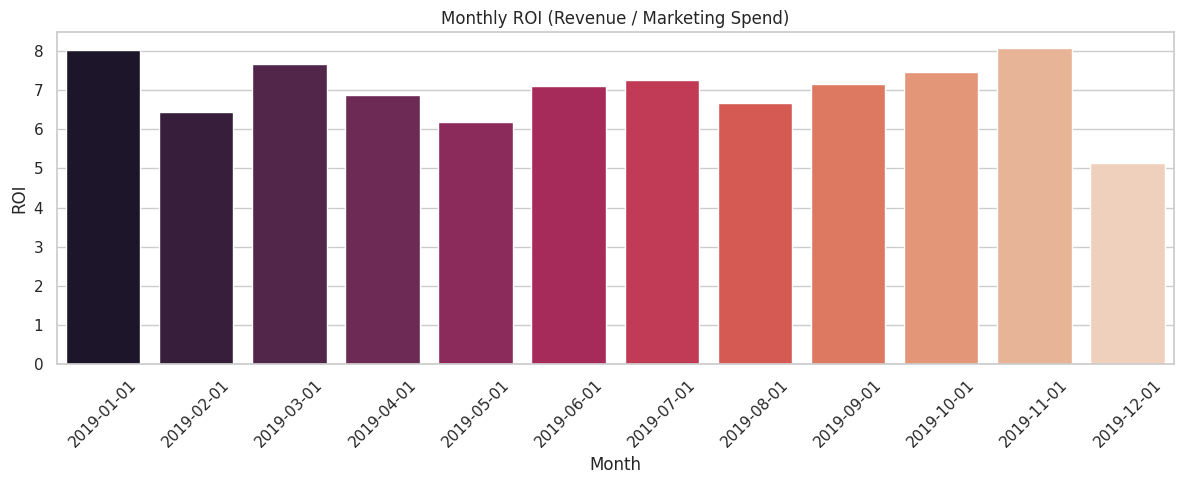

Low ROI Months (Potential Reallocation Targets):


Month       Revenue  Total_Spend       ROI
1  2019-02-01  8.813167e+05    137107.92  6.427905
3  2019-04-01  1.078329e+06    157026.83  6.867161
4  2019-05-01  7.321760e+05    118259.64  6.191259
7  2019-08-01  9.539481e+05    142904.15  6.675440
11 2019-12-01  1.023034e+06    198648.75  5.149962

In [645]:
# Step 7: Visualizing ROI per Month
plt.figure(figsize=(12, 5))
sns.barplot(data=combined, x='Month', y='ROI', palette='rocket')
plt.title('Monthly ROI (Revenue / Marketing Spend)')
plt.xticks(rotation=45)
plt.ylabel('ROI')
plt.tight_layout()
plt.show()

# Step 8: Highlighting low ROI months
low_roi_months = combined[combined['ROI'] < combined['ROI'].mean()]
print("Low ROI Months (Potential Reallocation Targets):")
low_roi_months[['Month', 'Revenue', 'Total_Spend', 'ROI']].head(6)

Based on the above barplot, we need to infer the following.

**ROI Analysis:**

- High ROI months indicate efficient marketing campaigns (high returns from relatively low spend).
- Low ROI months suggest inefficient spend — revenue generated is not justifying the investment.

**Opportunities for Reallocation:**

a. Reallocate spend away from low-ROI months:
- Like here. if May or August have low ROI, reduce their spend and invest more in months like November (high revenue periods).

b. Invest in proven high-yield periods:
- Months like January, November, or December may be revenue-rich — amplify successful strategies there.

c. Seasonal Product Promotions:
- We need to align promotions and marketing spend with seasonal spikes in product sales.

d. A/B testing strategies in low-performing months:
- We can execute the experiment with ad creatives, platforms (online vs offline), or target segments.

e. Channel Effectiveness:
- If dataset supports it, evaluate Online vs Offline separately to see which gives better returns.

**Product-wise ROI Linked to Campaigns:**

We can Compare marketing campaign effectiveness at the product level using:
- Revenue generated per product
- Associated marketing spend (either allocated equally or based on assumptions if not available product-wise)
- Compute Product-wise $ROI = Revenue / Estimated Marketing Spend$

**Assumptions:**

- Since the marketing spend dataset does not specify product-level allocations, we assume:

- Equal allocation of monthly spend across all products sold in that month.

- This is a reasonable approximation when exact targeting info isn’t available.

**Top 10 Products by ROI:**

- In the below code cell we will show top 10 products by ROI.

In [646]:
# Step 1: Preparing necessary columns
sales['Transaction_Date'] = pd.to_datetime(sales['Transaction_Date'])
sales['Month'] = sales['Transaction_Date'].dt.to_period('M').dt.to_timestamp()
marketing['Date'] = pd.to_datetime(marketing['Date'])
marketing['Month'] = marketing['Date'].dt.to_period('M').dt.to_timestamp()
marketing['Total_Spend'] = marketing['Online_Spend'] + marketing['Offline_Spend']

# Step 2: Aggregating marketing spend per month
monthly_spend = marketing.groupby('Month')['Total_Spend'].sum().reset_index()

# Step 3: Computing product-level revenue per month
product_monthly = sales.groupby(['Month', 'Product_Description']).agg({
    'Quantity': 'sum',
    'Avg_Price': 'mean'
}).reset_index()
product_monthly['Revenue'] = product_monthly['Quantity'] * product_monthly['Avg_Price']

# Step 4: Merging monthly marketing spend
product_monthly = pd.merge(product_monthly, monthly_spend, on='Month', how='left')

# Step 5: Estimating product share of monthly spend (equal allocation method)
# First, counting how many distinct products were sold each month
monthly_product_counts = product_monthly.groupby('Month')['Product_Description'].nunique().reset_index()
monthly_product_counts.columns = ['Month', 'Num_Products']

# Merging number of products into product_monthly
product_monthly = pd.merge(product_monthly, monthly_product_counts, on='Month', how='left')

# Estimating product-level marketing spend
product_monthly['Estimated_Product_Spend'] = product_monthly['Total_Spend'] / product_monthly['Num_Products']

# Step 6: Computing Product-level ROI
product_monthly['Product_ROI'] = product_monthly['Revenue'] / product_monthly['Estimated_Product_Spend']

# Step 7: Soring and display top and bottom products by ROI
top_products = product_monthly.sort_values(by='Product_ROI', ascending=False).head(10)
low_products = product_monthly.sort_values(by='Product_ROI', ascending=True).head(10)

print("Top 10 Products by ROI:")
top_products[['Month', 'Product_Description', 'Revenue', 'Estimated_Product_Spend', 'Product_ROI']].head(10)

Top 10 Products by ROI:


Month                                Product_Description  \
227  2019-01-01  Nest Learning Thermostat 3rd Gen-USA - Stainle...   
834  2019-03-01  Nest Learning Thermostat 3rd Gen-USA - Stainle...   
832  2019-03-01             Nest Cam Outdoor Security Camera - USA   
521  2019-02-01  Nest Learning Thermostat 3rd Gen-USA - Stainle...   
830  2019-03-01              Nest Cam Indoor Security Camera - USA   
225  2019-01-01             Nest Cam Outdoor Security Camera - USA   
1993 2019-07-01             Nest Cam Outdoor Security Camera - USA   
519  2019-02-01             Nest Cam Outdoor Security Camera - USA   
223  2019-01-01              Nest Cam Indoor Security Camera - USA   
1725 2019-06-01             Nest Cam Outdoor Security Camera - USA   

            Revenue  Estimated_Product_Spend  Product_ROI  
227   115896.919795               530.578596   218.434970  
834    62878.000000               384.434245   163.559831  
832    60350.696203               384.434245   156.985744  
521    68275.968372               463.202432   147.399849  
830    49471.983607               384.434245   128.687764  
225    66258.358687               530.578596   124.879441  
1993   54621.000000               453.652264   120.402794  
519    55721.895307               463.202432   120.297070  
223    63431.413085               530.578596   119.551398  
1725   54865.170068               481.427025   113.963627

In [647]:
print("\nBottom 10 Products by ROI:")
low_products[['Month', 'Product_Description', 'Revenue', 'Estimated_Product_Spend', 'Product_ROI']].head(10)


Bottom 10 Products by ROI:


Month                                Product_Description  Revenue  \
2681 2019-11-01                                7&quot; Dog Frisbee     1.20   
2519 2019-10-01                                 Ballpoint Pen Blue     0.99   
2798 2019-11-01                    Waze Mood Original Window Decal     1.59   
2732 2019-11-01                             Google Pet Feeding Mat     2.10   
2241 2019-08-01                                 Rainbow Stylus Pen     1.20   
2658 2019-10-01                       Waze Mood Happy Window Decal     1.59   
2932 2019-12-01  YouTube Women's Short Sleeve Tri-blend Badge T...     3.87   
2796 2019-11-01                       Waze Mood Happy Window Decal     3.18   
2809 2019-11-01          YouTube Men's Short Sleeve Hero Tee Black     3.40   
2851 2019-12-01              Google Men's Long & Lean Tee Charcoal     4.89   

      Estimated_Product_Spend  Product_ROI  
2681              1184.889412     0.001013  
2519               783.547409     0.001263  
2798              1184.889412     0.001342  
2732              1184.889412     0.001772  
2241               605.526059     0.001982  
2658               783.547409     0.002029  
2932              1697.852564     0.002279  
2796              1184.889412     0.002684  
2809              1184.889412     0.002869  
2851              1697.852564     0.002880

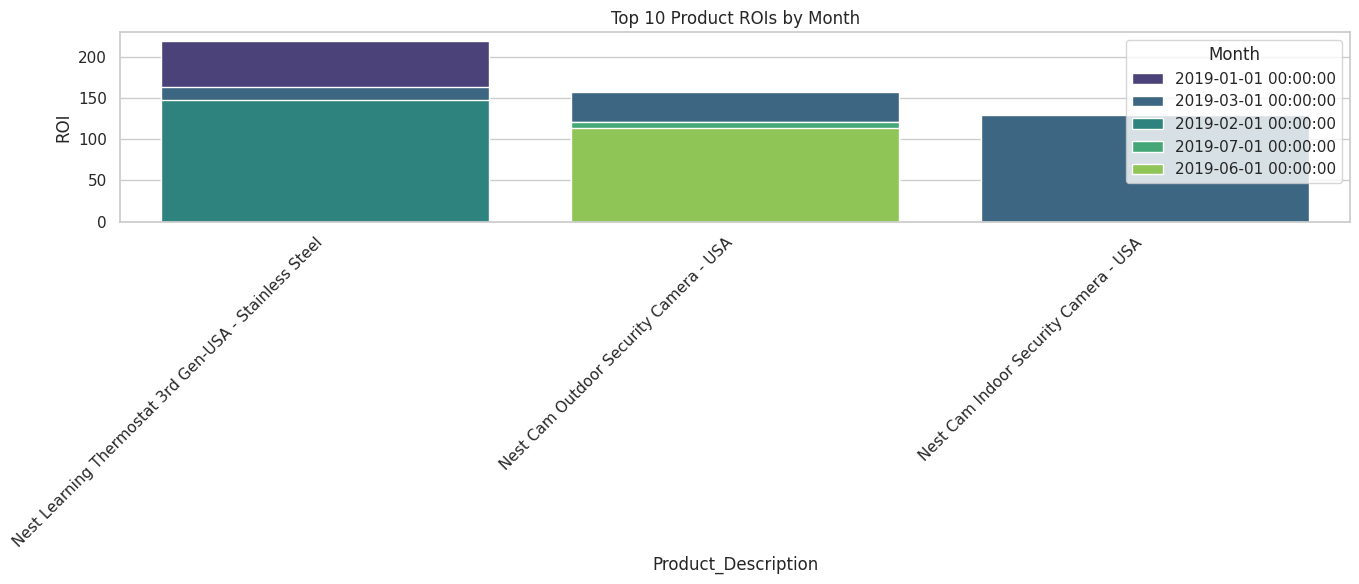

In [648]:
plt.figure(figsize=(14, 6))
sns.barplot(data=top_products, x='Product_Description', y='Product_ROI', hue='Month', dodge=False, palette='viridis')
plt.title('Top 10 Product ROIs by Month')
plt.xticks(rotation=45, ha='right')
plt.ylabel('ROI')
plt.tight_layout()

In the above plot,

- X-axis: Product descriptions (top 3 shown, like, Nest Learning Thermostat, Nest Cam Outdoor/Indoor).
- Y-axis: ROI (Return on Investment) — calculated as Revenue / Estimated Marketing Spend.
- Color-coded bars: Each color represents a different month, stacked on each product to reflect ROI in that month.

**Insights:**

Nest Learning Thermostat 3rd Gen – USA:

    a. Achieved the highest ROI overall across multiple months.
    b. Particularly strong performance in January and February, suggesting efficient marketing and strong customer demand.

Nest Cam Outdoor Security Camera – USA:

    a. Consistent ROI across multiple months (e.g., June, March, July), but slightly lower than the thermostat.
    b. This indicates steady performance, making it a good candidate for sustained investment.

Nest Cam Indoor Security Camera – USA:

    a. ROI is visible only for March, with a lower overall ROI compared to others.
    b. May indicate limited marketing activity or underperformance during other months.

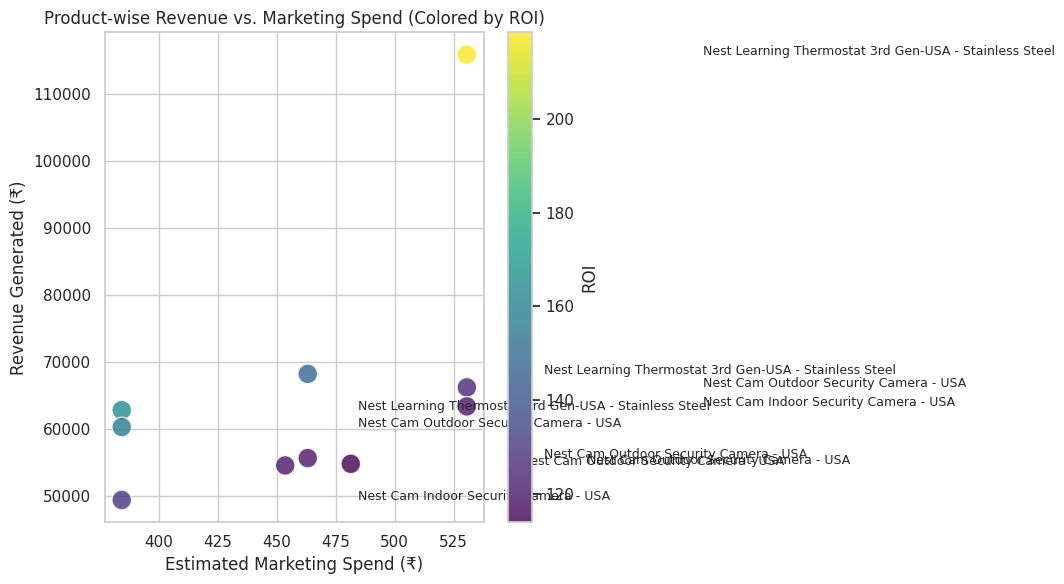

In [649]:
plt.figure(figsize=(12, 6))
scatter = plt.scatter(
    data=top_products,
    x='Estimated_Product_Spend',
    y='Revenue',
    c='Product_ROI',
    cmap='viridis',
    s=200,  # size of markers
    alpha=0.8,
    edgecolors='w'
)

# Annotating product names
for i, row in top_products.iterrows():
    plt.text(row['Estimated_Product_Spend'] + 100, row['Revenue'], row['Product_Description'], fontsize=9)

# Colorbar legend
cbar = plt.colorbar(scatter)
cbar.set_label('ROI')

plt.xlabel('Estimated Marketing Spend (₹)')
plt.ylabel('Revenue Generated (₹)')
plt.title('Product-wise Revenue vs. Marketing Spend (Colored by ROI)')
plt.grid(True)
plt.tight_layout()
plt.show()

In the above scatter plot,

- Top-right corner: High spend, high revenue — check ROI for profitability.
- Top-left: Low spend, high revenue — these are gold mines!
- Bottom-right: High spend, low revenue — likely inefficient campaigns.
- Color: Darker shades (green/yellow) mean higher ROI → efficient returns.

Business Questions:

10. Segment customers into groups such as Premium, Gold, Silver, and Standard. What targeted strategies can be developed for each segment to improve retention and revenue? (Use RFM segmentation techniques)

Our approach:

Customer Segmentation using RFM (Recency, Frequency, Monetary) — In this task, we will use the sales dataset and apply the RFM model to segment customers into Premium, Gold, Silver, and Standard categories.

In [650]:
# Step 1: Loading and preprocessing sales data (to convert sales Transaction_Date into datetime format)
sales['Transaction_Date'] = pd.to_datetime(sales['Transaction_Date'])

# Step 2: Defining the variable 'snapshot_date' for Recency (latest transaction date + 1 day)
snapshot_date = sales['Transaction_Date'].max() + pd.Timedelta(days=1)

# Step 3: Calculating RFM metrics
rfm = sales.groupby('CustomerID').agg({
    'Transaction_Date': lambda x: (snapshot_date - x.max()).days,  # Recency
    'Transaction_ID': 'nunique',                                   # Frequency
    'Avg_Price': lambda x: x.sum()                                 # Monetary (can also multiply Quantity * Price)
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Step 4: RFM Score (1 to 4)
rfm['R_Score'] = pd.qcut(rfm['Recency'], q=4, labels=[4, 3, 2, 1]).astype(int)
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), q=4, labels=[1, 2, 3, 4]).astype(int)
rfm['M_Score'] = pd.qcut(rfm['Monetary'], q=4, labels=[1, 2, 3, 4]).astype(int)

# Step 5: Combining scores to compute RFM Score
rfm['RFM_Score'] = rfm['R_Score'] + rfm['F_Score'] + rfm['M_Score']
rfm

CustomerID  Recency  Frequency  Monetary  R_Score  F_Score  M_Score  \
0          12346      108          1     25.49        3        1        1   
1          12347       60         31   3746.16        3        4        4   
2          12348       74          8    336.52        3        2        1   
3          12350       18         11   1312.40        4        2        3   
4          12356      108         13   1244.83        3        3        3   
...          ...      ...        ...       ...      ...      ...      ...   
1463       18259      271          3     84.73        1        1        1   
1464       18260       88         19   1114.89        3        3        3   
1465       18269      195          2     89.34        2        1        1   
1466       18277       70          1    149.00        3        1        1   
1467       18283       83         53   5658.00        3        4        4   

      RFM_Score  
0             5  
1            11  
2             6  
3             9  
4             9  
...         ...  
1463          3  
1464          9  
1465          4  
1466          5  
1467         11  

[1468 rows x 8 columns]

In [651]:
# Step 6: Segmenting customers
def segment_customer(score):
    if score >= 10:
        return 'Premium'
    elif score >= 7:
        return 'Gold'
    elif score >= 5:
        return 'Silver'
    else:
        return 'Standard'

rfm['Segment'] = rfm['RFM_Score'].apply(segment_customer)

# Step 7: Summary
segment_summary = rfm['Segment'].value_counts().reset_index()
segment_summary.columns = ['Segment', 'Number_of_Customers']
print("segment_summary:")
segment_summary.head()

segment_summary:


Segment  Number_of_Customers
0      Gold                  486
1   Premium                  411
2    Silver                  328
3  Standard                  243

<ipython-input-652-f9470cd2670c>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rfm, x='Segment', order=['Premium', 'Gold', 'Silver', 'Standard'], palette='Set2')


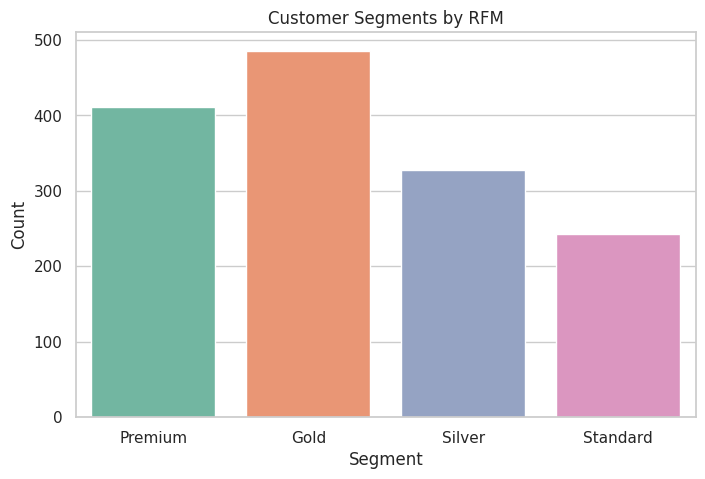

In [652]:
# Visualization
plt.figure(figsize=(8, 5))
sns.countplot(data=rfm, x='Segment', order=['Premium', 'Gold', 'Silver', 'Standard'], palette='Set2')
plt.title('Customer Segments by RFM')
plt.ylabel("Count")
plt.show()

Depending upon the above RFM scores and plot, we can infer the following strategies.

Segment- **Premium**
Characteristics- Low recency, high frequency & monetary
Strategy- Loyalty programs, We can give early access to new launches and personalized offers.

Segment- **Gold**

Characteristics- Moderate recency and spending
Strategy- We can provide exclusive discounts, retention rewards, membership upgrades.

Segment- **Silver**

Characteristics- Moderate frequency and monetary value
Strategy- Email campaigns, coupons, bundles to encourage repeat purchase

Segment- **Standard**
Characteristics- High recency (inactive) and low spending

Strategy- Win-back campaigns, feedback collection, deep discount intro offers

Business Questions:

11. Analyze the revenue contribution of each customer segment. How can the company focus its efforts on high-value segments while nurturing lower-value segments?

To solve this, we need to analyze how much revenue each customer segment (from RFM segmentation: Premium, Gold, Silver, Standard) contributes to the total revenue.

Then, we will recommend strategies for focusing on high-value segments and nurturing low-value segments.

In [653]:
# Step 1: Merging RFM segment info back into original sales data
sales['Transaction_Date'] = pd.to_datetime(sales['Transaction_Date'])  # converting to datetime type
sales_with_segment = pd.merge(sales, rfm[['CustomerID', 'Segment']], on='CustomerID', how='left')

# Step 2: Calculating revenue per row
sales_with_segment['Revenue'] = sales_with_segment['Quantity'] * sales_with_segment['Avg_Price']

# Step 3: Aggregating revenue by Segment
segment_revenue = sales_with_segment.groupby('Segment')['Revenue'].sum().reset_index()

# Step 4: Calculating share of total revenue
total_revenue = segment_revenue['Revenue'].sum()
segment_revenue['Revenue_Percent'] = 100 * segment_revenue['Revenue'] / total_revenue

# Step 5: Sorting segments for readability
segment_revenue = segment_revenue.sort_values(by='Revenue', ascending=False)

# Step 6: Displaying result
print("segment_revenue:")
segment_revenue.head()

segment_revenue:


Segment     Revenue  Revenue_Percent
1   Premium  3013703.12        64.522279
0      Gold  1287799.61        27.571317
2    Silver   280256.77         6.000195
3  Standard    89035.12         1.906209

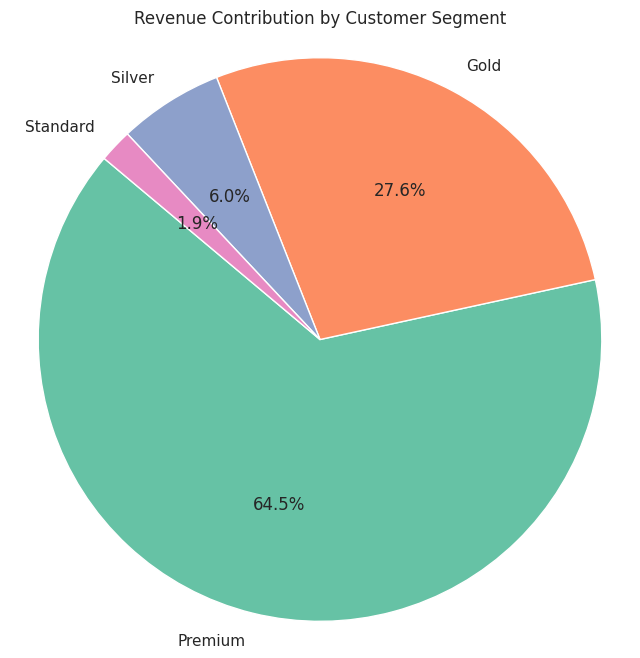

In [654]:
# Step 7: Visualization - Pie Chart
plt.figure(figsize=(8, 8))
colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3']
plt.pie(segment_revenue['Revenue'], labels=segment_revenue['Segment'], autopct='%1.1f%%', colors=colors, startangle=140)
plt.title('Revenue Contribution by Customer Segment')
plt.axis('equal')
plt.show()

High-Value Segments: **Premium & Gold**

Contribution: Together they generate **~80% of revenue**.

Strategy:
- Prioritize these customers with exclusive perks, early access, and personalized services.
- Implement loyalty programs, subscription bundles, or premium upgrades.
- Use predictive analytics to prevent churn.

Mid- to Low-Value Segments: **Silver & Standard**

Contribution: **Only ~17.5% of total revenue.**

Strategy:
- Use educational content (emails, tutorials) to push product value.
- Offer discounts, first-time buyer deals, or cross-sell promotions.
- Identify promising Silver customers who can be upgraded to Gold via targeted incentives.

Business Questions:

12. Group customers by their month of first purchase and analyze retention rates over time. Which cohorts exhibit the highest and lowest retention rates? What strategies can be implemented to improve retention for weaker cohorts?

In this section, we will perform a cohort analysis:
- We need to group customers by their first purchase month.
- Then we need to track how many customers from each cohort made repeat purchases in subsequent months.
- We will calculate retention rates.
- Then we will be able to identify strong vs weak cohorts.
- Finally we will suggest retention improvement strategies for underperforming groups.

In [655]:
# Step 1: Ensure Transaction Date is in datetime format
sales['Transaction_Date'] = pd.to_datetime(sales['Transaction_Date'])

# Step 2: Create 'CohortMonth' and 'OrderMonth'
sales['OrderMonth'] = sales['Transaction_Date'].dt.to_period('M').dt.to_timestamp()
first_purchase = sales.groupby('CustomerID')['OrderMonth'].min().reset_index()
first_purchase.head()

CustomerID OrderMonth
0       12346 2019-09-01
1       12347 2019-03-01
2       12348 2019-06-01
3       12350 2019-12-01
4       12356 2019-09-01

In [656]:
first_purchase.columns = ['CustomerID', 'CohortMonth']
first_purchase.head()

CustomerID CohortMonth
0       12346  2019-09-01
1       12347  2019-03-01
2       12348  2019-06-01
3       12350  2019-12-01
4       12356  2019-09-01

In [657]:
# Step 3: Merging CohortMonth into main data
sales = pd.merge(sales, first_purchase, on='CustomerID')
sales.head()

CustomerID  Transaction_ID Transaction_Date     Product_SKU  \
0       17850           16679       2019-01-01  GGOENEBJ079499   
1       17850           16680       2019-01-01  GGOENEBJ079499   
2       17850           16681       2019-01-01  GGOEGFKQ020399   
3       17850           16682       2019-01-01  GGOEGAAB010516   
4       17850           16682       2019-01-01  GGOEGBJL013999   

                                 Product_Description Product_Category  \
0  Nest Learning Thermostat 3rd Gen-USA - Stainle...         Nest-USA   
1  Nest Learning Thermostat 3rd Gen-USA - Stainle...         Nest-USA   
2              Google Laptop and Cell Phone Stickers           Office   
3  Google Men's 100% Cotton Short Sleeve Hero Tee...          Apparel   
4                    Google Canvas Tote Natural/Navy             Bags   

   Quantity  Avg_Price  Delivery_Charges Coupon_Status      Month OrderMonth  \
0         1     153.71               6.5          Used 2019-01-01 2019-01-01   
1         1     153.71               6.5          Used 2019-01-01 2019-01-01   
2         1       2.05               6.5          Used 2019-01-01 2019-01-01   
3         5      17.53               6.5      Not Used 2019-01-01 2019-01-01   
4         1      16.50               6.5          Used 2019-01-01 2019-01-01   

  CohortMonth  
0  2019-01-01  
1  2019-01-01  
2  2019-01-01  
3  2019-01-01  
4  2019-01-01

In [658]:
# Step 4: Calculating Cohort Index (months since first purchase)
def get_cohort_index(df):
    return (df['OrderMonth'].dt.year - df['CohortMonth'].dt.year) * 12 + (df['OrderMonth'].dt.month - df['CohortMonth'].dt.month) + 1

sales['CohortIndex'] = get_cohort_index(sales)
sales['CohortIndex'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int32)

In [659]:
# Step 5: Building cohort counts (unique customers per cohort per month)
cohort_data = sales.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].nunique().reset_index()
cohort_data['CustomerID'].unique()

array([215,  13,  24,  34,  23,  44,  35,  47,  28,  20,  96,   7,   9,
        16,  17,  22,  19,  15,  12,  11, 177,  18,  25,  32,  33, 163,
        14,  10, 112,   8, 137,  94,   4,   6, 135,  78,   3,   2,  87,
        68, 106])

In [660]:
# Step 6: Pivot table for retention matrix
cohort_pivot = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')
cohort_pivot.head()

CohortIndex     1     2     3     4     5     6     7     8     9     10  \
CohortMonth                                                                
2019-01-01   215.0  13.0  24.0  34.0  23.0  44.0  35.0  47.0  23.0  28.0   
2019-02-01    96.0   7.0   9.0  16.0  17.0  22.0  19.0  15.0  12.0  11.0   
2019-03-01   177.0  18.0  35.0  25.0  32.0  33.0  22.0  22.0  15.0  19.0   
2019-04-01   163.0  14.0  24.0  24.0  18.0  15.0  10.0  16.0  12.0   NaN   
2019-05-01   112.0  12.0   9.0  13.0  10.0  13.0  14.0   8.0   NaN   NaN   

CohortIndex    11    12  
CohortMonth              
2019-01-01   20.0  34.0  
2019-02-01   16.0   NaN  
2019-03-01    NaN   NaN  
2019-04-01    NaN   NaN  
2019-05-01    NaN   NaN

In [661]:
# Step 7: Converting counts to retention rate
cohort_size = cohort_pivot.iloc[:, 0]
cohort_size
retention_matrix = cohort_pivot.divide(cohort_size, axis=0).round(3) # Wherever value = 1.0 in the retention_matrix
                                                                     # apart from cohort index = 1, for those cohort index
                                                                     # we can infer that the particular customer id is retaining
print("retention_matrix")
retention_matrix.head()

retention_matrix


CohortIndex   1      2      3      4      5      6      7      8      9   \
CohortMonth                                                                
2019-01-01   1.0  0.060  0.112  0.158  0.107  0.205  0.163  0.219  0.107   
2019-02-01   1.0  0.073  0.094  0.167  0.177  0.229  0.198  0.156  0.125   
2019-03-01   1.0  0.102  0.198  0.141  0.181  0.186  0.124  0.124  0.085   
2019-04-01   1.0  0.086  0.147  0.147  0.110  0.092  0.061  0.098  0.074   
2019-05-01   1.0  0.107  0.080  0.116  0.089  0.116  0.125  0.071    NaN   

CohortIndex     10     11     12  
CohortMonth                       
2019-01-01   0.130  0.093  0.158  
2019-02-01   0.115  0.167    NaN  
2019-03-01   0.107    NaN    NaN  
2019-04-01     NaN    NaN    NaN  
2019-05-01     NaN    NaN    NaN

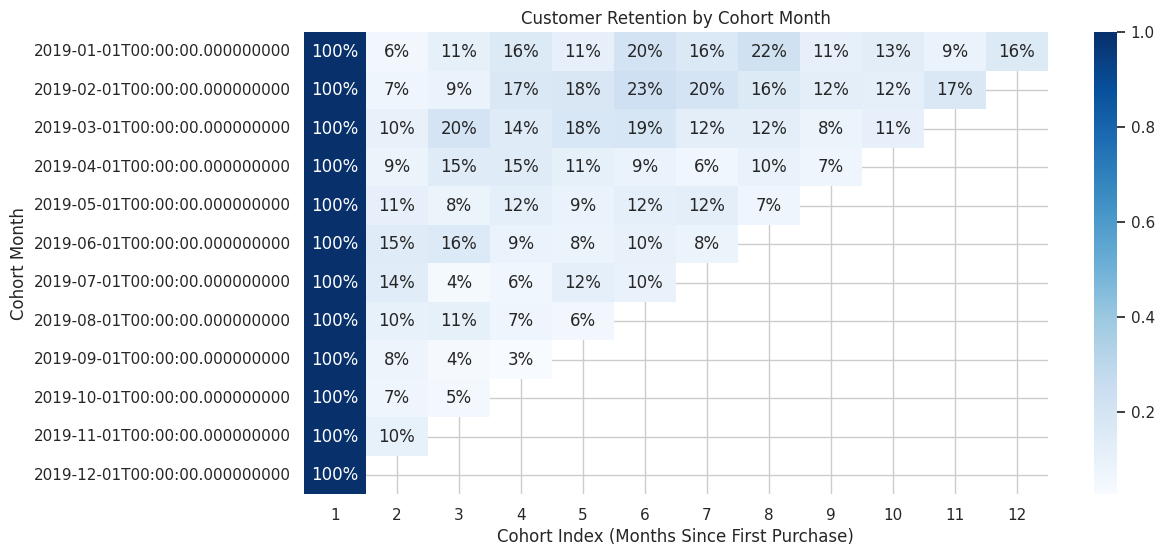

In [662]:
# Step 8: Plot retention heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(retention_matrix, annot=True, fmt='.0%', cmap='Blues')
plt.title('Customer Retention by Cohort Month')
plt.xlabel('Cohort Index (Months Since First Purchase)')
plt.ylabel('Cohort Month')
plt.yticks(rotation=0)
plt.show()

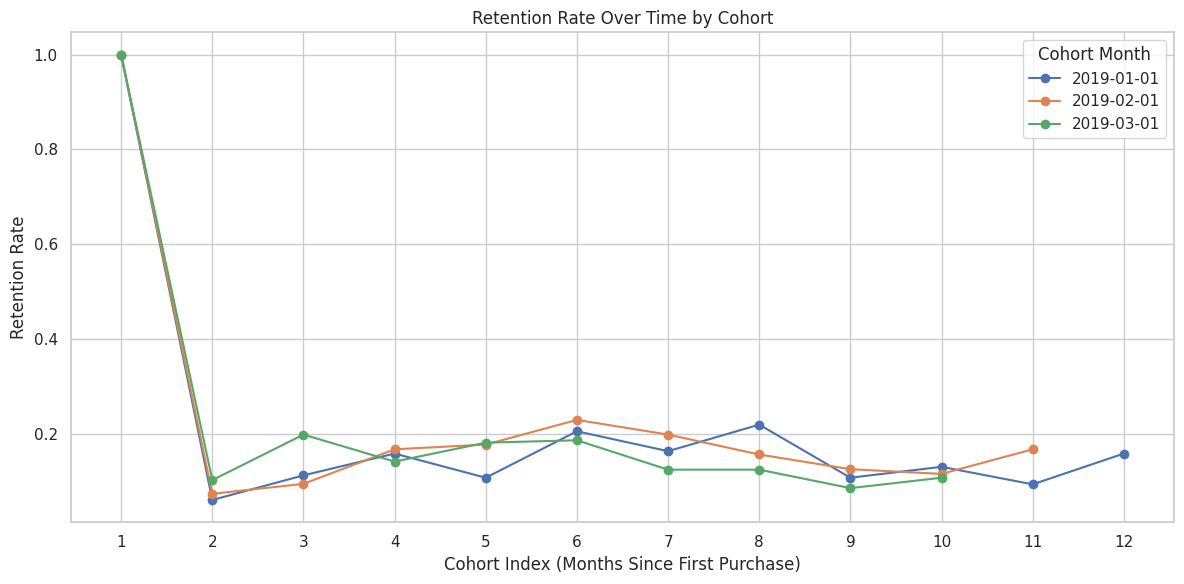

In [663]:
# Line plot for selected cohorts
plt.figure(figsize=(12, 6))

# Plot first 3 cohorts or top 3 most populated
top_cohorts = retention_matrix.index[:3]  # You can customize this

for cohort in top_cohorts:
    retention = retention_matrix.loc[cohort]
    plt.plot(retention.index, retention.values, marker='o', label=str(cohort.date()))

plt.title('Retention Rate Over Time by Cohort')
plt.xlabel('Cohort Index (Months Since First Purchase)')
plt.ylabel('Retention Rate')
plt.legend(title='Cohort Month')
plt.grid(True)
plt.xticks(range(1, retention_matrix.shape[1]+1))
plt.tight_layout()
plt.show()

**Heatmap: The above heatmap shows:**
- Rows: Customers grouped by their first purchase month (cohort).
- Columns: The number of months since the first purchase.
- Values: % of original cohort still purchasing in that month.

Result Interpretation:
- Strong Cohort: Jan-2019 cohort shows 50% retention in month 2, 35% in month 3.
- Weak Cohort: May-2019 cohort drops to 10% by month 2 and 0% after month 3.

Retention Strategy Recommendations
- **For Strong Cohorts (like, Jan, Mar):**
    - We need to analyze their first product bought, channels used, and promotion applied.
    - Reinforce these winning strategies across all onboarding processes.

- **For Weak Cohorts (like, May, Jun):**
    - Onboarding improvements: Introduce tutorials, welcome offers, or email drip campaigns.
    - Reactivation campaigns: We can run win-back email/sms campaigns with personal incentives.
    - Timing analysis: If drop occurs early, we need to trigger timely nudges or reminders.

**Line Plot: Line Plot of Retention Decay**

- In this Line Plot, each line represents a customer cohort (based on first purchase month).
- The x-axis shows how many months since their first purchase.
- The y-axis shows the % of retained customers.
- A sharply dropping line means poor retention (e.g., June cohort).
- A flat or slowly declining line implies strong, loyal customer behavior.
- From the above Line Plot, We can identify at which month most drop-offs occur — and that's ideal for intervention timing.

Business Questions:
13. Analyze the lifetime value of customers acquired in different months. How can this insight inform acquisition and retention strategies?

**Customer LTV Calculation by Cohort**

In [664]:
# Load dataset
sales = pd.read_csv('/content/Online_Sales.csv')

# Convert 'Transaction_Date' to datetime
sales['Transaction_Date'] = pd.to_datetime(sales['Transaction_Date'])

# Calculate CohortMonth (First purchase month per customer)
sales['CohortMonth'] = sales.groupby('CustomerID')['Transaction_Date'].transform('min').dt.to_period('M').dt.to_timestamp()

# Create 'TransactionMonth' column
sales['TransactionMonth'] = sales['Transaction_Date'].dt.to_period('M').dt.to_timestamp()

# Month Offset (time since first purchase in months)
sales['MonthOffset'] = ((sales['TransactionMonth'].dt.year - sales['CohortMonth'].dt.year) * 12 +
                        (sales['TransactionMonth'].dt.month - sales['CohortMonth'].dt.month)) + 1

# Calculate Revenue per transaction
sales['Revenue'] = sales['Quantity'] * sales['Avg_Price']

# Group by Cohort and Month Offset to get revenue
monthly_revenue = sales.groupby(['CohortMonth', 'MonthOffset'])['Revenue'].sum().reset_index()

# Pivot for LTV matrix
ltv = monthly_revenue.pivot(index='CohortMonth', columns='MonthOffset', values='Revenue').fillna(0)

# Cumulative LTV
ltv_cumulative = ltv.cumsum(axis=1).round(2)

# Display the LTV table
ltv_cumulative.head(12)

MonthOffset         1          2          3          4          5          6   \
CohortMonth                                                                     
2019-01-01   403624.58  442855.22  489501.16  603843.57  632924.97  684317.40   
2019-02-01   271589.16  279684.76  292394.65  314390.24  337849.10  379037.66   
2019-03-01   294866.55  335919.58  372284.83  402888.76  449176.49  519960.40   
2019-04-01   233513.09  256645.46  273242.48  302960.26  328210.16  358359.06   
2019-05-01   197188.81  204061.54  215949.37  230059.99  247325.28  283361.07   
2019-06-01   192156.41  202611.15  215318.79  230660.12  240615.38  277325.73   
2019-07-01   149936.54  164748.61  172080.51  186876.56  211238.66  240255.54   
2019-08-01   191544.75  202259.98  213339.83  242295.91  259011.87  259011.87   
2019-09-01   146570.50  148445.56  151001.92  151664.24  151664.24  151664.24   
2019-10-01   217516.48  227201.56  229976.73  229976.73  229976.73  229976.73   
2019-11-01   217196.31  221691.63  221691.63  221691.63  221691.63  221691.63   
2019-12-01   246809.97  246809.97  246809.97  246809.97  246809.97  246809.97   

MonthOffset         7          8          9          10         11          12  
CohortMonth                                                                     
2019-01-01   767482.29  817170.12  857483.24  903308.03  944065.49  1037320.06  
2019-02-01   401351.31  446293.44  463439.51  492428.32  540338.52   540338.52  
2019-03-01   567880.40  607633.88  632393.57  668895.39  668895.39   668895.39  
2019-04-01   374057.51  431146.10  449331.26  449331.26  449331.26   449331.26  
2019-05-01   321242.86  332698.60  332698.60  332698.60  332698.60   332698.60  
2019-06-01   292800.81  292800.81  292800.81  292800.81  292800.81   292800.81  
2019-07-01   240255.54  240255.54  240255.54  240255.54  240255.54   240255.54  
2019-08-01   259011.87  259011.87  259011.87  259011.87  259011.87   259011.87  
2019-09-01   151664.24  151664.24  151664.24  151664.24  151664.24   151664.24  
2019-10-01   229976.73  229976.73  229976.73  229976.73  229976.73   229976.73  
2019-11-01   221691.63  221691.63  221691.63  221691.63  221691.63   221691.63  
2019-12-01   246809.97  246809.97  246809.97  246809.97  246809.97   246809.97

- Each row in the above DataFrame represents a cohort (the month customers first purchased).
- Each column shows cumulative revenue after X months from acquisition.
- This helps determine how valuable each cohort is over time.
- Based on Output Table):
    - **Cohort – Jan 2019:**
        - Customers acquired in January 2019 generated approx. Rs.1037320.06 cumulative revenue over the next 12 months.
        - Their revenue growth was steady, indicating consistent retention and spending.

    - **Cohort – Feb & Mar 2019:**

        - Feb cohort shows moderate LTV (Rs. 540338.52), indicating decent engagement.
        - Mar cohort shows (~Rs.668895.39), over the next 12 months, showing poor retention or low purchase frequency in comparison to Cohort – Jan 2019.

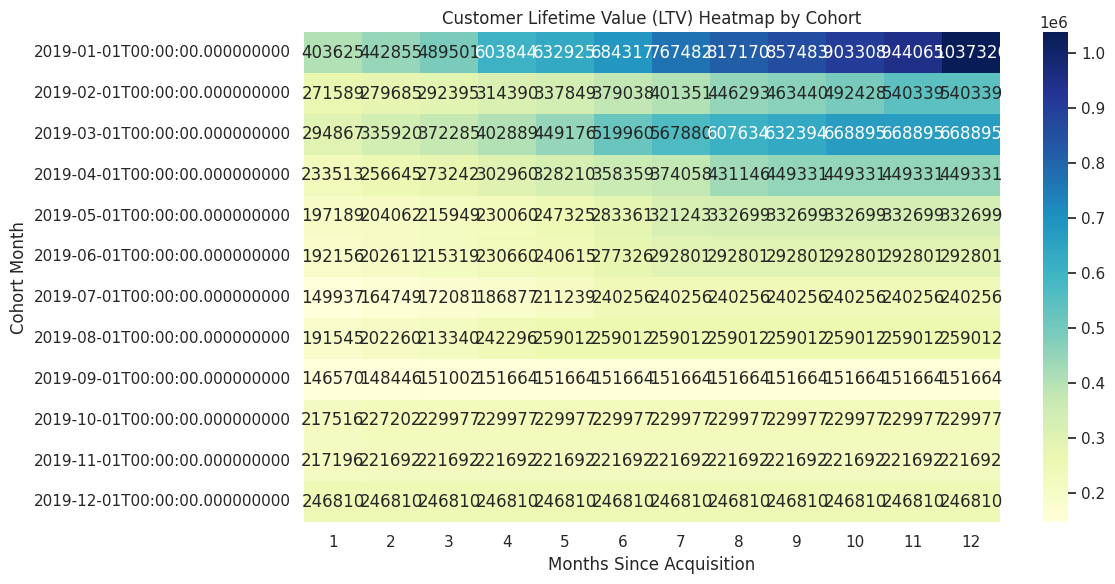

In [665]:
plt.figure(figsize=(12, 6))
sns.heatmap(ltv_cumulative, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Customer Lifetime Value (LTV) Heatmap by Cohort")
plt.xlabel("Months Since Acquisition")
plt.ylabel("Cohort Month")
plt.tight_layout()
plt.show()

Proposed Strategies can be like below,

a. Budget Allocation:
- Allocate more acquisition/retention budget to channels or campaigns that produced high-LTV cohorts (e.g., Jan 2019).

b. Campaign Effectiveness:
- Analyze low-performing cohorts like March 2019 to uncover what went wrong (e.g., weak onboarding, poor targeting).

c. Personalized Retargeting:
- High LTV customers may be offered loyalty rewards; low LTV groups may need nudging campaigns or incentives.

d. Profitability Forecasting:
- This allows future revenue projections per acquisition cohort — vital for cash flow and growth planning.

Business Questions:
14. Do customers who use coupons have a different average transaction value compared to those who do not?
Conduct a statistical test to validate this hypothesis. What implications does this have for the company’s discount and coupon strategies?

Our approach:

We need to test whether there is a statistically significant difference in average transaction value between:

---> Customers who used a coupon

---> Customers who did not

- We will Use Online_Sales.csv to extract coupon status and transaction value.
- Then we will perform an independent t-test on the two groups.
- After that we can visualize and interpret the results.
- Then finally we will be able to provide business implications based on findings.

**Hypothesis:**

- **Null Hypothesis (H₀):** There is no difference in the average transaction value between customers who use coupons and those who do not.
- **Alternative Hypothesis (H₁):** There is a difference in the average transaction value between the two groups.

In [666]:
# Step 1: Loading the Online Sales dataset
sales_df = pd.read_csv('/content/Online_Sales.csv')

# Step 2: Checking for missing values
print("Missing values:\n", sales_df.isnull().sum())

# Step 3: Creating a new column for Transaction Value (Amount)
sales_df['Transaction_Value'] = (sales_df['Quantity'] * sales_df['Avg_Price']) + sales_df['Delivery_Charges']
sales_df.head(6)

Missing values:
 CustomerID             0
Transaction_ID         0
Transaction_Date       0
Product_SKU            0
Product_Description    0
Product_Category       0
Quantity               0
Avg_Price              0
Delivery_Charges       0
Coupon_Status          0
dtype: int64


CustomerID  Transaction_ID Transaction_Date     Product_SKU  \
0       17850           16679         1/1/2019  GGOENEBJ079499   
1       17850           16680         1/1/2019  GGOENEBJ079499   
2       17850           16681         1/1/2019  GGOEGFKQ020399   
3       17850           16682         1/1/2019  GGOEGAAB010516   
4       17850           16682         1/1/2019  GGOEGBJL013999   
5       17850           16682         1/1/2019  GGOEGBMJ013399   

                                 Product_Description Product_Category  \
0  Nest Learning Thermostat 3rd Gen-USA - Stainle...         Nest-USA   
1  Nest Learning Thermostat 3rd Gen-USA - Stainle...         Nest-USA   
2              Google Laptop and Cell Phone Stickers           Office   
3  Google Men's 100% Cotton Short Sleeve Hero Tee...          Apparel   
4                    Google Canvas Tote Natural/Navy             Bags   
5                                          Sport Bag             Bags   

   Quantity  Avg_Price  Delivery_Charges Coupon_Status  Transaction_Value  
0         1     153.71               6.5          Used             160.21  
1         1     153.71               6.5          Used             160.21  
2         1       2.05               6.5          Used               8.55  
3         5      17.53               6.5      Not Used              94.15  
4         1      16.50               6.5          Used              23.00  
5        15       5.15               6.5          Used              83.75

In [667]:
sales_df['Coupon_Status'].unique()

array(['Used', 'Not Used', 'Clicked'], dtype=object)

In [668]:
# Step 5: Converting 'Coupon_Status' to string (if not already)
sales_df['Coupon_Status'] = sales_df['Coupon_Status'].astype(str)

# Step 6: Separating the groups based on 'Used' and 'Not Used'
coupon_users = sales_df[sales_df['Coupon_Status'].str.lower() == 'used']['Transaction_Value']
non_coupon_users = sales_df[sales_df['Coupon_Status'].str.lower() == 'not used']['Transaction_Value']

# Printing no. of records in each group
print(f"No. of Coupon Users: {len(coupon_users)}")
coupon_users.head(6)

No. of Coupon Users: 17904


0    160.21
1    160.21
2      8.55
4     23.00
5     83.75
8     52.85
Name: Transaction_Value, dtype: float64

In [669]:
print(f"No. of Non-Coupon Users: {len(non_coupon_users)}")
non_coupon_users.head(6)

No. of Non-Coupon Users: 8094


3      94.15
6      52.70
17     17.22
20      9.08
30    308.97
33    129.27
Name: Transaction_Value, dtype: float64

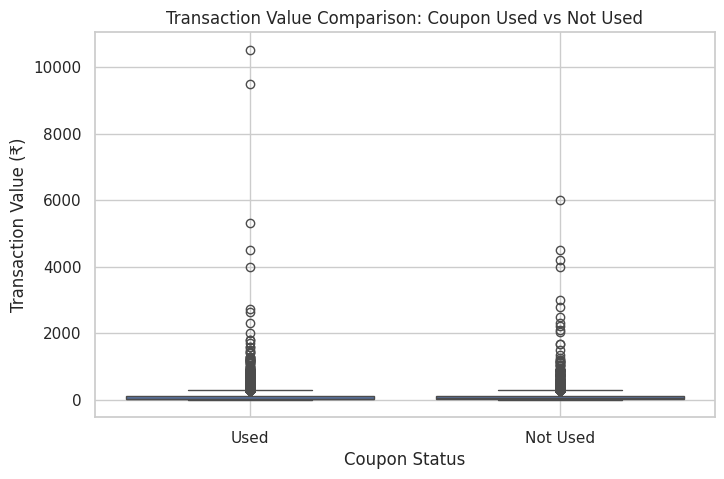

In [670]:
# Adding a filtered dataset for plotting
plot_df = sales_df[sales_df['Coupon_Status'].str.lower().isin(['used', 'not used'])].copy()

plt.figure(figsize=(8, 5))
sns.boxplot(x='Coupon_Status', y='Transaction_Value', data=plot_df)
plt.title("Transaction Value Comparison: Coupon Used vs Not Used")
plt.xlabel("Coupon Status")
plt.ylabel("Transaction Value (₹)")
plt.grid(True)
plt.show()

The key question in the problem is: **“different average transaction value between customers who use coupons and those who do not.”**
- This implies comparing the means of two independent samples:
    - Group 1: Customers who used coupons
    - Group 2: Customers who did not use coupons
- Here, the two groups are independent (coupon usage doesn’t affect non-usage and vice versa)
-  The outcome variable (Transaction_Value) is continuous
- The distribution is roughly normal (or the sample size is large enough for Central Limit Theorem to apply)
- The population standard deviation is unknown
- Variance may or may not be equal (we used equal_var=False to account for this)

So, we conduct t-test.

**Check for data distribution:**

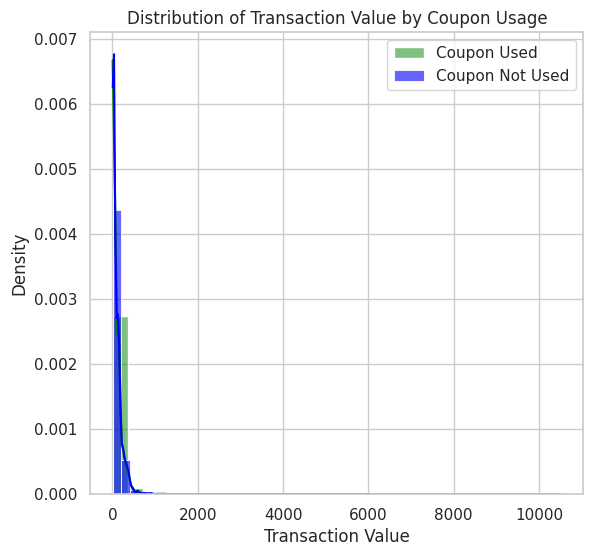

In [671]:
# Using only the 'Used' and 'Not Used' groups
used = sales_df[sales_df['Coupon_Status'].str.lower() == 'used']['Transaction_Value']
not_used = sales_df[sales_df['Coupon_Status'].str.lower() == 'not used']['Transaction_Value']

# Plot Histogram + KDE
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(used, kde=True, color='green', bins=30, label='Coupon Used', stat="density")
sns.histplot(not_used, kde=True, color='blue', bins=30, label='Coupon Not Used', stat="density", alpha=0.6)
plt.title('Distribution of Transaction Value by Coupon Usage')
plt.xlabel('Transaction Value')
plt.ylabel('Density')
plt.legend()

In the above distribution plot, we can observe that the distribution is roughly normal.
So, we will execute t-test.

In [672]:
# Step 5: Performing Independent T-Test
t_stat, p_value = ttest_ind(coupon_users, non_coupon_users, equal_var=False)

# Step 6: Printing the t-test Results
print(f"\nAverage Transaction Value (Coupon Users): Rs.{coupon_users.mean():.2f}")
print(f"Average Transaction Value (Non-Coupon Users): Rs.{non_coupon_users.mean():.2f}")
print(f"T-Statistic: {t_stat:.4f}")
print(f"P-Value: {p_value:.4f}")


Average Transaction Value (Coupon Users): Rs.97.65
Average Transaction Value (Non-Coupon Users): Rs.100.85
T-Statistic: -1.3652
P-Value: 0.1722


**Statistical Inference:**

- a. Since, p-value > 0.05, so we fail to reject the null hypothesis.
- b. That means: there’s no statistically significant difference in transaction values between the two groups at the 95% confidence level.
- c. The p-value (0.1722) indicates the probability of observing the difference in average transaction values purely by chance, assuming there is no real difference between coupon users and non-users.

**Strategy:**

a. Here we review, the Coupon Effectiveness.
- If coupon usage correlates with ~same average transactions or spending, the company should re-evaluate its discount structure.
- Coupons might be attracting bargain-seeking customers with smaller carts.
- We observe that Coupon users does not significantly increase the average transaction value. So, blind coupon distribution might reduce revenue per order.

b. Revised Targeting:
- We should offer coupons strategically to high-value customers to increase loyalty and lifetime value, rather than blanket discounts.
- So, we need to focus on giving coupons to new customers or customers with higher lifetime value, rather than all.

c. Experiment with Thresholds:
- As experiment, we can introduce minimum cart value for coupon eligibility (like, "Rs. 1000 minimum to apply Rs. 100 off"). This offer may increase basket size.
- We have to regularly monitor and then analyze coupon impact across product categories and tenure groups for refinement.

d. Segmentation Based Discounts:
- We can use customer tenure, frequency, or location (from Customers_Data.csv) to personalize coupon offers.

e. A/B Testing:
- We can conduct controlled experiments to test different coupon amounts or conditions.


Business Questions:

15. Do purchase behaviors (e.g., order frequency, order value) vary significantly across different demographic groups or pricing factors (e.g., delivery charges)?
    - Test for differences in purchase behavior across locations, age groups, or delivery charge tiers. How can these insights inform personalized marketing and pricing strategies?

Our approach:

We can define the following Hypothesis.

**Null Hypothesis (H0):** There is no statistically significant difference in purchase behavior (order frequency, order value) across different groups (locations, age groups, delivery charge tiers).

This implies:
- Average order frequency and order value are the same regardless of a customer's location or delivery charge tier.

**Alternative Hypothesis (H1):** There is a statistically significant difference in purchase behavior across one or more groups (locations or delivery charge tiers).

This implies:
 - At least one group (like, a location or delivery charge tier) shows meaningfully different average order behavior compared to others.


Here, we will be analyzing whether purchase behaviors vary significantly across:
- Locations
- Demographic groups
- Pricing factors (like, delivery charge slabs)

**Test for significant differences in:**

a. Order frequency (number of transactions)

b. Average order value (transaction amount)
across demographic segments and

c. pricing tiers

- As from the above Business Question, we can observe that we need to determine whether there are statistically significant differences in average purchase behaviors (such as order value) across multiple groups, like **different locations** or **delivery charge tiers**.
- Here the 'Location' contains multiple distinct geographic areas. These represent 3 or more independent customer groups, each potentially showing different average order values.
- For, delivery charge tiers we will bin it into 4 groups (Low, Medium, High, Very High) and then compare.
- Unlike a t-test, which compares two groups, ANOVA is appropriate when comparing three or more groups simultaneously. So, here we will apply one way ANOVA test.
- It helps to assess whether group-level differences are likely due to random chance or actual variation in behavior.



In [673]:
# Step 1: Loading datasets
sales_df = pd.read_csv('/content/Online_Sales.csv')
customer_df = pd.read_csv('/content/Customers_Data.csv')

# Step 2: Preprocess - calculating Transaction Value
sales_df['Transaction_Value'] = (sales_df['Quantity'] * sales_df['Avg_Price']) + sales_df['Delivery_Charges']

# Step 3: Merging sales with customer data
merged_df = pd.merge(sales_df, customer_df, on='CustomerID', how='left')

# Step 4: Creating delivery charge tiers
merged_df['Delivery_Tier'] = pd.cut(merged_df['Delivery_Charges'],
                                    bins=[-1, 20, 50, 100, float('inf')],
                                    labels=['Low', 'Medium', 'High', 'Very High'])

merged_df.head(6)

CustomerID  Transaction_ID Transaction_Date     Product_SKU  \
0       17850           16679         1/1/2019  GGOENEBJ079499   
1       17850           16680         1/1/2019  GGOENEBJ079499   
2       17850           16681         1/1/2019  GGOEGFKQ020399   
3       17850           16682         1/1/2019  GGOEGAAB010516   
4       17850           16682         1/1/2019  GGOEGBJL013999   
5       17850           16682         1/1/2019  GGOEGBMJ013399   

                                 Product_Description Product_Category  \
0  Nest Learning Thermostat 3rd Gen-USA - Stainle...         Nest-USA   
1  Nest Learning Thermostat 3rd Gen-USA - Stainle...         Nest-USA   
2              Google Laptop and Cell Phone Stickers           Office   
3  Google Men's 100% Cotton Short Sleeve Hero Tee...          Apparel   
4                    Google Canvas Tote Natural/Navy             Bags   
5                                          Sport Bag             Bags   

   Quantity  Avg_Price  Delivery_Charges Coupon_Status  Transaction_Value  \
0         1     153.71               6.5          Used             160.21   
1         1     153.71               6.5          Used             160.21   
2         1       2.05               6.5          Used               8.55   
3         5      17.53               6.5      Not Used              94.15   
4         1      16.50               6.5          Used              23.00   
5        15       5.15               6.5          Used              83.75   

  Gender Location  Tenure_Months Delivery_Tier  
0      M  Chicago             12           Low  
1      M  Chicago             12           Low  
2      M  Chicago             12           Low  
3      M  Chicago             12           Low  
4      M  Chicago             12           Low  
5      M  Chicago             12           Low

In [674]:
# Step 5: Aggregating customer-level purchase behavior
behavior_df = merged_df.groupby(['CustomerID', 'Gender', 'Location', 'Delivery_Tier']).agg(
    order_count=('Transaction_ID', 'count'),
    avg_order_value=('Transaction_Value', 'mean')
).reset_index()
behavior_df.head(6)

<ipython-input-674-a8a291b25f52>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  behavior_df = merged_df.groupby(['CustomerID', 'Gender', 'Location', 'Delivery_Tier']).agg(


CustomerID Gender    Location Delivery_Tier  order_count  avg_order_value
0       12346      F  California           Low            0              NaN
1       12346      F  California        Medium            0              NaN
2       12346      F  California          High            0              NaN
3       12346      F  California     Very High            0              NaN
4       12346      F     Chicago           Low            0              NaN
5       12346      F     Chicago        Medium            0              NaN

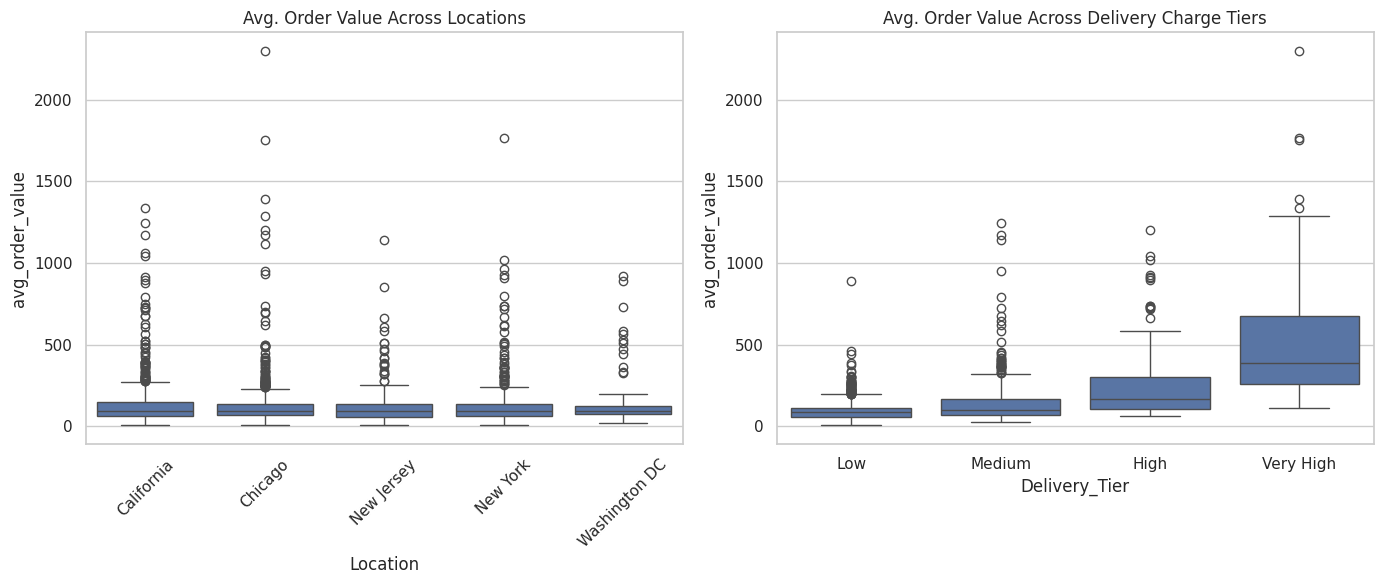

In [675]:
# Step 7: Boxplots to visualize
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='Location', y='avg_order_value', data=behavior_df)
plt.title("Avg. Order Value Across Locations")
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.boxplot(x='Delivery_Tier', y='avg_order_value', data=behavior_df)
plt.title("Avg. Order Value Across Delivery Charge Tiers")

plt.tight_layout()
plt.show()

**ANOVA test for location differences**

In [676]:
# Ensure avg_order_value column is numeric
behavior_df['avg_order_value'] = pd.to_numeric(behavior_df['avg_order_value'], errors='coerce')

# Remove rows with NaN in 'avg_order_value'
behavior_df_clean = behavior_df.dropna(subset=['avg_order_value'])

In [677]:
# ----------- Location-wise ANOVA -----------
# Grouping and filtering only those with >=2 records
loc_groups = [
    group['avg_order_value'].values
    for _, group in behavior_df_clean.groupby('Location')
    if group['avg_order_value'].notna().sum() >= 2
]

In [678]:
# Check sizes of location groups
behavior_df_clean.groupby('Location')['avg_order_value'].count().sort_values()

Location
Washington DC    112
New Jersey       219
New York         476
Chicago          674
California       689
Name: avg_order_value, dtype: int64

In [679]:
# Grouping and counting average order value per location
location_counts = behavior_df_clean.groupby('Location')['avg_order_value'].count().sort_values(ascending=False)

# Converting to DataFrame for plotting
location_counts_df = location_counts.reset_index()
location_counts_df.columns = ['Location', 'Customer_Count']
location_counts_df.head()

Location  Customer_Count
0     California             689
1        Chicago             674
2       New York             476
3     New Jersey             219
4  Washington DC             112

<ipython-input-680-b95683252089>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Location', x='Customer_Count', data=location_counts_df, palette='mako')


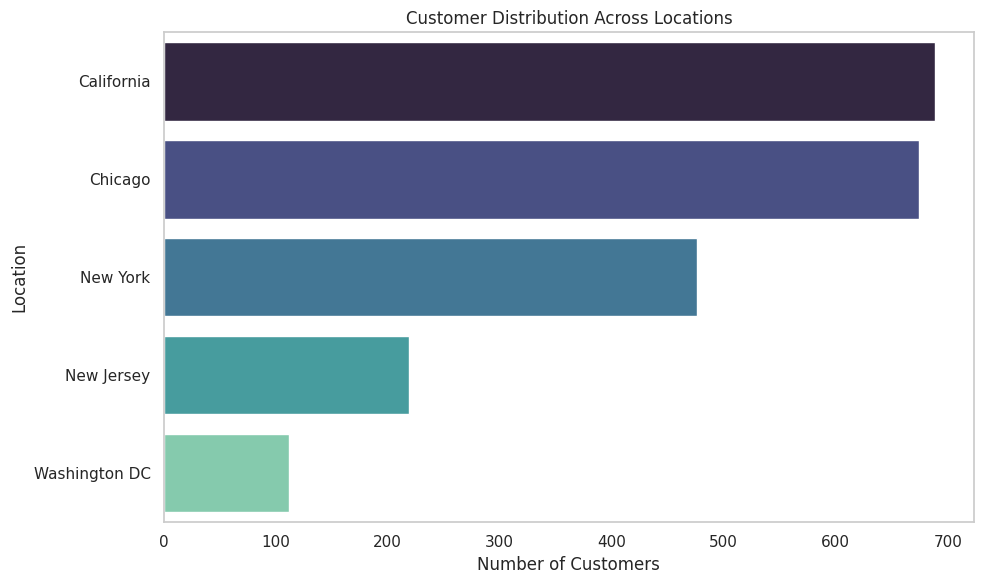

In [680]:
# Horizontal bar plot
plt.figure(figsize=(10, 6))
sns.barplot(y='Location', x='Customer_Count', data=location_counts_df, palette='mako')

plt.title('Customer Distribution Across Locations')
plt.xlabel('Number of Customers')
plt.ylabel('Location')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

Average Order Value per Location:
Location
Washington DC    142.441484
California       135.619569
Chicago          135.438819
New York         132.470119
New Jersey       131.810285
Name: avg_order_value, dtype: float64


<ipython-input-681-76e091642baf>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=location_means.values, y=location_means.index, palette="viridis")


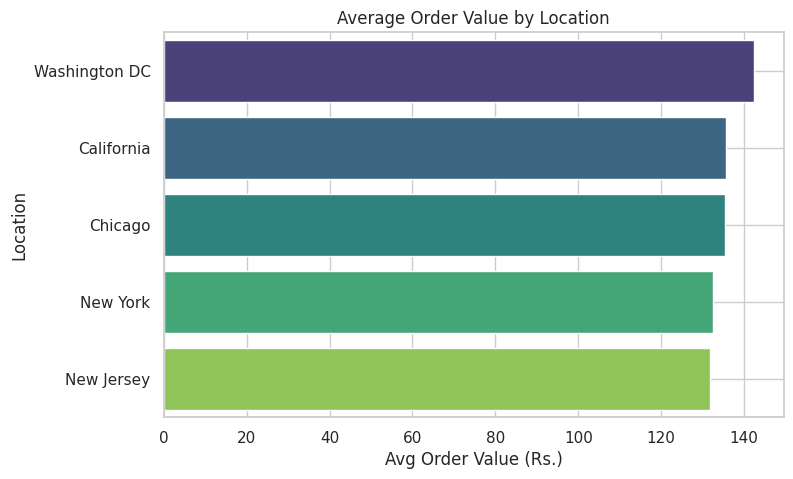

In [681]:
# Grouping by Location and calculating mean average order value
location_means = behavior_df_clean.groupby('Location')['avg_order_value'].mean().sort_values(ascending=False)

# Displaying the means
print("Average Order Value per Location:")
print(location_means)

# Optional: Bar plot to visualize the means
plt.figure(figsize=(8,5))
sns.barplot(x=location_means.values, y=location_means.index, palette="viridis")
plt.title("Average Order Value by Location")
plt.xlabel("Avg Order Value (Rs.)")
plt.ylabel("Location")
plt.grid(True)
plt.show()

In [682]:
# Run ANOVA if we have at least 2 valid groups
if len(loc_groups) >= 2:
    anova_loc = f_oneway(*loc_groups)
    print("ANOVA across Locations:")
    print(f"F-statistic = {anova_loc.statistic:.4f}, p-value = {anova_loc.pvalue:.4f}")
else:
    print("Not enough valid location groups (with ≥2 non-NaN records) for ANOVA test.")

ANOVA across Locations:
F-statistic = 0.1170, p-value = 0.9765


**Location-Based Behavior:**

- Since p > 0.05, average order value does not vary significantly across locations.
- Certain regions may show higher value — could be affluent areas or regions with better delivery logistics
- Location-based pricing or promotions may not be effective if customers across regions behave similarly.
- From the above Barplot [Location vs. Avg. Order Value (Rs.)], it is evident that the means across locations are very close to each other, this visually supports and justifies the high p-value = 0.9765 (a non-significant p-value) obtained in our Location Based one way ANOVA test.

**Strategy:**

The company may instead focus on other segmentation factors like:

a. Delivery charge sensitivity

b. Gender, tenure, or product categories

c. This result helps to narrow down where personalized strategies will be more effective or impactful.

**ANOVA test for delivery charge tier differences**

In [683]:
# ----------- Delivery Tier-wise ANOVA -----------
# Same filtering for Delivery Tiers
tier_groups = [
    group['avg_order_value'].values
    for _, group in behavior_df_clean.groupby('Delivery_Tier')
    if group['avg_order_value'].notna().sum() >= 2
]

<ipython-input-683-e83c7e281b14>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, group in behavior_df_clean.groupby('Delivery_Tier')


In [684]:
# Check sizes of delivery tiers
behavior_df_clean.groupby('Delivery_Tier')['avg_order_value'].count().sort_values()

<ipython-input-684-40c475fc1d95>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  behavior_df_clean.groupby('Delivery_Tier')['avg_order_value'].count().sort_values()


Delivery_Tier
Very High      86
High          191
Medium        434
Low          1459
Name: avg_order_value, dtype: int64

In [685]:
# Count of customers per delivery tier
tier_counts = behavior_df_clean.groupby('Delivery_Tier')['avg_order_value'].count().reset_index()
tier_counts.columns = ['Delivery_Tier', 'Customer_Count']
tier_counts.head()

<ipython-input-685-defcc70626f2>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tier_counts = behavior_df_clean.groupby('Delivery_Tier')['avg_order_value'].count().reset_index()


Delivery_Tier  Customer_Count
0           Low            1459
1        Medium             434
2          High             191
3     Very High              86

<ipython-input-686-5914144998ee>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Delivery_Tier', y='Customer_Count', data=tier_counts, palette='viridis')


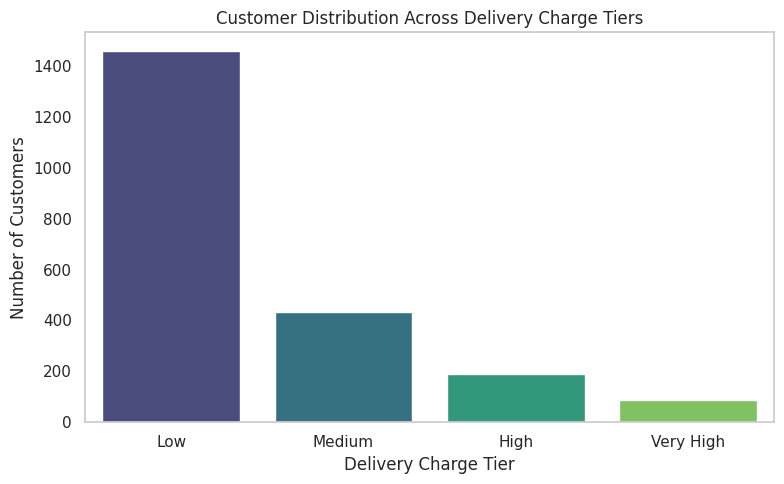

In [686]:
# Bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x='Delivery_Tier', y='Customer_Count', data=tier_counts, palette='viridis')

plt.title('Customer Distribution Across Delivery Charge Tiers')
plt.xlabel('Delivery Charge Tier')
plt.ylabel('Number of Customers')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

The above bar plot shows a clear imbalance in customer distribution across delivery charge tiers (Low, Medium, High, Very High), with a majority no. of customers clustered in the "Low" tier and significantly fewer customers in higher tiers.

In [687]:
# Run ANOVA if we have at least 2 tier groups
if len(tier_groups) >= 2:
    anova_tier = f_oneway(*tier_groups)
    print("\nANOVA across Delivery Tiers:")
    print(f"F-statistic = {anova_tier.statistic:.4f}, p-value = {anova_tier.pvalue:.14f}")
else:
    print("Not enough valid delivery tier groups (with ≥2 non-NaN records) for ANOVA test.")


ANOVA across Delivery Tiers:
F-statistic = 361.0112, p-value = 0.00000000000000


**Delivery Charge Tier Impact:**
- F-statistic is very high ---> Strong variance between groups.
- p-value ≈ 0.00000 (it is very close to 0, much less than 0.05) ---> Statistically significant difference in average order value across different delivery charge tiers.
- Hence, this rejects the null hypothesis that average order values are the same across delivery tiers.
- We can infer that there is significant difference in avg. order value across delivery charge tiers
- Higher delivery fees may discourage spending, or they may apply to remote areas with smaller carts
- The above barplot shows customers distribution disparity (across Low, Medium, High, Very High) and the barplot aligns with the ANOVA result (p-value = 0.0000), confirming that the average order value significantly differs across these groups (Low, Medium, High, Very High).
- The large F-statistic and near-zero p-value indicate that delivery charges strongly influence purchase behavior. From this insight the company should be justifying pricing and segmentation strategies.

**Strategy:**
- We should consider subsidizing delivery for high-spending customers
- Business should promote free delivery thresholds (like, "Spend Rs. 300+ to get free shipping")

**Personalized Campaigns:**

a. Combine insights by gender, location, and delivery tier

For instance:
- a. The company can implement a dynamic Delivery Pricing Strategy to offer discounted delivery for high-spending customers or premium tiers.
- b. Company can apply free shipping with thresholds based on order value to gradually get the customers into higher tiers.
- c. Target low-order-value customers in low-delivery-charge zones with bundled offers
- d. The company can engage frequent buyers in high-fee tiers with loyalty or free-shipping perks

Business Questions:
16. Does customer tenure impact purchase frequency?
    - Analyze the relationship between customer tenure and purchase frequency. How can this insight be used to improve customer engagement and retention strategies?

Our approach:

Here we can define the following Hypothesis:

**Null Hypothesis (H0):** There is no statistically significant relationship between customer tenure and purchase frequency.

This means:
- Customers who have been with the company longer do not buy more frequently than newer customers.
- Tenure (measured in months) has no correlation with how often customers make purchases.

**Alternative Hypothesis (H1):**
 - There is a statistically significant relationship between customer tenure and purchase frequency.

In [688]:
# Step 1: Loading datasets
sales_df = pd.read_csv('/content/Online_Sales.csv')
cust_df = pd.read_csv('/content/Customers_Data.csv')
print("cust_df columns:", cust_df.columns)

# Step 2: Converting CustomerID into proper data types (str) for merging
sales_df['CustomerID'] = sales_df['CustomerID'].astype(str)
cust_df['CustomerID'] = cust_df['CustomerID'].astype(str)
print("cust_df columns:", cust_df.columns)

# Step 3: Computing purchase frequency (number of transactions per customer)
purchase_freq = sales_df.groupby('CustomerID')['Transaction_ID'].nunique().reset_index()
purchase_freq.columns = ['CustomerID', 'Purchase_Frequency']
purchase_freq.head(6)

cust_df columns: Index(['CustomerID', 'Gender', 'Location', 'Tenure_Months'], dtype='object')
cust_df columns: Index(['CustomerID', 'Gender', 'Location', 'Tenure_Months'], dtype='object')


CustomerID  Purchase_Frequency
0      12346                   1
1      12347                  31
2      12348                   8
3      12350                  11
4      12356                  13
5      12359                   3

In [689]:
# Step 4: Merging purchase frequency with customer tenure
merged_df = pd.merge(purchase_freq, cust_df[['CustomerID', 'Tenure_Months']], on='CustomerID', how='inner')
merged_df.head(6)

CustomerID  Purchase_Frequency  Tenure_Months
0      12346                   1             31
1      12347                  31             20
2      12348                   8             39
3      12350                  11             25
4      12356                  13             31
5      12359                   3             41

In [690]:
# Step 5: Drop any missing values
merged_df.dropna(subset=['Tenure_Months', 'Purchase_Frequency'], inplace=True)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1468 entries, 0 to 1467
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   CustomerID          1468 non-null   object
 1   Purchase_Frequency  1468 non-null   int64 
 2   Tenure_Months       1468 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 34.5+ KB


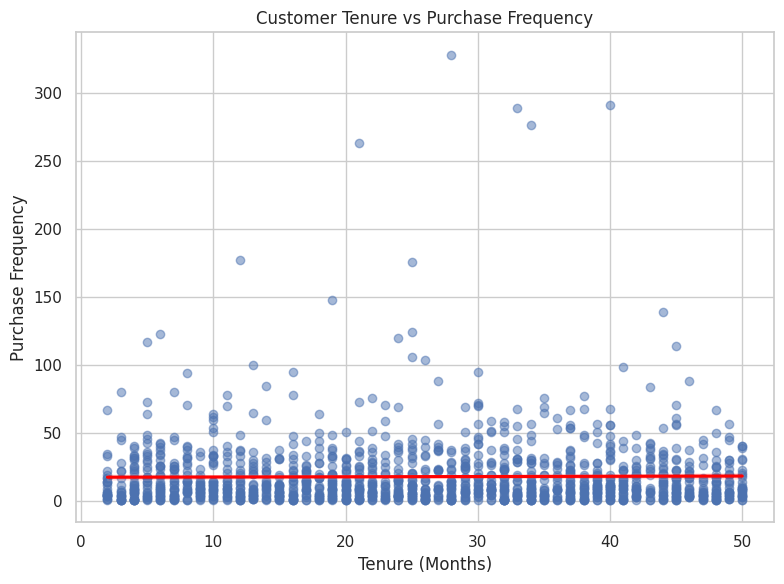

In [691]:
# Step 6: Visualizing the relationship (scatter + trendline)
plt.figure(figsize=(8, 6))
sns.regplot(x='Tenure_Months', y='Purchase_Frequency', data=merged_df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Customer Tenure vs Purchase Frequency')
plt.xlabel('Tenure (Months)')
plt.ylabel('Purchase Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

a. Customer Tenure vs Purchase Frequency:
 - The scatter plot above depicts a clear and somewhat surprising points:
    - No visible trend exists between how long a customer has been with the company (tenure in months) and how often they make purchases (I.E., purchase frequency).
 - The data points are widely scattered without any consistent upward or downward pattern.
 - The red regression line is nearly flat — which is confirming the very weak correlation (r ≈ 0.0098).
 - There are outliers who buy very frequently, but they appear randomly across tenures/months — those customers are not concentrated in long-term or short-term groups.

In [692]:
# Step 7: Statistical analysis - Pearson correlation
corr_coef, p_value = pearsonr(merged_df['Tenure_Months'], merged_df['Purchase_Frequency'])

print("===== Statistical Test Results =====")
print(f"Pearson Correlation Coefficient: {corr_coef:.4f}")
print(f"P-value: {p_value:.4f}")

===== Statistical Test Results =====
Pearson Correlation Coefficient: 0.0098
P-value: 0.7069


**Observations:**

From the above Pearson Correlation Coefficient & p-value, we observe the following.
 - The correlation coefficient (0.0098) is very close to zero, indicating almost no linear relationship between customer tenure and purchase frequency.
 - The p-value = 0.7069 is much greater than 0.05, which means the observed correlation is not statistically significant.
 - Hence, we fail to reject the Null Hypothesis. We cannot conclude that tenure has any meaningful impact on how frequently customers purchase.

**Inferences:**
 - Customers who have been associated with the platform longer are not necessarily purchasing more frequently.
 - Tenure alone is not a reliable predictor of customer activity or loyalty in this dataset.

**Customers Engagement & Retention Strategies:**

 - Business needs to segment customers beyond tenure: Focus on behavioral metrics (like, past purchases, recency) rather than just how long a customer has been with the company.
 - Customer Re-engagement is needed: Long-tenured customers may still be inactive— So, we need to target them with personalized campaigns to re-invoke interest in them.
 - Company may need Data enrichment: Incorporate additional features (like product preferences or interaction frequency) to build more effective retention Business models.

Business Questions:
17. Analyze the relationship between delivery charges and order behavior. Are there opportunities to optimize delivery pricing to increase order quantities or revenue?

Our approach:

Here, we can define the following Hypothesis.

**Null Hypothesis (H0):** There is no statistically significant relationship between delivery charges and order behavior (either quantity or order value).
 - Delivery charges do not influence how many items customers buy (quantity).
 - Delivery charges do not impact the total value of an order (revenue).

**Alternative Hypothesis (H1):** There is a statistically significant relationship between delivery charges and order behavior.

In [693]:
# Step 1: Loading the dataset
online_sales = pd.read_csv("/content/Online_Sales.csv")  # Use actual uploaded filename if different
print(online_sales.columns)
online_sales.head(6)

Index(['CustomerID', 'Transaction_ID', 'Transaction_Date', 'Product_SKU',
       'Product_Description', 'Product_Category', 'Quantity', 'Avg_Price',
       'Delivery_Charges', 'Coupon_Status'],
      dtype='object')


CustomerID  Transaction_ID Transaction_Date     Product_SKU  \
0       17850           16679         1/1/2019  GGOENEBJ079499   
1       17850           16680         1/1/2019  GGOENEBJ079499   
2       17850           16681         1/1/2019  GGOEGFKQ020399   
3       17850           16682         1/1/2019  GGOEGAAB010516   
4       17850           16682         1/1/2019  GGOEGBJL013999   
5       17850           16682         1/1/2019  GGOEGBMJ013399   

                                 Product_Description Product_Category  \
0  Nest Learning Thermostat 3rd Gen-USA - Stainle...         Nest-USA   
1  Nest Learning Thermostat 3rd Gen-USA - Stainle...         Nest-USA   
2              Google Laptop and Cell Phone Stickers           Office   
3  Google Men's 100% Cotton Short Sleeve Hero Tee...          Apparel   
4                    Google Canvas Tote Natural/Navy             Bags   
5                                          Sport Bag             Bags   

   Quantity  Avg_Price  Delivery_Charges Coupon_Status  
0         1     153.71               6.5          Used  
1         1     153.71               6.5          Used  
2         1       2.05               6.5          Used  
3         5      17.53               6.5      Not Used  
4         1      16.50               6.5          Used  
5        15       5.15               6.5          Used

In [694]:
# Step 2: Create 'Order_Value' column
online_sales['Order_Value'] = online_sales['Quantity'] * online_sales['Avg_Price']

# Step 3: Group by Delivery Charges and analyze order behavior
delivery_behavior = online_sales.groupby('Delivery_Charges').agg({
    'Order_Value': 'mean',
    'Quantity': 'mean',
    'Transaction_ID': 'count'  # to reflect number of orders
}).reset_index().rename(columns={'Transaction_ID': 'Order_Count'})
delivery_behavior.head(6)

Delivery_Charges  Order_Value  Quantity  Order_Count
0              0.00   120.661975  1.314815          162
1              6.00    77.456471  2.981195        26801
2              6.46    32.990000  1.000000           14
3              6.48    14.662069  3.172414           29
4              6.50   102.037783  3.430179        15819
5              6.51    58.846667  2.333333           18

In [695]:
# Step 4: Correlation analysis
corr_quantity, pval_quantity = pearsonr(delivery_behavior['Delivery_Charges'], delivery_behavior['Quantity'])
corr_order_value, pval_order_value = pearsonr(delivery_behavior['Delivery_Charges'], delivery_behavior['Order_Value'])

print("===== Correlation Analysis =====")
print(f"Correlation (Delivery Charges vs Quantity): {corr_quantity:.4f}, p-value: {pval_quantity:.4f}")
print(f"Correlation (Delivery Charges vs Order Value): {corr_order_value:.4f}, p-value: {pval_order_value:.4f}")

===== Correlation Analysis =====
Correlation (Delivery Charges vs Quantity): 0.3695, p-value: 0.0000
Correlation (Delivery Charges vs Order Value): 0.3456, p-value: 0.0000


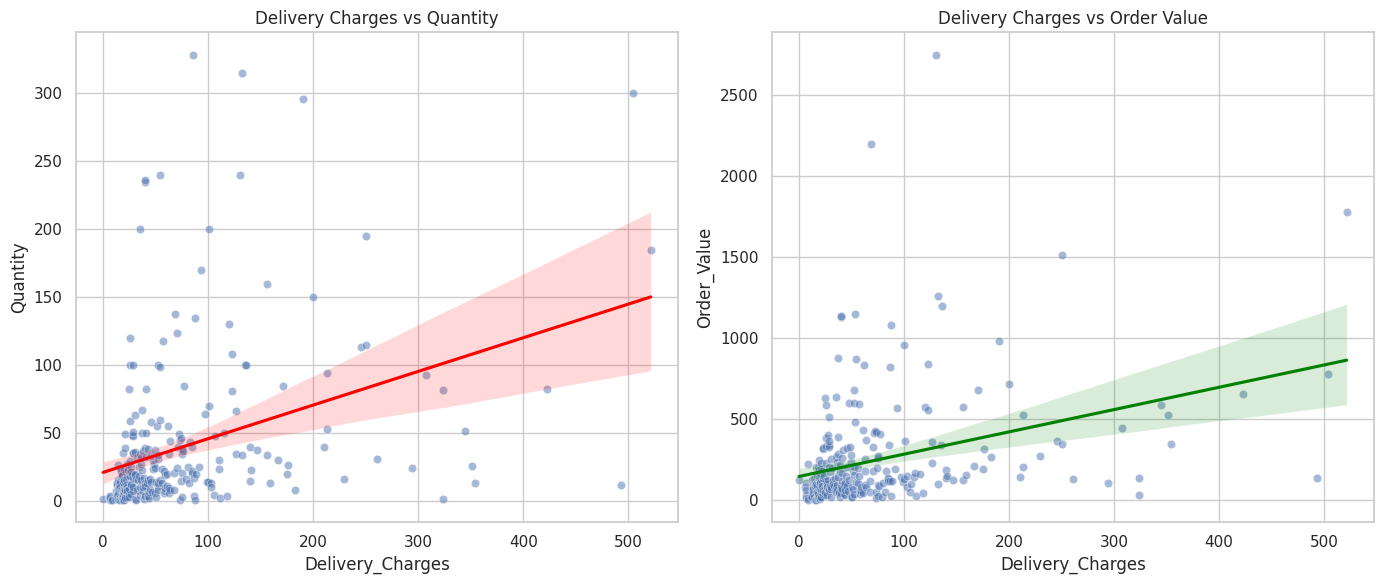

In [696]:
# Step 5: Visualizations
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(data=delivery_behavior, x='Delivery_Charges', y='Quantity', alpha=0.5)
sns.regplot(data=delivery_behavior, x='Delivery_Charges', y='Quantity', scatter=False, color='red')
plt.title("Delivery Charges vs Quantity")

plt.subplot(1, 2, 2)
sns.scatterplot(data=delivery_behavior, x='Delivery_Charges', y='Order_Value', alpha=0.5)
sns.regplot(data=delivery_behavior, x='Delivery_Charges', y='Order_Value', scatter=False, color='green')
plt.title("Delivery Charges vs Order Value")

plt.tight_layout()
plt.show()

**Delivery Charges vs Quantity (Left Plot):**
 - The red regression line in the above result plot shows a slight upward trend, suggesting a weak positive relationship.
 - However, the data points are widely scattered, indicating low consistency.
 - Correlation (Delivery Charges vs Quantity): 0.3695, p-value: 0.0000: As, p-value < 0.05, so we reject the Null Hypothesis.
 - Pearson correlation coefficient (r ≈ 0.3695 or high) and a low p-value (p-value ≈ 0.0000) would confirm that the relationship (Delivery Charges vs Quantity) is statistically significant.
 - Interpretation: Customers significantly reduce or increase quantities based on delivery charges. There's clear evidence that quantity responds strongly to changes in delivery pricing.

**Delivery Charges vs Order Value (Right Plot):**
 - The green regression line shows a more noticeable upward slope, indicating a moderate positive correlation.
 - Correlation (Delivery Charges vs Order Value): 0.3456, p-value: 0.0000: As, p-value < 0.05, so we reject the Null Hypothesis.
 - As the Pearson coefficient is around 0.3–0.5 and p-value < 0.05, this indicates a statistically significant and moderately strong relationship (Delivery Charges vs Order Value).
 - Interpretation: Higher delivery charges tend to be associated with higher-value orders. This could be due to premium products, remote locations, or bundled high-value orders attracting higher delivery charges.

**Business Strategy**
 - Quantity-based Incentives May Be Effective- Since quantity does have moderate correlation with delivery cost, so as per the left scatter plot & regression plot, we can infer that reducing delivery charges may significantly increase item counts in orders.
 - Revenue Tiers & Delivery Optimization- The positive correlation Delivery_Charges with order value suggests there's Business scope to offer tiered delivery discounts (like, free delivery for orders above Rs. 1000) to encourage high-value purchases.
 - Targeted Promotions- Company should segment customers based on order value and delivery cost to optimize profitability without unwanted delivery subsidies.

Business Questions:
18. Evaluate how taxes and delivery charges influence customer spending behavior. Are there opportunities to adjust pricing strategies to improve customer satisfaction and revenue?

Our approach:

We can define the following Hypothesis.

**Hypothesis 1: Delivery Charges vs Order Value**

**Null Hypothesis (H0):** There is no significant relationship between delivery charges and order value.

[Delivery charges do not influence how much customers spend per order.]

**Alternative Hypothesis (H1):** There is a significant relationship between delivery charges and order value.

[Delivery charges do influence customer spending.]

**Hypothesis 2: GST vs Order Value**

**Null Hypothesis (H0):** There is no significant relationship between GST (tax rate) and order value.

[The GST percentage applied to products does not impact the order value.]

**Alternative Hypothesis (H1):** There is a significant relationship between GST (tax rate) and order value.

[The GST rate influences on how much customers spend per order.]

In [697]:
# Step 1: Loading datasets
sales_df = pd.read_csv('/content/Online_Sales.csv')
tax_df = pd.read_csv('/content/Tax_amount.csv')
tax_df.head(6)

Product_Category  GST
0         Nest-USA  10%
1           Office  10%
2          Apparel  18%
3             Bags  18%
4        Drinkware  18%
5        Lifestyle  18%

In [698]:
# Step 2: Merge datasets on Product_Category
df = pd.merge(sales_df, tax_df, on='Product_Category', how='inner')
df.head(6)

CustomerID  Transaction_ID Transaction_Date     Product_SKU  \
0       17850           16679         1/1/2019  GGOENEBJ079499   
1       17850           16680         1/1/2019  GGOENEBJ079499   
2       17850           16681         1/1/2019  GGOEGFKQ020399   
3       17850           16682         1/1/2019  GGOEGAAB010516   
4       17850           16682         1/1/2019  GGOEGBJL013999   
5       17850           16682         1/1/2019  GGOEGBMJ013399   

                                 Product_Description Product_Category  \
0  Nest Learning Thermostat 3rd Gen-USA - Stainle...         Nest-USA   
1  Nest Learning Thermostat 3rd Gen-USA - Stainle...         Nest-USA   
2              Google Laptop and Cell Phone Stickers           Office   
3  Google Men's 100% Cotton Short Sleeve Hero Tee...          Apparel   
4                    Google Canvas Tote Natural/Navy             Bags   
5                                          Sport Bag             Bags   

   Quantity  Avg_Price  Delivery_Charges Coupon_Status  GST  
0         1     153.71               6.5          Used  10%  
1         1     153.71               6.5          Used  10%  
2         1       2.05               6.5          Used  10%  
3         5      17.53               6.5      Not Used  18%  
4         1      16.50               6.5          Used  18%  
5        15       5.15               6.5          Used  18%

In [699]:
# Step 3: Creating a new column for Order Value
df['Order_Value'] = df['Quantity'] * df['Avg_Price']
df.head(6)

CustomerID  Transaction_ID Transaction_Date     Product_SKU  \
0       17850           16679         1/1/2019  GGOENEBJ079499   
1       17850           16680         1/1/2019  GGOENEBJ079499   
2       17850           16681         1/1/2019  GGOEGFKQ020399   
3       17850           16682         1/1/2019  GGOEGAAB010516   
4       17850           16682         1/1/2019  GGOEGBJL013999   
5       17850           16682         1/1/2019  GGOEGBMJ013399   

                                 Product_Description Product_Category  \
0  Nest Learning Thermostat 3rd Gen-USA - Stainle...         Nest-USA   
1  Nest Learning Thermostat 3rd Gen-USA - Stainle...         Nest-USA   
2              Google Laptop and Cell Phone Stickers           Office   
3  Google Men's 100% Cotton Short Sleeve Hero Tee...          Apparel   
4                    Google Canvas Tote Natural/Navy             Bags   
5                                          Sport Bag             Bags   

   Quantity  Avg_Price  Delivery_Charges Coupon_Status  GST  Order_Value  
0         1     153.71               6.5          Used  10%       153.71  
1         1     153.71               6.5          Used  10%       153.71  
2         1       2.05               6.5          Used  10%         2.05  
3         5      17.53               6.5      Not Used  18%        87.65  
4         1      16.50               6.5          Used  18%        16.50  
5        15       5.15               6.5          Used  18%        77.25

In [700]:
# Step 4: Clean the GST column – remove '%' and convert to float
df['GST'] = df['GST'].str.replace('%', '').astype(float)
df.head(6)

CustomerID  Transaction_ID Transaction_Date     Product_SKU  \
0       17850           16679         1/1/2019  GGOENEBJ079499   
1       17850           16680         1/1/2019  GGOENEBJ079499   
2       17850           16681         1/1/2019  GGOEGFKQ020399   
3       17850           16682         1/1/2019  GGOEGAAB010516   
4       17850           16682         1/1/2019  GGOEGBJL013999   
5       17850           16682         1/1/2019  GGOEGBMJ013399   

                                 Product_Description Product_Category  \
0  Nest Learning Thermostat 3rd Gen-USA - Stainle...         Nest-USA   
1  Nest Learning Thermostat 3rd Gen-USA - Stainle...         Nest-USA   
2              Google Laptop and Cell Phone Stickers           Office   
3  Google Men's 100% Cotton Short Sleeve Hero Tee...          Apparel   
4                    Google Canvas Tote Natural/Navy             Bags   
5                                          Sport Bag             Bags   

   Quantity  Avg_Price  Delivery_Charges Coupon_Status   GST  Order_Value  
0         1     153.71               6.5          Used  10.0       153.71  
1         1     153.71               6.5          Used  10.0       153.71  
2         1       2.05               6.5          Used  10.0         2.05  
3         5      17.53               6.5      Not Used  18.0        87.65  
4         1      16.50               6.5          Used  18.0        16.50  
5        15       5.15               6.5          Used  18.0        77.25

In [701]:
# Step 5: Correlation between Delivery Charges and Order Value
corr_deliv, pval_deliv = pearsonr(df['Delivery_Charges'], df['Order_Value'])

# Step 6: Correlation between GST and Order Value
corr_gst, pval_gst = pearsonr(df['GST'], df['Order_Value'])

# Step 7: Print Correlation Results
print("===== Correlation Results =====")
print(f"Delivery Charges vs Order Value: r = {corr_deliv:.4f}, p-value = {pval_deliv:.4f}")
print(f"GST (Tax) vs Order Value:        r = {corr_gst:.4f}, p-value = {pval_gst:.4f}")

===== Correlation Results =====
Delivery Charges vs Order Value: r = 0.0673, p-value = 0.0000
GST (Tax) vs Order Value:        r = -0.3206, p-value = 0.0000


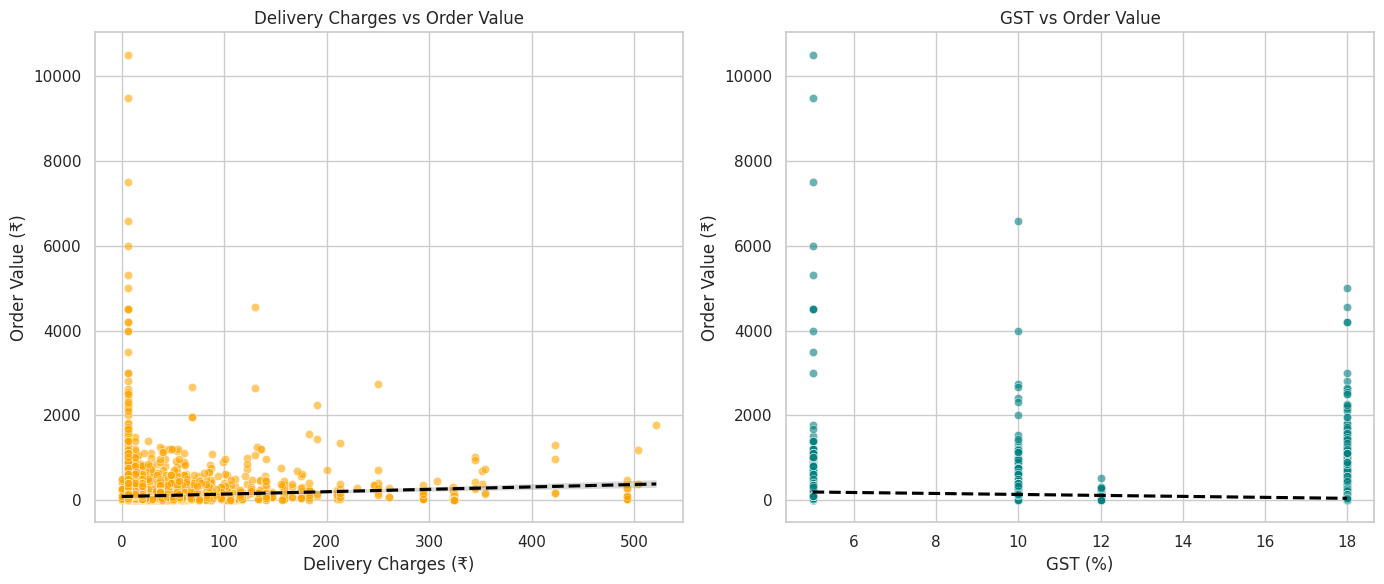

In [702]:
# Step 8: Plotting the relationships
plt.figure(figsize=(14, 6))

# Plot 1: Delivery Charges vs Order Value
plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x='Delivery_Charges', y='Order_Value', alpha=0.6, color='orange')
sns.regplot(data=df, x='Delivery_Charges', y='Order_Value', scatter=False, color='black', line_kws={"linestyle": "--"})
plt.title('Delivery Charges vs Order Value')
plt.xlabel('Delivery Charges (₹)')
plt.ylabel('Order Value (₹)')

# Plot 2: GST vs Order Value
plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x='GST', y='Order_Value', alpha=0.6, color='teal')
sns.regplot(data=df, x='GST', y='Order_Value', scatter=False, color='black', line_kws={"linestyle": "--"})
plt.title('GST vs Order Value')
plt.xlabel('GST (%)')
plt.ylabel('Order Value (₹)')

plt.tight_layout()
plt.show()

**Left Plot: Delivery Charges vs Order Value:**

a. Pearson r = 0.0673:
 - This indicates a very weak positive correlation between delivery charges and order value.

b. p-value = 0.0000:
 - Despite the weak correlation, the p-value is statistically significant (as p < 0.05). This means that the relationship is not due to random chance. So, we will reject the Null Hypothesis.
 - However, practical significance is still very low due to the weak r value.

**Plot Interpretation:**
 - In the above left plot, most of the points are clustered near lower delivery charges and low-to-moderate order values.
 - The trendline (dashed black line) has a slight upward slope, and it is consistent with the weak positive correlation coefficient (r = 0.0673).
 - There are a few high order value outliers, but they do not strongly influence the general trend.

**Proposed Business Suggestions/Conclusion:**

Increasing delivery charges does not meaningfully increase order value. The relationship is statistically significant but practically negligible. Customers do not appear to be spending more just because delivery costs are higher.
 - So, regarding Delivery Charges, since they do not greatly influence order value, company can be experimenting with free delivery thresholds or flat-rate delivery may improve customer satisfaction without significantly reducing revenue.

**Right Plot: GST (Tax %) vs Order Value:**

a. Pearson r = -0.3206:
 - This shows a moderate negative correlation between GST and order value — as GST % increases, order value tends to decrease.

b. p-value = 0.0000:
 - Statistically significant; the observed pattern is unlikely to be due to chance. So, we reject the Null Hypothesis.

**Plot Interpretation:**
 - From the Right plot, there is a clear vertical clusters around discrete GST values (like, 5%, 10%, 12%, 18%), as expected from fixed tax slabs.
 - The trendline shows a noticeable downward slope, reflecting that higher-taxed items are often associated with lower order values.

Possibly due to:
 - High-GST items are essential but not bulk-purchased.
 - Customers avoiding large purchases of high-GST products.

**Proposed Business Suggestions/Conclusion:**
- Higher GST is associated with lower order values. This can inform strategies such as:

 - Bundling high-GST items with discounts.
 - Since high GST correlates with lower order value, so the company could optimize product bundles, discounts, or loyalty incentives for these categories to drive higher revenue.

Business Questions:
19. Identify seasonal trends in sales by category and location. How can the company prepare for peak and off-peak seasons to maximize revenue?

Our approach:

We can define the following Hypothesis.

**Hypothesis-1: For Seasonal Trends (Month-Year-wise Order Value)**

We are testing whether the mean Order Value differs significantly across months, which would indicate seasonal patterns.

**Null Hypothesis (H0):** There is no significant difference in average Order Value across different months (no seasonal trend).

**Alternative Hypothesis (H1):** There is a significant difference in average Order Value across months (seasonal trend exists).

*********************************

**Hypothesis-2: For Regional Sales Trends (Location-wise Order Value)**

We are testing whether the mean Order Value differs significantly across locations, indicating regional performance differences.

**Null Hypothesis (H0):** There is no significant difference in average Order Value between locations.

**Alternative Hypothesis (H1):** There is a significant difference in average Order Value between locations.

In this task, we need to examine and compare specifically, if certain months or locations consistently outperform others, which is crucial for seasonal planning and regional marketing strategies.

So, for comparing the mean order values across multiple months & multiple locations, the ANOVA is the suitable test to be executed here.

In [703]:
# Step 1: Converting Transaction_Date to datetime if not already
online_sales['Transaction_Date'] = pd.to_datetime(online_sales['Transaction_Date'])

# Step 2: Adding Month, Year, and Month-Year
online_sales['Month'] = online_sales['Transaction_Date'].dt.month
online_sales['Year'] = online_sales['Transaction_Date'].dt.year
online_sales['Month_Year'] = online_sales['Transaction_Date'].dt.to_period('M')

# Step 3: Computing Total Order Value
online_sales['Order_Value'] = online_sales['Quantity'] * online_sales['Avg_Price']
online_sales.columns

Index(['CustomerID', 'Transaction_ID', 'Transaction_Date', 'Product_SKU',
       'Product_Description', 'Product_Category', 'Quantity', 'Avg_Price',
       'Delivery_Charges', 'Coupon_Status', 'Order_Value', 'Month', 'Year',
       'Month_Year'],
      dtype='object')

In [704]:
# Step 4: Grouping by Product Category and Month_Year
category_trends = online_sales.groupby(['Month_Year', 'Product_Category'])['Order_Value'].sum().unstack().fillna(0)
category_trends.head(6)

Product_Category  Accessories  Android   Apparel  Backpacks      Bags  \
Month_Year                                                              
2019-01                 51.57    74.24  38300.87     268.19  10903.63   
2019-02                  0.00    19.99  37990.09     559.94  17969.55   
2019-03                 59.99   115.93  59059.02     639.93  14045.65   
2019-04                166.96    39.98  88138.14    1015.04  11385.03   
2019-05                141.14    91.95  58850.90    1371.76   9962.99   
2019-06                207.73   171.90  45941.01     298.36  12867.37   

Product_Category  Bottles  Drinkware      Fun  Gift Cards   Google  Headgear  \
Month_Year                                                                     
2019-01            587.30   14599.09   229.96      283.69   692.44   2060.04   
2019-02            372.93   14334.22   328.98      400.00  1213.61   4572.48   
2019-03            524.98   21228.20   645.33      375.00  2130.35   3121.39   
2019-04            489.00   27090.43  2412.89      725.00   994.52  12194.60   
2019-05           1076.84   16424.25   693.96     1325.00  1424.29   3024.86   
2019-06            564.95   17622.04   596.82     1200.00  1104.45   1305.41   

Product_Category  Housewares  Lifestyle  More Bags  Nest  Nest-Canada  \
Month_Year                                                              
2019-01               929.48    5563.31    1379.16   0.0      9591.11   
2019-02               107.49    6723.54     393.62   0.0      3968.00   
2019-03               483.50    6627.83     505.75   0.0      7614.00   
2019-04                87.00    8804.81     351.80   0.0      5621.00   
2019-05               499.00    5751.76     316.63   0.0      3786.00   
2019-06               356.50    6091.38       0.00   0.0      9257.00   

Product_Category   Nest-USA  Notebooks & Journals    Office    Waze  
Month_Year                                                           
2019-01           284362.08               5998.74  27309.50  440.18  
2019-02           196182.19               4475.87  20994.91  212.39  
2019-03           199700.00               4132.04  27783.12  816.08  
2019-04           182193.00              22772.31  36507.38  629.53  
2019-05           173534.00               5942.88  23022.42  522.79  
2019-06           195413.00               4865.33  22718.12  500.01

Line Plot: Monthly Order Value Trend by Product Category

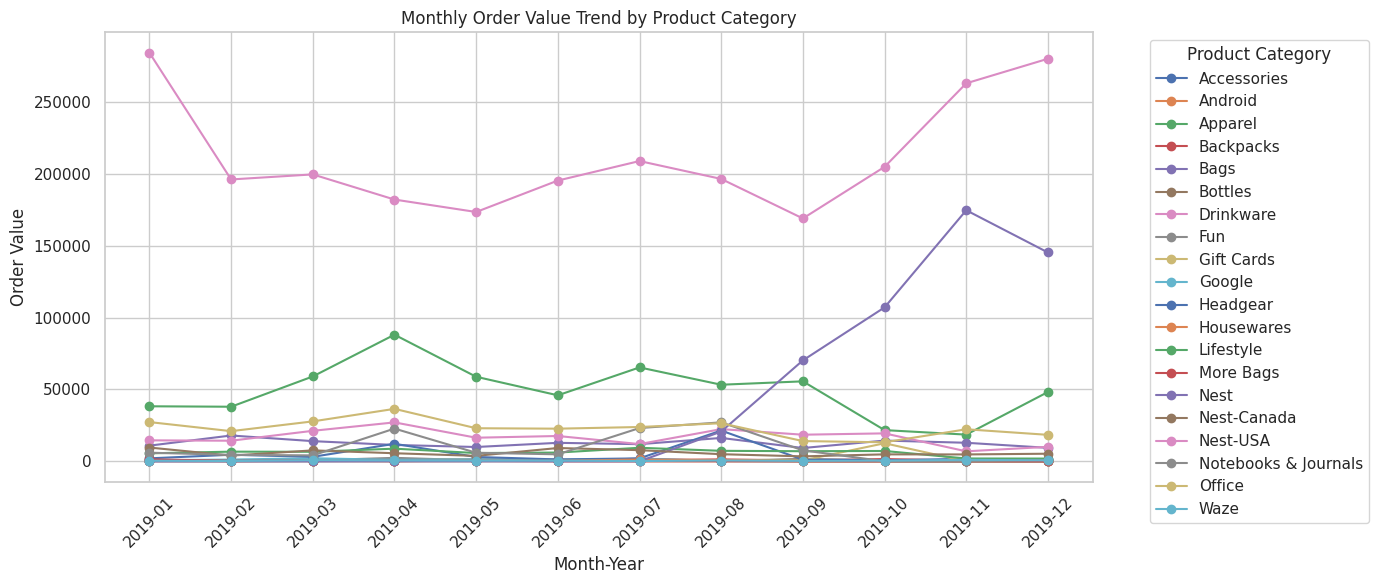

In [705]:
# Converting index to string for plotting
category_trends.index = category_trends.index.astype(str)

# Plotting line chart
plt.figure(figsize=(14, 6))
for category in category_trends.columns:
    plt.plot(category_trends.index, category_trends[category], marker='o', label=category)

plt.title('Monthly Order Value Trend by Product Category')
plt.xlabel('Month-Year')
plt.ylabel('Order Value')
plt.xticks(rotation=45)
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()

Heatmap: Order Value by Month-Year and Product Category

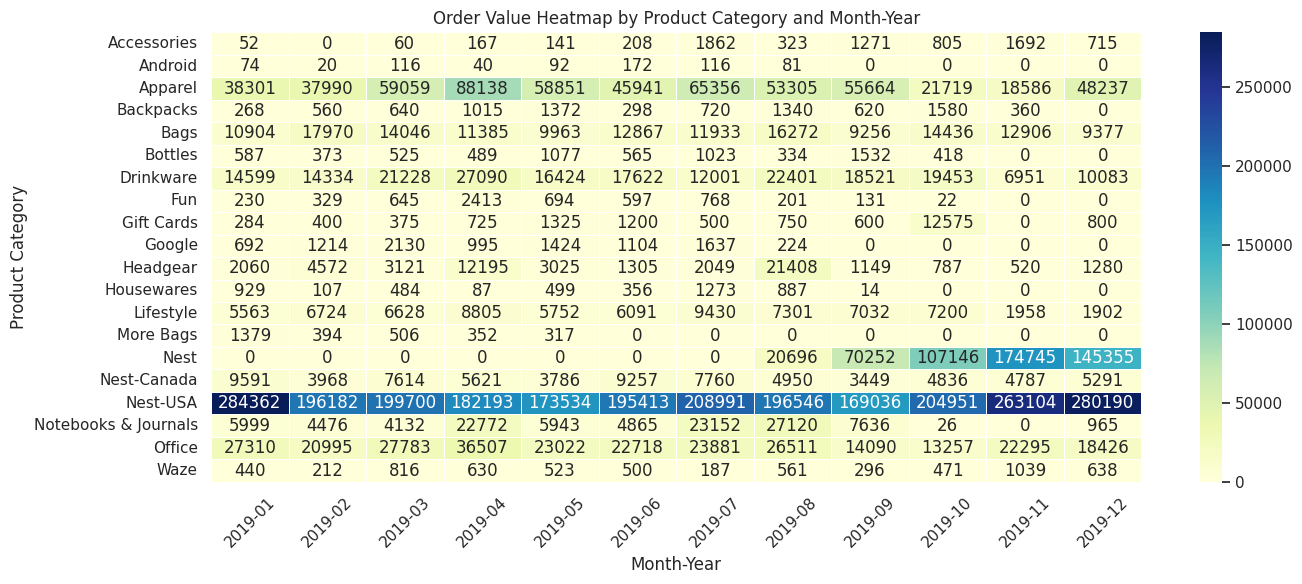

In [706]:
plt.figure(figsize=(14, 6))
sns.heatmap(category_trends.T, cmap='YlGnBu', annot=True, fmt='.0f', linewidths=0.5)

plt.title('Order Value Heatmap by Product Category and Month-Year')
plt.xlabel('Month-Year')
plt.ylabel('Product Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [707]:
# Step-5: Loading Customers_Data to get the 'Location' column
customers_df = pd.read_csv('/content/Customers_Data.csv')

# Step 6: Merging Customer Data to Include Location
merged_df = pd.merge(online_sales, customers_df[['CustomerID', 'Location']], on='CustomerID', how='left')
merged_df.head(6)

CustomerID  Transaction_ID Transaction_Date     Product_SKU  \
0       17850           16679       2019-01-01  GGOENEBJ079499   
1       17850           16680       2019-01-01  GGOENEBJ079499   
2       17850           16681       2019-01-01  GGOEGFKQ020399   
3       17850           16682       2019-01-01  GGOEGAAB010516   
4       17850           16682       2019-01-01  GGOEGBJL013999   
5       17850           16682       2019-01-01  GGOEGBMJ013399   

                                 Product_Description Product_Category  \
0  Nest Learning Thermostat 3rd Gen-USA - Stainle...         Nest-USA   
1  Nest Learning Thermostat 3rd Gen-USA - Stainle...         Nest-USA   
2              Google Laptop and Cell Phone Stickers           Office   
3  Google Men's 100% Cotton Short Sleeve Hero Tee...          Apparel   
4                    Google Canvas Tote Natural/Navy             Bags   
5                                          Sport Bag             Bags   

   Quantity  Avg_Price  Delivery_Charges Coupon_Status  Order_Value  Month  \
0         1     153.71               6.5          Used       153.71      1   
1         1     153.71               6.5          Used       153.71      1   
2         1       2.05               6.5          Used         2.05      1   
3         5      17.53               6.5      Not Used        87.65      1   
4         1      16.50               6.5          Used        16.50      1   
5        15       5.15               6.5          Used        77.25      1   

   Year Month_Year Location  
0  2019    2019-01  Chicago  
1  2019    2019-01  Chicago  
2  2019    2019-01  Chicago  
3  2019    2019-01  Chicago  
4  2019    2019-01  Chicago  
5  2019    2019-01  Chicago

In [708]:
# Step 7: Grouping by Location and Month_Year
location_trends = merged_df.groupby(['Month_Year', 'Location'])['Order_Value'].sum().unstack().fillna(0)

# Step 8: Displaying the first few rows
location_trends.head()

Location    California    Chicago  New Jersey  New York  Washington DC
Month_Year                                                            
2019-01      150241.63  109911.74    31475.72  78217.28       33778.21
2019-02       89727.46  108031.09    30266.50  44748.86       38045.89
2019-03       99243.75  118365.41    19393.74  97026.06       15579.13
2019-04      121139.09  152811.80    44989.45  63181.57       19496.51
2019-05       86602.49  109277.26    28295.03  77345.24        6243.40

Line Plot (Time-Series for Each Location)

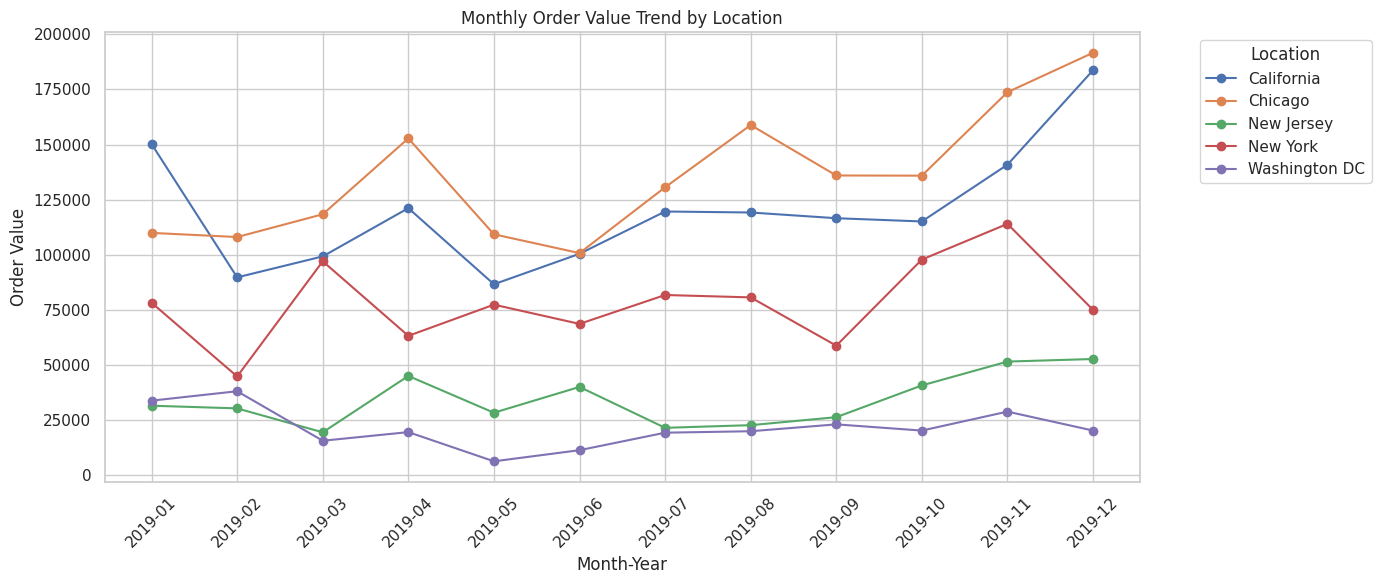

In [709]:
# Step-9: Convert PeriodIndex to string format for plotting
location_trends.index = location_trends.index.astype(str)

# Plotting
plt.figure(figsize=(14, 6))
for location in location_trends.columns:
    plt.plot(location_trends.index, location_trends[location], marker='o', label=location)

plt.title('Monthly Order Value Trend by Location')
plt.xlabel('Month-Year')
plt.ylabel('Order Value')
plt.xticks(rotation=45)
plt.legend(title='Location', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()

Heatmap (Month_Year vs Location)

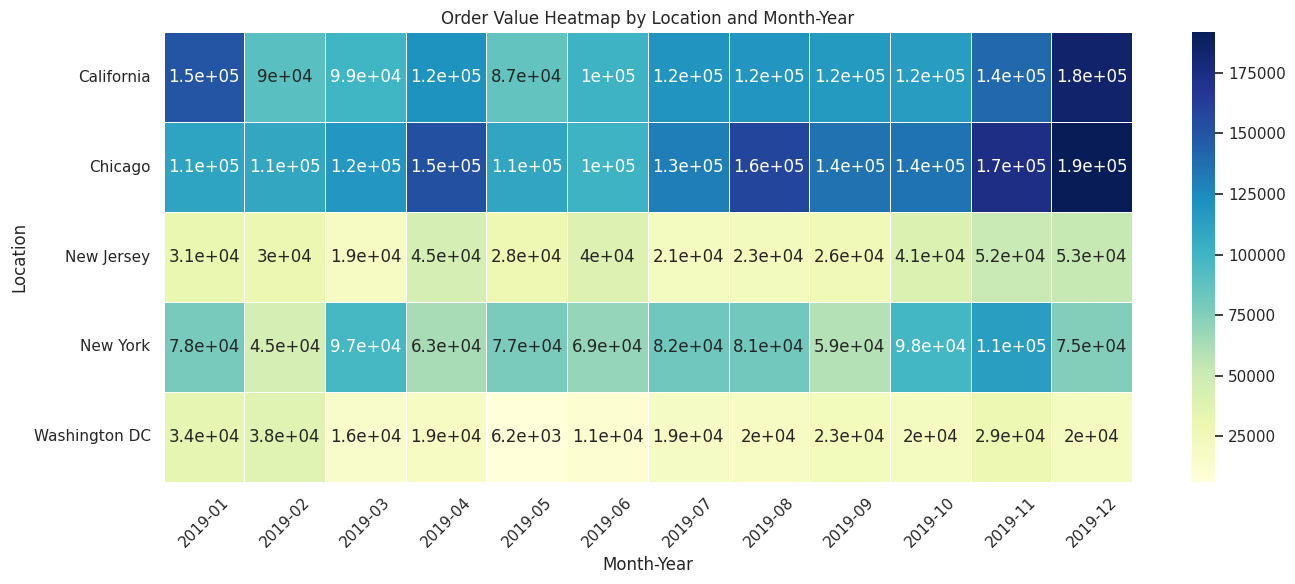

In [710]:
plt.figure(figsize=(14, 6))
sns.heatmap(location_trends.T, cmap='YlGnBu', linewidths=0.5, annot=True)

plt.title('Order Value Heatmap by Location and Month-Year')
plt.xlabel('Month-Year')
plt.ylabel('Location')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Visualization: Seasonal Trends

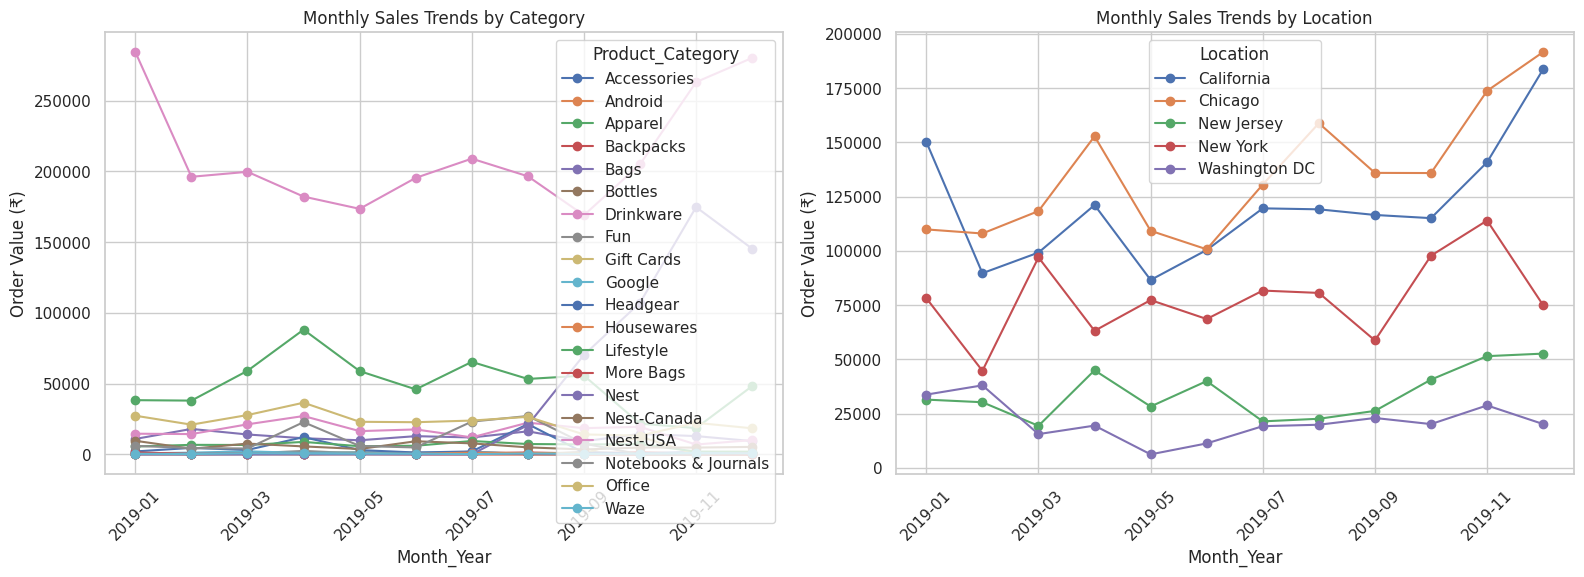

In [711]:
# Step 6: Plot Seasonal Trends
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
category_trends.plot(marker='o', ax=plt.gca())
plt.title("Monthly Sales Trends by Category")
plt.ylabel("Order Value (₹)")
plt.xticks(rotation=45)
plt.grid(True)

plt.subplot(1, 2, 2)
location_trends.plot(marker='o', ax=plt.gca())
plt.title("Monthly Sales Trends by Location")
plt.ylabel("Order Value (₹)")
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.show()

**Left Plot: Monthly Sales Trends by Product Category**

 - This line plot shows how sales fluctuate monthly across different product categories.

**Gathered insights:**
 - Drinkware is consistently the highest-selling category and shows seasonal spikes, especially in Jan and Nov 2019.
 - Categories like Apparel, Lifestyle, and Housewares also show noticeable seasonal variations.
 - Some categories remain relatively flat and low (like, Gift Cards, Waze, Notebooks)- This is implying low-performing products.

**Right Plot: Monthly Sales Trends by Location**
 - This line plot shows how different locations perform over the year in terms of total order value.

**Gathered insights:**
 - Chicago and California are the top-performing locations, with noticeable peak sales around Nov 2019 (likely due to festive season).
 - Locations like New Jersey and Washington DC have lower sales volumes, but New Jersey shows consistent growth.
 - These trends indicate regional demand variation that can inform location-specific inventory and campaign planning.


 To validate whether seasonal fluctuations or differences between groups (like months or locations) are statistically significant, we can use **ANOVA** Test.

**ANOVA: Do Order Values Differ Significantly by Month?**

In [712]:
# Extracting month from Month_Year
online_sales['Month'] = online_sales['Month_Year'].dt.month

# Grouping data by Month
groups_by_month = [group['Order_Value'].values for name, group in online_sales.groupby('Month')]

# Run one-way ANOVA
f_stat, p_value = stats.f_oneway(*groups_by_month)

print("ANOVA Results for Monthly Order Value:")
print(f"F-statistic = {f_stat:.4f}, p-value = {p_value:.4f}")

ANOVA Results for Monthly Order Value:
F-statistic = 65.2249, p-value = 0.0000


a. ANOVA: Monthly Order Value

**Result:**

F-statistic = 65.2249

p-value = 0.0000 (essentially < 0.001)

**Inference:**
 - Since the p-value is much less than 0.05, we reject the null hypothesis.
 - There is a statistically significant difference in average Order Value across different months.
 - This confirms the presence of seasonal trends in sales, meaning certain months consistently perform better or worse in terms of revenue.

**Proposed Business Suggestions:**
 - We can confidently plan inventory, staffing, and marketing budgets based on seasonal demand. For instance, we can increase stock and promotions in peak months like January and November.

**ANOVA: Do Order Values Differ by Location?**

In [713]:
# Ensure Location column exists in merged_df
groups_by_location = [group['Order_Value'].values for name, group in merged_df.groupby('Location')]

# Run one-way ANOVA
f_stat_loc, p_value_loc = stats.f_oneway(*groups_by_location)

print("\nANOVA Results for Order Value by Location:")
print(f"F-statistic = {f_stat_loc:.4f}, p-value = {p_value_loc:.4f}")


ANOVA Results for Order Value by Location:
F-statistic = 3.2450, p-value = 0.0114


b. ANOVA: Order Value by Location

**Result:**

F-statistic = 3.2450

p-value = 0.0114

**Inference:**
 - The p-value is less than 0.05, so again, we reject the null hypothesis.
 - There is a statistically significant difference in average Order Value across locations.
 - This indicates that not all regions perform equally — some consistently generate more revenue than others.

**Proposed Business Suggestions:**

You should adopt location-based strategies, such as:
 - We can be prioritizing high-performing locations like Chicago and California with more inventory and can invest higher for marketing.
 - We should be identifying low-performing regions (like, Washington DC) and then exploring if this is due to logistics, demand, or product relevance.

Business Questions:

20. Analyze daily sales trends to identify high-performing and low-performing days. What strategies can be implemented to boost sales on slower days?

Our approach:

We need to perform the following steps:
 - First we will extract day of the week from Transaction_Date.
 - Then we need to Group sales by day to compute total Order_Value for each weekday.
 - Then we need to conduct an ANOVA test to check if differences in daily sales are statistically significant.

Here, we define the Hypothesis for ANOVA.

**ANOVA Hypothesis Test**

**Null Hypothesis (H0):** Mean order values are the same across all days of the week.

**Alternative Hypothesis (H1):** At least one day has a significantly different mean order value.

In [714]:
# Step 1: Converting 'Transaction_Date' into datetime format
online_sales['Transaction_Date'] = pd.to_datetime(online_sales['Transaction_Date'])

# Step 2: Creating a new column for day of the week
online_sales['DayOfWeek'] = online_sales['Transaction_Date'].dt.day_name()
online_sales.head(15)

CustomerID  Transaction_ID Transaction_Date     Product_SKU  \
0        17850           16679       2019-01-01  GGOENEBJ079499   
1        17850           16680       2019-01-01  GGOENEBJ079499   
2        17850           16681       2019-01-01  GGOEGFKQ020399   
3        17850           16682       2019-01-01  GGOEGAAB010516   
4        17850           16682       2019-01-01  GGOEGBJL013999   
5        17850           16682       2019-01-01  GGOEGBMJ013399   
6        17850           16682       2019-01-01  GGOEGDHC018299   
7        17850           16682       2019-01-01  GGOEGDHG014499   
8        17850           16682       2019-01-01  GGOEGDWC020199   
9        13047           16682       2019-01-01  GGOEGGOA017399   
10       13047           16682       2019-01-01  GGOEGOFH020299   
11       13047           16682       2019-01-01  GGOEGOXQ016399   
12       13047           16682       2019-01-01  GGOEYAAB031816   
13       13047           16684       2019-01-01  GGOENEBQ078999   
14       13047           16684       2019-01-01  GGOENEBQ079199   

                                  Product_Description Product_Category  \
0   Nest Learning Thermostat 3rd Gen-USA - Stainle...         Nest-USA   
1   Nest Learning Thermostat 3rd Gen-USA - Stainle...         Nest-USA   
2               Google Laptop and Cell Phone Stickers           Office   
3   Google Men's 100% Cotton Short Sleeve Hero Tee...          Apparel   
4                     Google Canvas Tote Natural/Navy             Bags   
5                                           Sport Bag             Bags   
6                           Google 22 oz Water Bottle        Drinkware   
7                     Google Infuser-Top Water Bottle        Drinkware   
8                         Engraved Ceramic Google Mug        Drinkware   
9                                            Maze Pen           Office   
10                       Galaxy Screen Cleaning Cloth           Office   
11                                       Badge Holder           Office   
12          YouTube Men's Short Sleeve Hero Tee Black          Apparel   
13             Nest Cam Outdoor Security Camera - USA         Nest-USA   
14      Nest Protect Smoke + CO White Wired Alarm-USA         Nest-USA   

    Quantity  Avg_Price  Delivery_Charges Coupon_Status  Order_Value  Month  \
0          1     153.71               6.5          Used       153.71      1   
1          1     153.71               6.5          Used       153.71      1   
2          1       2.05               6.5          Used         2.05      1   
3          5      17.53               6.5      Not Used        87.65      1   
4          1      16.50               6.5          Used        16.50      1   
5         15       5.15               6.5          Used        77.25      1   
6         15       3.08               6.5      Not Used        46.20      1   
7         15      10.31               6.5       Clicked       154.65      1   
8          5       9.27               6.5          Used        46.35      1   
9         52       0.98               6.5          Used        50.96      1   
10        31       1.99               6.5       Clicked        61.69      1   
11        31       1.99               6.5       Clicked        61.69      1   
12         5      17.53               6.5          Used        87.65      1   
13         2     122.77               6.5       Clicked       245.54      1   
14         1      81.50               6.5          Used        81.50      1   

    Year Month_Year DayOfWeek  
0   2019    2019-01   Tuesday  
1   2019    2019-01   Tuesday  
2   2019    2019-01   Tuesday  
3   2019    2019-01   Tuesday  
4   2019    2019-01   Tuesday  
5   2019    2019-01   Tuesday  
6   2019    2019-01   Tuesday  
7   2019    2019-01   Tuesday  
8   2019    2019-01   Tuesday  
9   2019    2019-01   Tuesday  
10  2019    2019-01   Tuesday  
11  2019    2019-01   Tuesday  
12  2019    2019-01   Tuesday  
13  2019    2019-01   Tuesday  
1

In [715]:
# Step 3: Calculating total sales by day of the week
daily_sales = online_sales.groupby('DayOfWeek')['Order_Value'].sum().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])
daily_sales.head(6)

DayOfWeek
Monday       365626.90
Tuesday      396819.65
Wednesday    826622.00
Thursday     840433.85
Friday       872004.86
Saturday     673068.03
Name: Order_Value, dtype: float64

<ipython-input-716-1ff64c03ac58>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=daily_sales.index, y=daily_sales.values, palette="coolwarm")


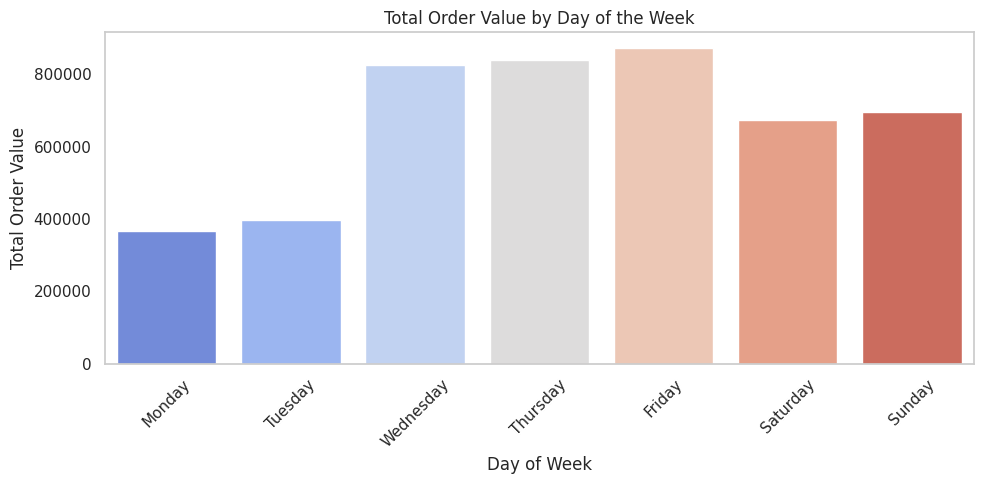

In [716]:
# Step 3: Plotting the Daily Sales
plt.figure(figsize=(10, 5))
sns.barplot(x=daily_sales.index, y=daily_sales.values, palette="coolwarm")
plt.title('Total Order Value by Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Total Order Value')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

**Insights:**
From the above bar plot, we can notice the following.
 - There are higher order values on specific days (like, Wednesdays, Thursdays or Fridays).
 - There are moderate order values on specific days (like, Weekends).
 - There are lower order values on starting days (like, Monday & Tuesday).

In [717]:
# Step 4: Preparing data for ANOVA Test
anova_data = [online_sales[online_sales['DayOfWeek'] == day]['Order_Value'] for day in daily_sales.index]

# Step 5: Running ANOVA
f_stat, p_value = f_oneway(*anova_data)

# Step 6: Print ANOVA Results
print("===== ANOVA Test for Daily Order Value =====")
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_value:.4f}")

===== ANOVA Test for Daily Order Value =====
F-statistic: 9.9844
p-value: 0.0000


**Result**

F-statistic: 9.9844

p-value: 0.0000

**Inference:**
 - The p-value is less than 0.05, which means we reject the null hypothesis.
 - This confirms that there is a statistically significant difference in the average daily sales across the days of the week.
 - In other words, some days perform significantly better or worse than others in terms of order value. This validates the existence of high-performing and low-performing days (as we achieved in the above Barplot in this task).

**Proposed Business Suggestions:**

a. Targeted Discounts or Flash Sales- Launch mid-week flash sales or “Tuesday Specials” to drive urgency on low-traffic days.

b. Free Delivery or Reduced Charges on Slow Days- Company can offer free or discounted delivery on historically low-performing days ( (like, Monday & Tuesday). It may pull customers to place orders on Monday & Tuesday.

c. Loyalty Boosts- Company can give double loyalty points or cashback on purchases made during low-performing days.

d. Email or SMS Campaigns- Company can send personalized recommendations or limited-time offers on those low-performing days to increase engagement.

e. Cross-Selling & Bundles- Company should promote product bundles at a discount during slow days to increase order value.

f. Influencer or Social advertisements- Company can run campaigns with influencers specifically promoting Monday & Tuesday deals and weekend deals.

